# Load Dataset

In [1]:
import os
import time
import numpy as np
import torch
import math
import tqdm
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.distributions import MultivariateNormal, Categorical, Normal
from models_modules import MLP, CNNFastEncoder, CNNFastDecoder
from model_neuralmsm import NeuralMSM
from sklearn.decomposition import PCA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class BouncingBallDataLoader(Dataset):

    def __init__(self, root_dir):
        if isinstance(root_dir,str):
            self.root_dir = root_dir
            self.file_list = sorted(os.listdir(root_dir))
            self.multiple = False
            self.filenames = None
        else:
            self.root_dir = root_dir
            self.file_list = []
            for dir in root_dir:
                for filename in sorted(os.listdir(dir)):
                    self.file_list.append(os.path.join(dir,filename))
            self.multiple = True

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, i):
        sample = np.load(os.path.join(
            self.root_dir, self.file_list[i])) if not self.multiple else np.load(self.file_list[i])
        im = sample['arr_0']
        if len(im.shape) == 3:
            im = im[:,np.newaxis,:,:]
        else:
            im = im.astype(float)
            if im.max() > 2.0:
                im /= 255.0
            im = im.transpose((0,3,1,2)) - 0.5
        return (im[::2],) # [::2] takes every second frame

In [4]:
seed = 24 # 23 24 25 26 27
num_states = 3
dim_obs = 2
dim_latent = 2
T = 200
data_size = 5000
sparsity_prob = 0.0
data_type = 'cosine'
degree = 3
restarts_num = 10
images = True



path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/images_train_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}/".format(data_size,T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)
test_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/images_test_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}/".format(data_size//10,T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)

dl = BouncingBallDataLoader(path)
test_dl = BouncingBallDataLoader(test_path)
exp_name = 'inferred_params_images_N_{}_T_{}_dim_latent_{}_state_{}_sparsity_{}_net_{}_seed_{}'.format(data_size,
        T, dim_latent, num_states, sparsity_prob, data_type, seed)

final_temperature = 1


pre_train_check = 10
init_temperature = 10
iter_update_temp = 50
iter_check_temp = 200
epoch_num = 200
learning_rate = 5e-4
gamma_decay = 0.8
scheduler_epochs = 80
decay_rate = 0.975

best_elbo = -torch.inf

dataloader = DataLoader(dl, batch_size=8, shuffle=True) # 4 - iwae, 8 - fivo, 8 - elbo
test_dataloader = DataLoader(test_dl, batch_size=16, shuffle=False)

In [5]:
np.min(dataloader.dataset[0][0]+0.5), np.max(dataloader.dataset[0][0]+0.5)

(0.31764705882352934, 0.996078431372549)

In [6]:
dataloader.dataset[0][0].shape

(100, 3, 32, 32)

In [7]:
def imshow_grid(images, n_row=8, n_col=8, title="", fig_size_a=10, fig_size_b=10):
    # fig_size_a is width
    # fig_size_b is length    
    fig, axes = plt.subplots(n_row, n_col, figsize=(fig_size_a, fig_size_b))
    fig.suptitle(title)
    for i in range(n_row):
        for j in range(n_col):
            axes[i, j].imshow((np.transpose(images[i,j],(1,2,0))+0.5))
            axes[i, j].axis('off')
    plt.show()

# Visualize

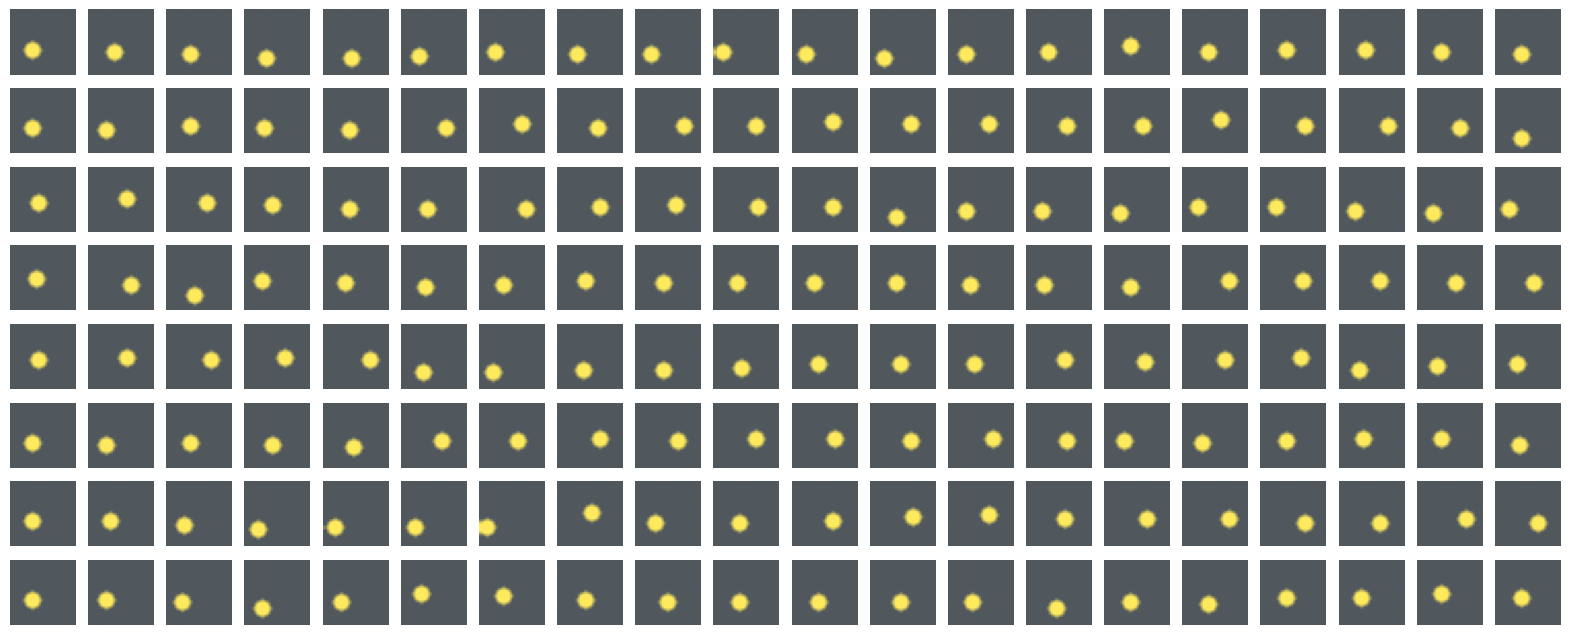

In [8]:
# Visualize a batch of training data
(batch_images,) = next(iter(dataloader))
imshow_grid(batch_images[0:10],n_col=20,fig_size_a=20, fig_size_b=8)  # Displaying the first batch

In [9]:
def plot_models(gamma, gamma2, gamma3, latents_states, xtick_labels=None):
    # gamma: [B, T, num_states]
    # latents_states: [B, num_states]
    N = 2
    T = gamma.shape[1]
    states = torch.zeros(T, 3)
    states[range(T), latents_states[N, :].long()] = 1    

    # Plotting
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 3.5), sharex=True)

    # Plotting Model 1
    im1 = axes[0].imshow(states[:T, :].T, vmin=0, vmax=1)

    # Plotting Model 2
    im2 = axes[1].imshow(gamma[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    # Plotting Model 3
    im3 = axes[2].imshow(gamma2[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    # Plotting Model 4
    im4 = axes[3].imshow(gamma3[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    for ax in axes:
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)     # Hide the top spine
        ax.spines['right'].set_visible(False)   # Hide the right spine
        ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
        ax.spines['left'].set_visible(False)    # Hide the left spine
        ax.grid(False)
        # Remove tick marks
        ax.tick_params(axis='x', which='both', length=0, width=0)  # Remove x-axis ticks
        ax.tick_params(axis='y', which='both', length=0, width=0)  # Remove y-axis ticks

    # Adding model names to the left of each subplot
    axes[0].text(-0.01, 0.5, 'Ground Truth', va='center', ha='right', transform=axes[0].transAxes, fontsize=10)
    axes[1].text(-0.01, 0.5, 'ELBO', va='center', ha='right', transform=axes[1].transAxes, fontsize=10)
    axes[2].text(-0.01, 0.5, 'IWAE', va='center', ha='right', transform=axes[2].transAxes, fontsize=10)
    axes[3].text(-0.01, 0.5, 'FIVO', va='center', ha='right', transform=axes[3].transAxes, fontsize=10)

    # Adjust layout to remove space between subplots
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)

    # Add a colorbar to the center right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im2, cax=cbar_ax)

    axes[0].set_xlim((0, T))

    # Set the x-axis label on the bottom plot only
    axes[3].set_xlabel('Timestep')
    current_xticks = axes[1].get_xticks()  # Get the current x-tick positions
    new_labels = np.linspace(xtick_labels[0], xtick_labels[1], num=len(current_xticks))
    axes[3].set_xticklabels([f'{int(label)}' for label in new_labels])
    
    plt.show()

def plot_2_models(gamma, latents_states, title='ELBO',N=2):
    # gamma: [B, T, num_states]
    # latents_states: [B, num_states]
    T = gamma.shape[1]
    states = torch.zeros(T, 3)
    states[range(T), latents_states[N, :].long()] = 1    

    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 1.5), sharex=True)

    # Plotting Model 1
    im1 = axes[0].imshow(states[:T, :].T, vmin=0, vmax=1)

    # Plotting Model 2
    im2 = axes[1].imshow(gamma[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    for ax in axes:
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)     # Hide the top spine
        ax.spines['right'].set_visible(False)   # Hide the right spine
        ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
        ax.spines['left'].set_visible(False)    # Hide the left spine
        ax.grid(False)
        # Remove tick marks
        ax.tick_params(axis='x', which='both', length=0, width=0)  # Remove x-axis ticks
        ax.tick_params(axis='y', which='both', length=0, width=0)  # Remove y-axis ticks

    # Adding model names to the left of each subplot
    axes[0].text(-0.01, 0.5, 'Ground Truth', va='center', ha='right', transform=axes[0].transAxes, fontsize=10)
    axes[1].text(-0.01, 0.5, title, va='center', ha='right', transform=axes[1].transAxes, fontsize=10)


    # Adjust layout to remove space between subplots
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)

    # Add a colorbar to the center right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im2, cax=cbar_ax)

    axes[0].set_xlim((0, T))

    # Set the x-axis label on the bottom plot only
    axes[1].set_xlabel('Timestep')
    
    plt.show()    

In [ ]:
def best_f1_score(ground_truth, posterior_probs):
    """
    Calculate the best F1 score for the given ground truth and posterior probabilities tensors.

    Parameters:
    - ground_truth: A numpy array of shape [B, T] with integers 0, 1, 2 representing the ground truth states.
    - posterior_probs: A numpy array of shape [B, T, 3] with posterior probabilities for each state.

    Returns:
    - best_f1: The best F1 score after testing all permutations of the states.
    """
    # Find the predicted states by taking the argmax over the last dimension
    predicted_states = np.argmax(posterior_probs, axis=-1)

    # List all possible permutations of (0, 1, 2)
    state_permutations = list(permutations([0, 1, 2]))

    best_f1 = 0.0
    
    # Iterate over all permutations
    for perm in state_permutations:
        # Map predicted states according to the current permutation
        mapped_predictions = np.copy(predicted_states)
        for original_state, new_state in enumerate(perm):
            mapped_predictions[predicted_states == original_state] = new_state
        
        # Calculate F1 score for this permutation
        f1 = f1_score(ground_truth.flatten(), mapped_predictions.flatten(), average='macro')
        
        # Update best F1 score
        if f1 > best_f1:
            best_f1 = f1
    
    return best_f1


def best_cross_entropy_loss(ground_truth, posterior_probs):
    """
    Calculate the best cross-entropy loss for the given ground truth and posterior probabilities tensors.

    Parameters:
    - ground_truth: A numpy array of shape [B, T] with integers 0, 1, 2 representing the ground truth states.
    - posterior_probs: A numpy array of shape [B, T, 3] with posterior probabilities for each state.

    Returns:
    - best_cross_entropy: The lowest cross-entropy loss after testing all permutations of the states.
    """
    ground_truth = ground_truth.astype(int)

    # List all possible permutations of (0, 1, 2)
    state_permutations = list(permutations([0, 1, 2]))

    best_cross_entropy = np.inf
    
    # Iterate over all permutations
    for perm in state_permutations:
        # Map the posterior probabilities according to the current permutation
        mapped_probs = np.zeros_like(posterior_probs)
        for i, new_state in enumerate(perm):
            mapped_probs[..., new_state] = posterior_probs[..., i]
        
        # Calculate cross-entropy loss for this permutation
        # One-hot encode the ground truth
        ground_truth_one_hot = np.eye(3)[ground_truth]
        
        # Clip the mapped probabilities to avoid log(0)
        clipped_probs = np.clip(mapped_probs, 1e-12, 1 - 1e-12)
        
        # Calculate cross-entropy loss
        cross_entropy = -np.sum(ground_truth_one_hot * np.log(clipped_probs)) / ground_truth.size
        
        # Update best cross-entropy loss
        if cross_entropy < best_cross_entropy:
            best_cross_entropy = cross_entropy
    
    return best_cross_entropy


# Create Model

### Helper Functions

In [10]:
def normal_logprob(x,mu,sigma):
    """
    Function that calculates the log probability of a multivariate normal distribution
    with diagonal covariance matrix.
    
    Args:
        x (torch.Tensor): Value at which the log probability is evaluated. Shape: [B,d]
        mu (torch.Tensor): Mean of the multivariate distribution. Shape: [B,d]
        sigma (torch.Tensor): Diagonal values of the covariance matrix of the
                              multivariate distribution. Shape: [B,d]
    """
    dev = x.device
    B,d = mu.shape
    
    if len(sigma.shape) == 0:
        sigma = sigma.repeat(B,d)

    a = torch.tensor(([-(d/2) * torch.log(torch.tensor(2)*torch.pi)]*B), device=dev)
    b = - 0.5 * torch.log(sigma).sum(1)
    c = - 0.5 * (((x - mu)**2/sigma).sum(1))
    return a+b+c

def resample(x,weights,N):
    """
    Modified from https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/system/fivo.py
    Function that resamples N particles based on their weight
    Args: 
        x (torch.Tensor): Shape is [P,B,H]
        weights (torch.Tensor): Log weights. Shape is [P,B]
        N (int): Number of particles to resample
    Returns:
        torch.Tensor: Resampled particles of shape [P,B,H] 
    """
    weights = weights - torch.logsumexp(weights, dim=0) # Normalise log weights
    categorical = Categorical(logits=weights.permute([1,0]))    
    indices = categorical.sample(torch.Size([N])) # shape [P,B]
    x = torch.gather(x, 0, indices.unsqueeze(2).repeat(1,1,x.size(2)))
    return x

### Model Definition

In [11]:
class VariationalSNLDS(nn.Module):
    ## Class could be combined with Abstract class MSM for code efficiency
    ## The model allows different settings where annealing=True implements schedule from
    ## Dong et al. (2020) https://proceedings.mlr.press/v119/dong20e.html;
    ## and inference=='alpha' implements Ansari et al. (2023) loss function
    ## https://arxiv.org/abs/2110.13878
    ## We recommend the setting with annealing=False and inference='alpha' and recurent encoder
    ## which is the best that worked for estimation.
    def __init__(self, obs_dim, latent_dim, hidden_dim, num_states, beta=1, encoder_type='recurent', device='cpu', annealing=False, inference='alpha'):
        super(VariationalSNLDS, self).__init__()
        self.obs_dim = obs_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_states = num_states
        self.device = device
        self.beta = beta
        self.var = torch.tensor(5e-4).to(device)
        self.scaling = 0
        self.temperature = 1
        self.annealing = annealing
        self.inference = inference
        if annealing:
            self.scaling = 1e6
            self.temperature = 1e6
        self.encoder_type = encoder_type
        n_feat = 64
        n_layers = 2
        ## Neural net params
        # Transitions p(z_t|z_t-1,s_t)
        self.transitions = nn.ModuleList([MLP(latent_dim, latent_dim, hidden_dim, 'softplus') for _ in range(self.num_states)]).to(device).float()
        # Encoder q(z|x)
        if self.encoder_type=='factored':
            #self.encoder = nn.Linear(obs_dim, 2*latent_dim).to(device).float()
            self.encoder = MLP(obs_dim, 2*latent_dim, hidden_dim, 'leakyrelu').to(device).float()
        elif self.encoder_type=='video':
            self.img_embedding = CNNFastEncoder(3, hidden_dim, n_feat, n_layers=n_layers).to(device).float()
            self.encoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device).float()
            self.encoder_causal = nn.LSTM(hidden_dim*2, hidden_dim, num_layers=2, batch_first=True, bidirectional=False).to(device).float()
            self.encoder_mean_var = nn.Linear(hidden_dim, 2*latent_dim).to(device).float()
        else:
            self.encoder = nn.LSTM(obs_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device).float()
            self.encoder_causal = nn.LSTM(hidden_dim*2, hidden_dim, num_layers=2, batch_first=True, bidirectional=False).to(device).float()
            self.encoder_mean_var = nn.Linear(hidden_dim, 2*latent_dim).to(device).float()
        # Decoder p(x|z)
        if self.encoder_type=='video':
            self.decoder = CNNFastDecoder(latent_dim, 3, n_feat, n_layers=n_layers).to(device).float()
        else:
            self.decoder = MLP(latent_dim, obs_dim, hidden_dim, 'leakyrelu').to(device).float()
        #self.decoder = nn.Linear(latent_dim, obs_dim).to(device)
        ## MSM params
        # logits of p(s_t|s_t-1)
        self.Q = nn.Parameter(torch.zeros(self.num_states, self.num_states).to(device).float())
        # logits of p(s_1)
        self.pi = nn.Parameter(torch.zeros(num_states).to(device).float())
        #self.pi = torch.zeros(num_states).to(device)
        # Init mean and covariances
        self.init_mean = nn.Parameter(torch.randn(self.num_states, self.latent_dim).to(device).float())
        self.init_cov = nn.Parameter(((torch.rand(self.num_states,1,1)*torch.eye(self.latent_dim)[None,:,:])*5).to(device).float())
        self.covs = nn.Parameter((torch.eye(self.latent_dim)[None,:,:]).repeat(self.num_states,1,1).to(device).float()) # identity covariance
    
    def _encode_obs(self, x):
        if self.encoder_type=='factored':
            (B, T, D) = x.shape
            (z_mu, z_log_var) = self.encoder(x.reshape(B*T,-1)).split(self.latent_dim, dim=-1)
        elif self.encoder_type=='video':
            (B, T, C, W, H) = x.shape
            x = self.img_embedding(x.reshape(B*T,C,W,H)).reshape(B,T,-1)
            output, _ = self.encoder(x)
            # output contains h^x_{1:T}
            output, _ = self.encoder_causal(output)
            (z_mu, z_log_var) = self.encoder_mean_var(output).split(self.latent_dim, dim=-1)
        else:
            output, _ = self.encoder(x)
            # output contains h^x_{1:T}
            output, _ = self.encoder_causal(output)
            (z_mu, z_log_var) = self.encoder_mean_var(output).split(self.latent_dim, dim=-1)
        eps = torch.normal(mean=torch.zeros_like(z_mu)).to(x.device)
        z_std = (z_log_var*0.5).exp()
        sample = z_mu + z_std*eps
        return sample, z_mu, z_log_var

    def _compute_local_evidence(self, z):
        T = z.size(1)
        init_distrib_ = torch.distributions.MultivariateNormal(self.init_mean, torch.matmul(self.init_cov,self.init_cov.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(self.device))
        log_local_evidence_1 = init_distrib_.log_prob(z[:,0:1,None,:].repeat(1,1,self.num_states,1)) # shape [B,1,num_states]
        if T==1:
            return log_local_evidence_1
        means_ = torch.cat([self.transitions[i](z[:,:-1, None,:]) for i in range(self.num_states)], dim=2) # shape [B,T-1,num_states,latent_dim]
        covs = torch.matmul(self.covs,self.covs.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(self.device) # [num_states,latent_dim,2]
        distribs = [torch.distributions.MultivariateNormal(means_[:,:,i,:], covs[i,:,:]) for i in range(self.num_states)]
        log_local_evidence_T = torch.cat([distribs[i].log_prob(z[:,1:,:])[:,:,None] for i in range(self.num_states)], dim=2) # [B,T-1,num_states]
        return torch.cat([log_local_evidence_1, log_local_evidence_T], dim=1) # [B,T,num_states]
    
    def next_evidence(self,z):
        T = z.size(1)
        means_ = torch.cat([self.transitions[i](z[:,:-1, None,:]) for i in range(num_states)], dim=2) # shape [B,T-1,num_states,latent_dim]
        covs = torch.matmul(self.covs,self.covs.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(device) # [num_states,latent_dim,2]
        distribs = [torch.distributions.MultivariateNormal(means_[:,:,i,:], covs[i,:,:]) for i in range(num_states)]  
        log_local_evidence_T = torch.cat([distribs[i].log_prob(z[:,1:,:])[:,:,None] for i in range(num_states)], dim=2) # [B,T-1,num_states]
        return log_local_evidence_T      

    def _alpha(self, local_evidence):
        N, T, _ = local_evidence.shape
        log_Z = torch.zeros((N,T)).to(self.device)
        log_alpha = torch.zeros((N, T, self.num_states)).to(self.device)
        # softmax is just to normalise the probabilities
        # shape: [B,num_states]
        log_prob = local_evidence[:,0,:] + torch.log((self.pi/self.temperature).softmax(-1)) # log p(z_1|s_1) - log p(s_1)
        log_Z[:,0] = torch.logsumexp(log_prob, dim=-1) # log p(z_1), [B]
        log_alpha[:,0,:] = log_prob - log_Z[:,0,None] # log p(s_1|z_1) [B,num_states]
        Q = (self.Q[None,None,:,:].expand(N,T,-1,-1)/self.temperature).softmax(-1).transpose(2,3).log() # [B,T,num_states,num_states]
        for t in range(1, T):
            #log_prob = local_evidence[:,t,:] + torch.log(torch.matmul((Q.transpose(2,3))[:,t,:,:],alpha[:,t-1,:,None]))[:,:,0]
            log_prob = torch.logsumexp(local_evidence[:,t,:, None] + Q[:,t,:,:] + log_alpha[:,t-1,None,:], dim=-1) 
            
            log_Z[:,t] = torch.logsumexp(log_prob, dim=-1)
            log_alpha[:,t,:] = log_prob - log_Z[:,t,None]
        return log_alpha, log_Z # shapes [B,T,num_states], [B,T] // log_Z: p(z_t|z_{1:t-1}) 

    def next_z(self,local_evidence,log_alpha,log_Z):
        """
        Function that updates the log_Z for the next T timesteps.
        Args:
            local_evidence (torch.Tensor): Shape [B,T,num_states]
            log_alpha (torch.Tensor): Shape [B,num_states]
            log_Z (torch.Tensor): Shape [B]
        """
        B, T, _ = local_evidence.shape
        log_Z_new = torch.zeros((B,T+1)).to(device)
        log_alpha_new = torch.zeros((B, T+1, num_states)).to(device)

        log_Z_new[:,0] = log_Z
        log_alpha_new[:,0,:] = log_alpha

        Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1).transpose(2,3).log() # [B,T,num_states,num_states]
        for t in range(1,T+1):
            log_prob = torch.logsumexp(local_evidence[:,t-1,:, None] + Q[:,t-1,:,:] + log_alpha_new[:,t-1,None,:], dim=-1) 
            log_Z_new[:,t] = torch.logsumexp(log_prob, dim=-1)
            log_alpha_new[:,t,:] = log_prob - log_Z_new[:,t,None]

        return log_alpha_new[:,1:], log_Z_new[:,1:]             

    def _beta(self, local_evidence, log_Z):
        N, T, _ = local_evidence.shape
        log_beta = torch.zeros((N, T, self.num_states)).to(self.device)
        Q = (self.Q[None,None,:,:].expand(N,T,-1,-1)/self.temperature).softmax(-1).log()
        for t in reversed(range(1, T)):
            #beta_ = torch.matmul(Q[:,t,:,:], (torch.exp(local_evidence[:,t,:])*beta[:,t,:])[:,:,None])[:,:,0]
            beta_ = torch.logsumexp(Q[:,t,:,:] + local_evidence[:,t,None,:] + log_beta[:,t,None,:], dim=-1)
            log_beta[:,t-1,:] = beta_ - log_Z[:,t,None]
        return log_beta
    
    def _compute_posteriors(self, log_evidence):
        log_alpha, log_Z = self._alpha(log_evidence)
        log_beta = self._beta(log_evidence, log_Z)
        log_gamma = log_alpha + log_beta
        B, T, _ = log_evidence.shape
        #alpha_beta_evidence = torch.matmul(alpha[:,:T-1,:,None], (beta*torch.exp(log_evidence))[:,1:,None,:])
        log_alpha_beta_evidence = log_alpha[:,:T-1,:,None] + log_beta[:,1:,None,:] + log_evidence[:,1:,None,:]
        Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1).log()
        #paired_marginals = Q[:,1:,:,:]*(alpha_beta_evidence/torch.exp(log_Z[:,1:,None,None])).float()
        log_paired_marginals = Q[:,1:,:,:] + log_alpha_beta_evidence - log_Z[:,1:,None,None]
        
        return log_gamma.exp().detach(), log_paired_marginals.exp().detach()

    def _decode(self, z):
        return self.decoder(z)

    def _compute_elbo(self, x, x_hat, z_mu, z_log_var, z_sample, log_Z=None, gamma=None, paired_marginals=None, log_evidence=None):

        (B, T, D) = x.size()
        # max: ELBO = log p(x_t|z_t) - (log q(z) + log q(s) - log p(z_t | s_t) - log p(s_t| s_t-1))
        # min: -ELBO =  - log p(x_t|z_t) + log q(z) + log q(s) - log p(z_t | s_t) - log p(s_t| s_t-1)
        # Fixed variance
        # Reconstruction Loss p(x_t | z_t)
        #decoder_x_1 = MultivariateNormal(x_hat, covariance_matrix=torch.eye(D).to(self.device)*self.var)
        #p_x_1 = (decoder_x_1.log_prob(x)).sum(-1)
        #recon_loss = (p_x_1).sum()/B


        decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
        p_x_2 = (decoder_x_2.log_prob(x)).sum(-1)
        recon_loss = (p_x_2).sum()/(B)
        #print(recon_loss)
        #print(recon_loss_2)
        ## KL terms
        q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
        entropy_q = -(q_z.log_prob(z_sample)).sum()/B
        if self.beta==0:
            msm_loss = 0
            CE_term = 0
        else:
            if self.inference=='alpha':
                msm_loss = log_Z.sum()/B
            else:
                # pi
                msm_loss = (gamma[:,0,:]*torch.log((self.pi/self.temperature).softmax(-1)[None,:])).sum()/B
                # Q
                Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1)
                msm_loss += (paired_marginals*torch.log(Q[:,1:,:,:])).sum()/B
                # p(z_t|z_t-1)
                msm_loss += (gamma[:,:]*log_evidence[:,:]).sum()/B
            CE_term = 0
            if self.annealing:
                CE_term = self.scaling*self.kl_categorical_uniform(gamma)# +  self.scaling*self.kl_categorical_uniform((self.pi).softmax(-1))
        elbo = recon_loss + entropy_q + self.beta*msm_loss
        losses = {
            'kld': entropy_q,
            'elbo': elbo,
            'loss': -elbo + CE_term,
            'recon_loss': recon_loss,
            'msm_loss': msm_loss,
            'CE': CE_term
        }
        return losses
    
    def kl_categorical_uniform(self, gamma, eps=1e-16):
        """Based on https://github.com/ethanfetaya/NRI (MIT License)."""
        prob = (1/self.num_states)
        kl_div = prob * (torch.log(torch.tensor(prob)) - torch.log(gamma + eps))
        return kl_div.sum() / (gamma.size(0))

    def forward(self, x):
        # input is [B, T, D]
        (B, T, *_) = x.shape
        z_sample, z_mu, z_log_var = self._encode_obs(x)
        z_sample = z_sample.reshape(B,T,-1)
        z_mu = z_mu.reshape(B,T,-1)
        z_log_var = z_log_var.reshape(B,T,-1)
        if self.beta==0:
            log_evidence, gamma, paired_marginals, log_Z = None, None, None, None
        else:
            log_evidence = self._compute_local_evidence(z_sample)
            if self.inference=='alpha':
                if self.annealing:
                    log_alpha, log_Z = self._alpha(log_evidence)
                    log_beta = self._beta(log_evidence, log_Z)
                    gamma = (log_alpha + log_beta).exp()
                else:
                    log_Z = self._alpha(log_evidence)[1].sum(-1)
                    gamma = None
                paired_marginals = None
            else:
                with torch.no_grad():
                    gamma, paired_marginals = self._compute_posteriors(log_evidence)
                    log_Z = None
        x_hat = self._decode(z_sample.reshape(B*T,-1)).reshape(B,T,-1)
        # ELBO
        losses = self._compute_elbo(x.reshape(B,T,-1), x_hat, z_mu, z_log_var, z_sample, log_Z, gamma, paired_marginals, log_evidence)
        return x_hat, z_sample, gamma, losses

    def gamma(self, x):
        # input is [B, T, D]
        (B, T, *_) = x.shape
        z_sample, _, _ = self._encode_obs(x)
        z_sample = z_sample.reshape(B,T,-1)  
        log_evidence = self._compute_local_evidence(z_sample)   
        gamma, _ = self._compute_posteriors(log_evidence)
        return gamma # shape [B,T,num_states]

    def iwae(self, x, N):
        # input is [B, T, D]

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1) # [B,T,C,H,W] --> [B,N,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))
        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            # Encode
            z_sample, z_mu, z_log_var = self._encode_obs(inputs[:,t]) # shape [B*N,latent_dim]

            z_sample = z_sample.reshape(B*N,-1)
            z_mu = z_mu.reshape(B*N,-1)
            z_log_var = z_log_var.reshape(B*N,-1)

            q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
            log_q_t = q_z.log_prob(z_sample)

            z[t] = z[t] + z_sample

            # Calculate the products
            current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
            local_evidence = self._compute_local_evidence(current_z)
            _, log_Z = self._alpha(local_evidence)
            prod_1_t = log_Z[:,t]

            # Decode
            x_hat = self._decode(z_sample).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]            

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp((log_p_x+prod_1-log_q).sum(axis=0), dim=0).mean() - math.log(N)
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW  

    def iwae_efficient(self,x,N):
        # input is [B, T, D]

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,P,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,P,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            

        z_sample, z_mu, z_log_var = self._encode_obs(inputs)
        local_evidence = self._compute_local_evidence(z_sample)
        _, log_Z = self._alpha(local_evidence) # shape [B*N,T]

        q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
        log_q = q_z.log_prob(z_sample)       

        x_hat = self._decode(z_sample.reshape(B*T*N,-1)).reshape(B*N,T,-1)

        decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
        log_p_x = (decoder_x_2.log_prob(inputs.reshape(B*N,T,-1))).sum(-1) # shape is [B*N,T]

        log_p_x = log_p_x.reshape((T,N,B))
        log_q = log_q.reshape((T,N,B))
        log_Z = log_Z.reshape((B,N,T)).transpose(0,2)

        logW = torch.logsumexp((log_p_x+log_Z-log_q).sum(axis=0), dim=0).mean() - math.log(N)
        return -logW, (log_p_x,log_Z,log_q) # Note the minus in front of logW  

    def fivo(self, x, N):
        # input is [B, T, D]
        # the log incremental weights are:
        # log p(x_t|z_t) + p(z_t|z_{1:t-1}) - log q(z_t|x_t)

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,N,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))
        z_sample, z_mu, z_log_var = self._encode_obs(inputs)
        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            q_z = MultivariateNormal(z_mu[:,t], torch.diag_embed(torch.exp(z_log_var[:,t])))
            log_q_t = q_z.log_prob(z_sample[:,t])

            z[t] = z[t] + z_sample[:,t]

            # Calculate the products 

            current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
            local_evidence = self._compute_local_evidence(current_z)
            _, log_Z = self._alpha(local_evidence)
            prod_1_t = log_Z[:,t]

            # Decode
            x_hat = self._decode(z_sample[:,t]).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]           

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            # Resampling step
            log_W_t = log_p_x_t + prod_1_t - log_q_t - math.log(N)

            new_z = z_sample[:,t]
            new_z = new_z.reshape((N,B,-1))
            new_z = resample(new_z,log_W_t,N)
            new_z = new_z.reshape((N*B,-1))

            z[t] = z[t] - z_sample[:,t] + new_z

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp(log_p_x+prod_1-log_q-math.log(N), dim=1).sum(axis=0).mean()
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW                

    def fivo_efficient(self, x, N):
        # input is [B, T, D]
        # the log incremental weights are:
        # log p(x_t|z_t) + p(z_t|z_{1:t-1}) - log q(z_t|x_t)

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,N,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))
        # Encode
        z_sample, z_mu, z_log_var = self._encode_obs(inputs) 
        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            q_z = MultivariateNormal(z_mu[:,t], torch.diag_embed(torch.exp(z_log_var[:,t])))
            log_q_t = q_z.log_prob(z_sample[:,t])

            z[t] = z[t] + z_sample[:,t]

            # Calculate the products
            if t < 2:
                current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
                local_evidence = self._compute_local_evidence(current_z)
                log_alpha, log_Z = self._alpha(local_evidence)
            else:    
                current_z = torch.stack(z[(t-2):(t+1)],dim=1)
                local_evidence = self.next_evidence(current_z)
                log_alpha, log_Z = self.next_z(local_evidence,log_alpha[:,-2],log_Z[:,-2]) 
            prod_1_t = log_Z[:,-1]   

            # Decode
            x_hat = self._decode(z_sample[:,t]).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]            

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            # Resampling step
            log_W_t = log_p_x_t + prod_1_t - log_q_t - math.log(N)

            new_z = z_sample[:,t]
            new_z = new_z.reshape((N,B,-1))
            new_z = resample(new_z,log_W_t,N)
            new_z = new_z.reshape((N*B,-1))

            z[t] = z[t] - z_sample[:,t] + new_z

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp(log_p_x+prod_1-log_q-math.log(N), dim=1).sum(axis=0).mean()
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW 

    def predict_sequence(self, input, seq_len=None):
        (B, T, *_) = input.size()
        if seq_len is None:
            seq_len = T
        z_sample, _, _ = self._encode_obs(input)
        z_sample = z_sample.reshape(B,T,-1)
        log_evidence = self._compute_local_evidence(z_sample)
        gamma, _ = self._compute_posteriors(log_evidence)
        #last_discrete = Categorical(gamma[:,-1,:]).sample()
        last_discrete = gamma[:,-1,:].argmax(-1)
        last_continous = z_sample[:,-1,:]
        latent_seq = torch.zeros(B,seq_len,self.latent_dim).to(input.device)
        Q = self.Q
        for t in range(seq_len):
            # next discrete state
            last_discrete_distrib = torch.cat([Q[last_discrete[b].long(),:][None,:] for b in range(B)], dim=0)
            last_discrete = Categorical(logits=last_discrete_distrib).sample()
            # next observation mean
            last_continous = torch.cat([self.transitions[last_discrete[b]](last_continous[b,None,:]) for b in range(B)], dim=0)
            latent_seq[:,t,:] = last_continous
        # decode
        return self._decode(latent_seq.reshape(B*seq_len,-1)).reshape(B,seq_len,-1)
    
    def sample(self, n_samples, seq_len):
        latent_seq = torch.zeros(n_samples,seq_len,self.latent_dim).to(device)

        # Initial discrete state
        last_discrete_distrib = torch.cat([self.pi[None,:] for _ in range(n_samples)], dim=0)
        last_discrete = Categorical(logits=last_discrete_distrib).sample()

        # Initial continuous state
        last_continous = torch.stack([self.init_mean[last_discrete[b]] for b in range(n_samples)], dim=0)
        latent_seq[:,0,:] = last_continous

        for t in range(1, seq_len):
            # next discrete state
            last_discrete_distrib = torch.cat([self.Q[last_discrete[b].long(),:][None,:] for b in range(n_samples)], dim=0)
            last_discrete = Categorical(logits=last_discrete_distrib).sample()
            # next observation mean
            last_continous = torch.cat([self.transitions[last_discrete[b]](last_continous[b,None,:]) for b in range(n_samples)], dim=0)
            latent_seq[:,t,:] = last_continous
        # decode
        return self._decode(latent_seq.reshape(n_samples*seq_len,-1)).reshape(n_samples,seq_len,-1)                    

# Train Functions

### VI

In [11]:
def train(model, optimizer, num_states, dim_latent, T):
    # Save in memory for plots
    elbo_losses = []
    test_mse_losses = [] 
    predict_mse_losses = []  

    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
    model.temperature = init_temperature

    #############################################################################################
    # obs = np.load(path)
    # # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    #############################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            obs_var = obs_var + 0.5
            optimizer.zero_grad()
            x_hat, _, _, losses = model(obs_var)
            # Compute loss and optimize params
            losses['loss'].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            if images:
                mse = torch.nn.functional.mse_loss(x_hat.reshape(B, T, C, H, W), obs_var, reduction='sum')/(B)
            else:
                mse = torch.nn.functional.mse_loss(x_hat, obs_var, reduction='sum')/(B)
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            elbo_losses.append(losses['loss'].item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%50==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'ELBO {loss:.4e}\t MSE: {mse:.4e}\t MSM: {msm:.4e}'.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=losses['elbo'], mse=mse, msm=losses['msm_loss']))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)
            
            with torch.inference_mode():
                s = model.sample(2,20)
                s = s.cpu().reshape(2,20,3,32,32)
                s = torch.clamp(s - 0.5,max=0.5).numpy()
            imshow_grid(s, n_row=2, n_col=20, fig_size_a=20, fig_size_b=2)             

        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:
                    B, T, C, H, W = sample.size()                    
                    obs_var = sample.float().to(device)
                    obs_var = obs_var + 0.5
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
                    preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")                                 
        scheduler.step()
    return elbo_losses, test_mse_losses, predict_mse_losses

### IWAE

In [13]:
def train_iwae(N, model, optimizer, num_states, dim_latent, T):
    latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/states_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
    latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
    latent_loader = DataLoader(latents_dataset, batch_size=8, shuffle=False)
    latents_states = next(iter(latent_loader))[0]
    latents_states = latents_states[:,::2]
    obs = next(iter(test_dataloader))[0]       
    # Save in memory for plots
    iwae_losses = []
    test_mse_losses = []  
    predict_mse_losses = []  
    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()

    model.temperature = init_temperature
    #############################################################################################
    # obs = np.load(path)
    # # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    ############################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            obs_var = obs_var + 0.5
            optimizer.zero_grad()
            iwae_loss, incr_weight_terms = model.iwae_efficient(obs_var,N)
            # Compute loss and optimize params
            iwae_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            iwae_losses.append(iwae_loss.item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%200==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'Loss {loss:.4f}\t '.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=iwae_loss))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)
            
            with torch.inference_mode():
                s = model.sample(5,20)
                s = s.cpu().reshape(5,20,3,32,32)
                s = torch.clamp(s - 0.5,max=0.5).numpy()
                imshow_grid(s, n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
                obs = next(iter(test_dataloader))[0]
                obs = obs.float().to(device)
                obs = obs + 0.5
                gamma = model.gamma(obs)
                plot_2_models(gamma[:,:50], latents_states[:,:50], title='IWAE')
                plot_2_models(gamma[:,50:], latents_states[:,50:], title='IWAE')  
            
        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:
                    B, T, C, H, W = sample.size()                    
                    obs_var = sample.float().to(device)
                    obs_var = obs_var + 0.5
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
                    preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")                                 
        scheduler.step()
    return iwae_losses, test_mse_losses, predict_mse_losses

### FIVO

In [12]:
def train_fivo(N, model, optimizer, num_states, dim_latent, T):
    latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/states_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
    latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
    latent_loader = DataLoader(latents_dataset, batch_size=8, shuffle=False)
    latents_states = next(iter(latent_loader))[0]
    latents_states = latents_states[:,::2]
    obs = next(iter(test_dataloader))[0]     
    # Save in memory for plots
    fivo_losses = []
    test_mse_losses = []
    predict_mse_losses = []

    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()

    model.temperature = init_temperature
    ###########################################################################################
    # obs = np.load(path)
    # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    ###########################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            obs_var = obs_var + 0.5
            optimizer.zero_grad()
            fivo_loss, incr_weight_terms = model.fivo_efficient(obs_var,N)
            # Compute loss and optimize params
            fivo_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            fivo_losses.append(fivo_loss.item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%50==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'Loss {loss:.4f}\t '.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=fivo_loss))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)
            
            with torch.inference_mode():
                s = model.sample(5,20)
                s = s.cpu().reshape(5,20,3,32,32)
                s = torch.clamp(s - 0.5,max=0.5).numpy()
                imshow_grid(s, n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
                obs = next(iter(test_dataloader))[0]
                obs = obs.float().to(device)
                obs = obs + 0.5
                gamma = model.gamma(obs)
                plot_2_models(gamma[:,:50], latents_states[:,:50], title='FIVO')
                plot_2_models(gamma[:,50:], latents_states[:,50:], title='FIVO')  
            
        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:
                    B, T, C, H, W = sample.size()                    
                    obs_var = sample.float().to(device)
                    obs_var = obs_var + 0.5
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
                    preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")                                 
        scheduler.step()
    return fivo_losses, test_mse_losses, predict_mse_losses

# VI

In [ ]:
epoch_num = 100
T = 200
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
elbo_losses, test_mse, pred_mse_elbo = train(model, optimizer, num_states, dim_latent, T) # 349

In [ ]:
PATH = 'snlds_video_200_elbo.pth'
torch.save(model.state_dict(), PATH)
# model.load_state_dict(torch.load(PATH))

In [ ]:
plt.plot(elbo_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

In [ ]:
plt.plot(np.arange(1000,len(elbo_losses)),elbo_losses[1000:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

In [ ]:
plt.plot(test_mse)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
plt.plot(np.arange(10,len(test_mse)),test_mse[10:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
plt.plot(pred_mse_elbo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
plt.plot(np.arange(10,len(pred_mse_elbo)),pred_mse_elbo[10:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
# Training time: 352min
print(f"Last ELBO Loss: {elbo_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_elbo[-1]:.6f}")

In [ ]:
print(f"Best ELBO Loss: {min(elbo_losses):.1f}")
print(f"Best Test MSE: {min(test_mse):.6f}")
print(f"Best Pred MSE: {min(pred_mse_elbo):.6f}")

In [ ]:
# Reconstructions

n_samples = 10
t = 20
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    x = x + 0.5
    (B,T,C,H,W) = x.shape
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = torch.clamp(recon_x,max=1.0)
    recon_x = recon_x.cpu().reshape(B,T,C,H,W).numpy()

imshow_grid((x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t)
imshow_grid((recon_x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t)

In [ ]:
# Last 20 timesteps

imshow_grid((x-0.5)[0:n_samples,80:101], n_row=n_samples, n_col=t, fig_size_a=t)
imshow_grid((recon_x-0.5)[0:n_samples,80:101], n_row=n_samples, n_col=t, fig_size_a=t)

In [ ]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

In [ ]:
mse_T

In [ ]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,100,10))
plt.ylabel('MSE per Pixel')

In [ ]:
# Create samples

n_samples = 10
seq_len = 100
model.eval()
with torch.inference_mode():
    s = model.sample(n_samples,seq_len)
    s = s.cpu().reshape(n_samples,seq_len,3,32,32)
    s = torch.clamp(s - 0.5,max=0.5).numpy()

# First 20 timesteps
imshow_grid(s, n_row=n_samples, n_col=20, fig_size_a=20)     

# Last 20 timesteps
imshow_grid(s[:,80:], n_row=n_samples, n_col=20, fig_size_a=20)  

In [ ]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE
with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device)) + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=97)
    preds = preds.reshape(B,97,3,32,32)
    preds = torch.clamp(preds,max=1.0)
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.cpu().numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)

# Last 20 timesteps
imshow_grid((x[:5,80:]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5,80:]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)

In [ ]:
with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=97)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 97, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

In [ ]:
predict_mse[0]

In [ ]:
plt.plot(predict_mse[0])
plt.xlabel('Timestep')
plt.ylabel('Pred MSE')

# IWAE

In [14]:
epoch_num = 20
T = 200
N = 10
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: [0][200/1250]	Time 1.442	Loss 1224355.7500	 
Epoch: [0][400/1250]	Time 1.036	Loss -204526.9531	 
Epoch: [0][600/1250]	Time 1.351	Loss -347596.5625	 
Epoch: [0][800/1250]	Time 1.035	Loss -496301.0625	 
Epoch: [0][1000/1250]	Time 1.468	Loss -567724.3750	 
Epoch: [0][1200/1250]	Time 1.095	Loss -602800.8125	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5.729299760082821


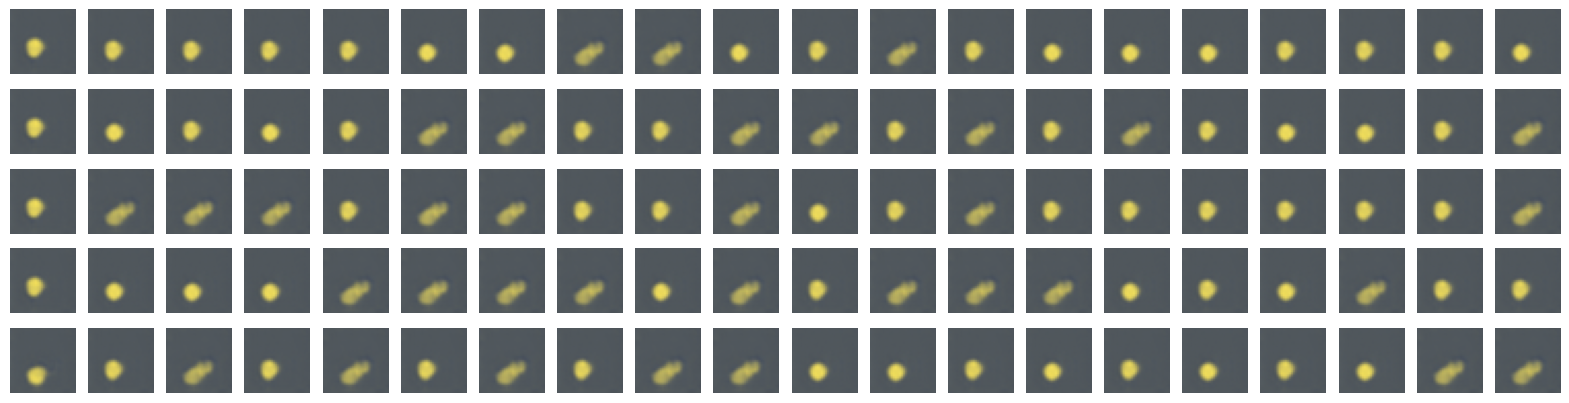

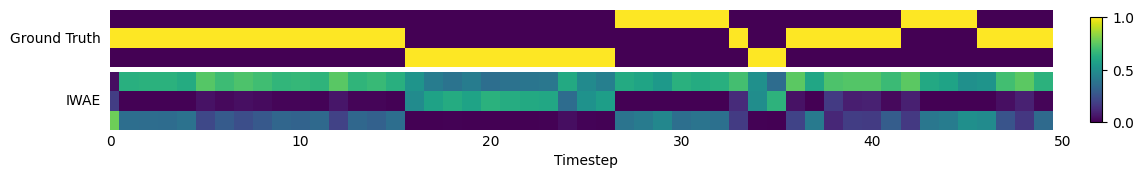

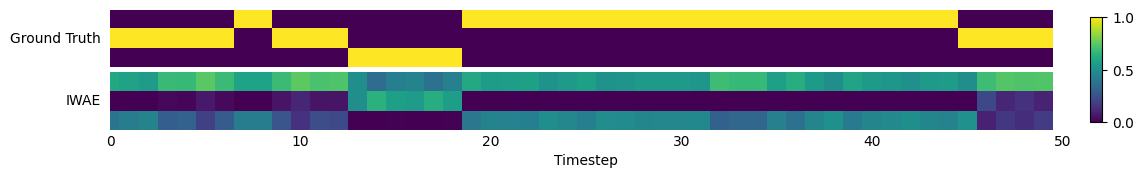

MSE: 0.00146
Pred MSE: 0.01088
Epoch: [1][200/1250]	Time 1.008	Loss -616422.6875	 
Epoch: [1][400/1250]	Time 2.007	Loss -668514.6875	 
Epoch: [1][600/1250]	Time 1.028	Loss -663591.5625	 
Epoch: [1][800/1250]	Time 2.014	Loss -649995.4375	 
Epoch: [1][1000/1250]	Time 1.072	Loss -718295.6250	 
Epoch: [1][1200/1250]	Time 1.426	Loss -681677.8750	 
MSE: 0.00103
Pred MSE: 0.01186
Epoch: [2][200/1250]	Time 1.961	Loss -707895.1250	 
Epoch: [2][400/1250]	Time 1.114	Loss -709668.5000	 
Epoch: [2][600/1250]	Time 1.000	Loss -730402.3125	 
Epoch: [2][800/1250]	Time 1.016	Loss -727944.5625	 
Epoch: [2][1000/1250]	Time 1.234	Loss -674078.0000	 
Epoch: [2][1200/1250]	Time 1.153	Loss -729332.4375	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
1.6155943670880255


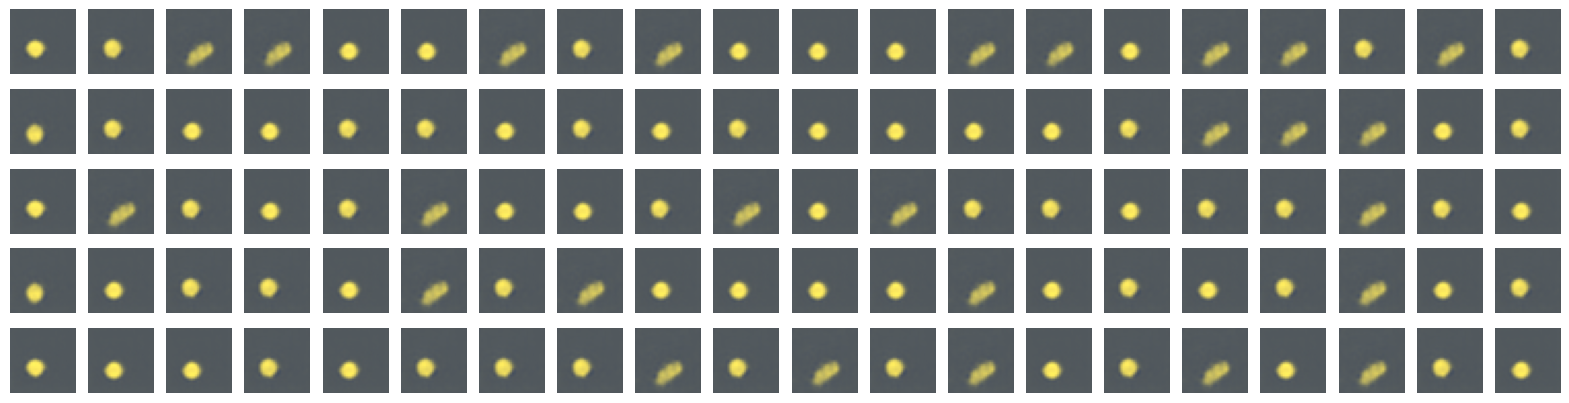

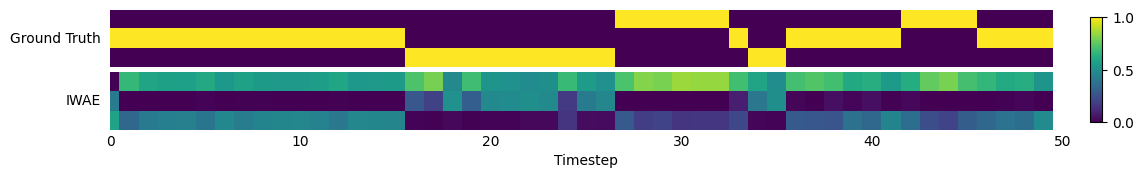

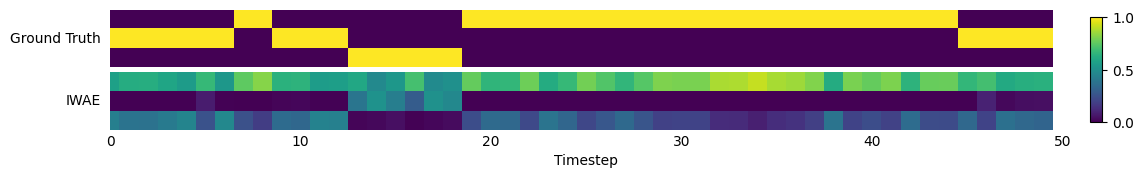

MSE: 0.00092
Pred MSE: 0.01233
Epoch: [3][200/1250]	Time 1.265	Loss -708599.4375	 
Epoch: [3][400/1250]	Time 1.498	Loss -659720.1250	 
Epoch: [3][600/1250]	Time 1.061	Loss -666418.8750	 
Epoch: [3][800/1250]	Time 1.437	Loss -735531.7500	 
Epoch: [3][1000/1250]	Time 0.958	Loss -705742.5000	 
Epoch: [3][1200/1250]	Time 1.155	Loss -704693.0625	 
MSE: 0.00080
Pred MSE: 0.01202
Epoch: [4][200/1250]	Time 1.125	Loss -735356.5625	 
Epoch: [4][400/1250]	Time 1.072	Loss -768964.4375	 
Epoch: [4][600/1250]	Time 1.110	Loss -729485.8125	 
Epoch: [4][800/1250]	Time 1.979	Loss -738393.8750	 
Epoch: [4][1000/1250]	Time 1.368	Loss -749995.0625	 
Epoch: [4][1200/1250]	Time 0.959	Loss -752322.6875	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
1


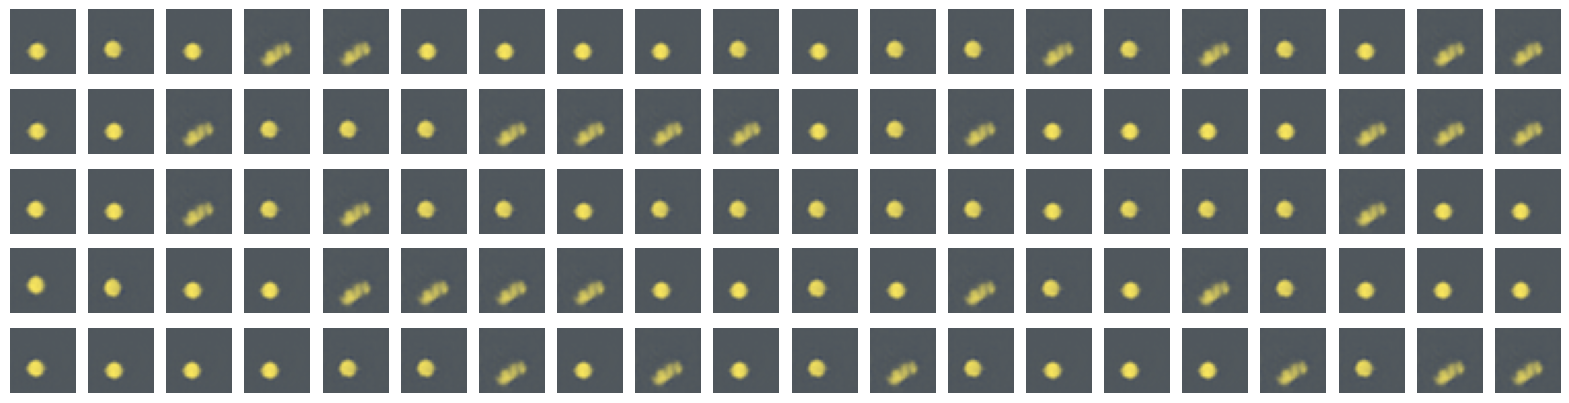

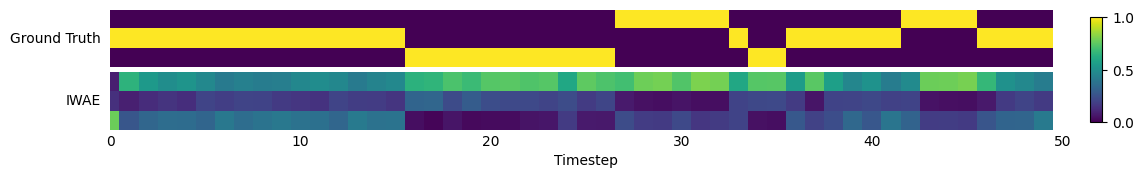

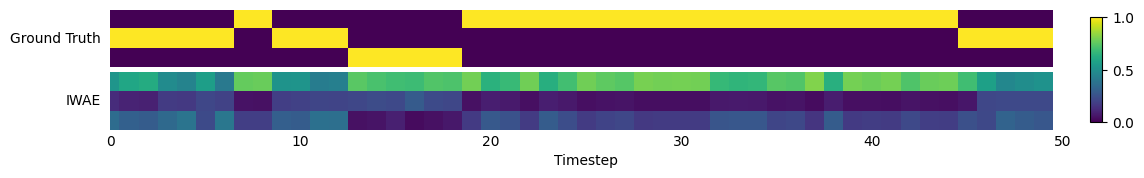

MSE: 0.00069
Pred MSE: 0.01141
Epoch: [5][200/1250]	Time 1.171	Loss -717148.6875	 
Epoch: [5][400/1250]	Time 1.439	Loss -645407.9375	 
Epoch: [5][600/1250]	Time 1.265	Loss -752054.9375	 
Epoch: [5][800/1250]	Time 1.978	Loss -706606.0625	 
Epoch: [5][1000/1250]	Time 1.059	Loss -688230.2500	 
Epoch: [5][1200/1250]	Time 1.431	Loss -719796.3125	 
MSE: 0.00088
Pred MSE: 0.01151
Epoch: [6][200/1250]	Time 0.963	Loss -725081.0000	 
Epoch: [6][400/1250]	Time 1.940	Loss -750394.4375	 
Epoch: [6][600/1250]	Time 1.158	Loss -740132.1875	 
Epoch: [6][800/1250]	Time 1.425	Loss -774395.5625	 
Epoch: [6][1000/1250]	Time 2.734	Loss -751457.9375	 
Epoch: [6][1200/1250]	Time 1.981	Loss -712080.6250	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
1


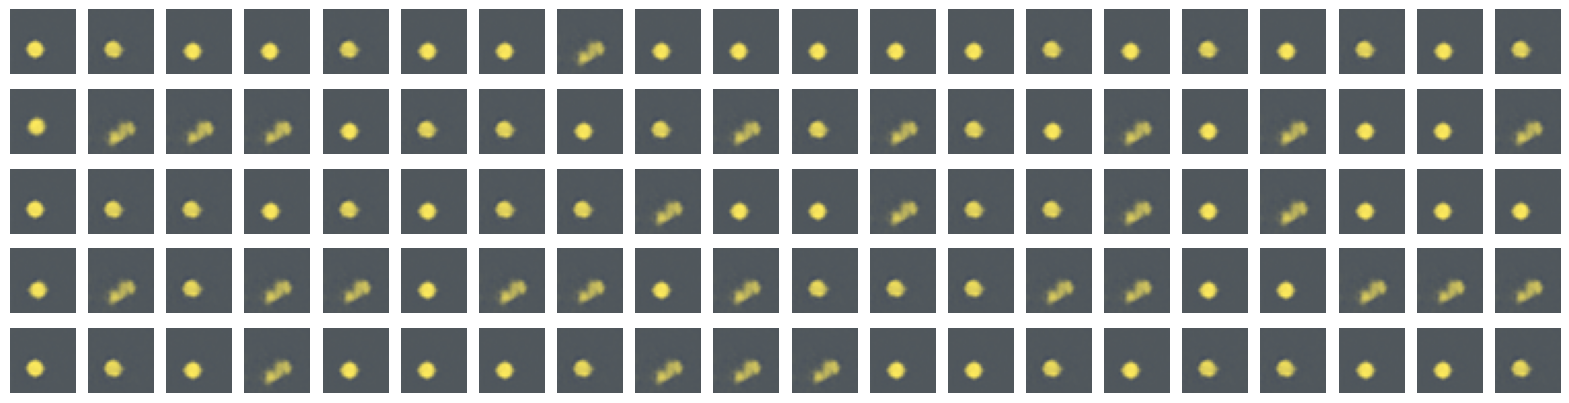

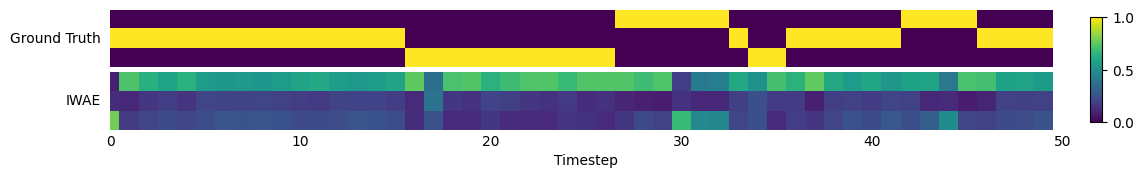

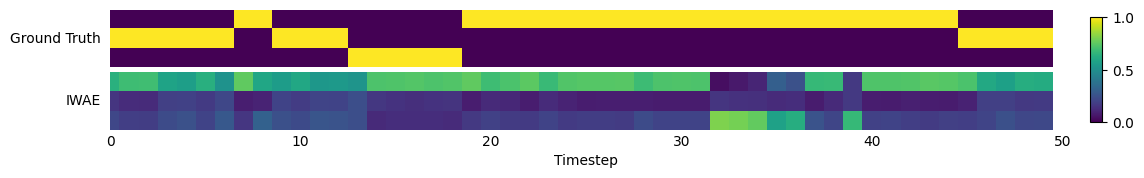

MSE: 0.00077
Pred MSE: 0.01147
Epoch: [7][200/1250]	Time 0.955	Loss -720255.8750	 
Epoch: [7][400/1250]	Time 1.028	Loss -757052.3750	 
Epoch: [7][600/1250]	Time 1.119	Loss -782288.9375	 
Epoch: [7][800/1250]	Time 0.955	Loss -784764.6875	 
Epoch: [7][1000/1250]	Time 1.770	Loss -806615.3125	 
Epoch: [7][1200/1250]	Time 1.926	Loss -738696.1250	 
MSE: 0.00098
Pred MSE: 0.01162
Epoch: [8][200/1250]	Time 1.119	Loss -782263.8750	 
Epoch: [8][400/1250]	Time 1.013	Loss -811228.9375	 
Epoch: [8][600/1250]	Time 1.157	Loss -805321.4375	 
Epoch: [8][800/1250]	Time 0.949	Loss -689978.1875	 
Epoch: [8][1000/1250]	Time 1.077	Loss -759708.0000	 
Epoch: [8][1200/1250]	Time 2.279	Loss -794017.5000	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
1


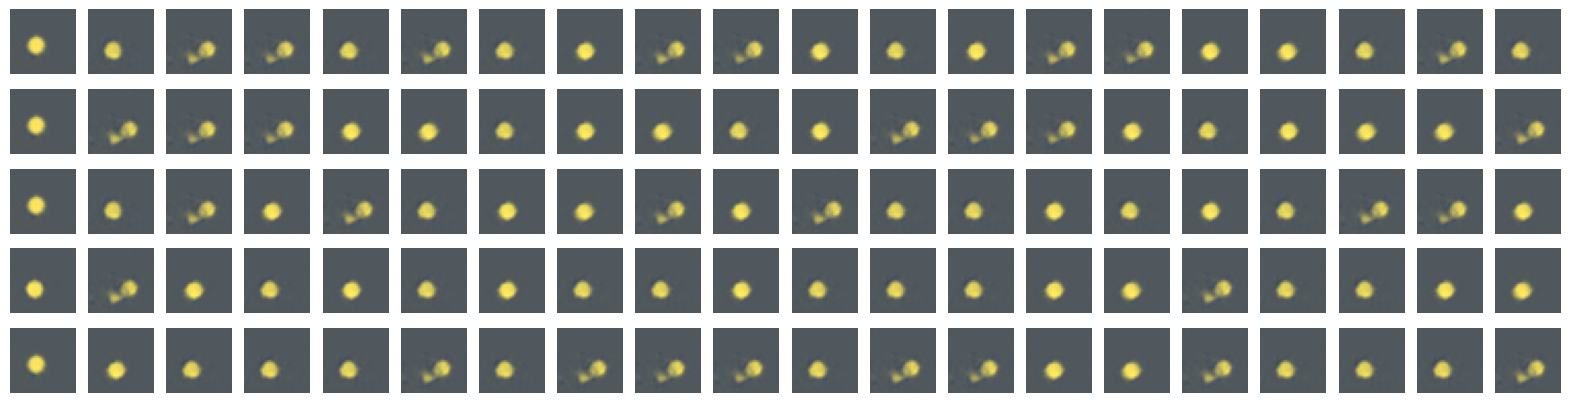

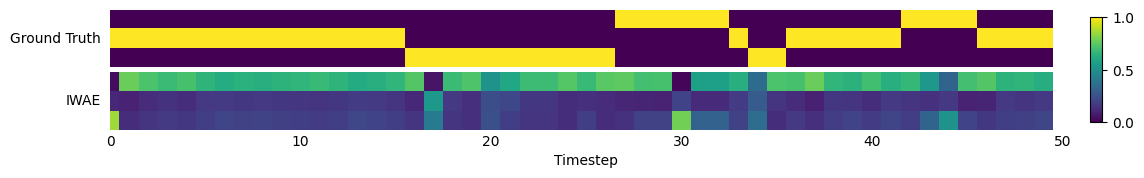

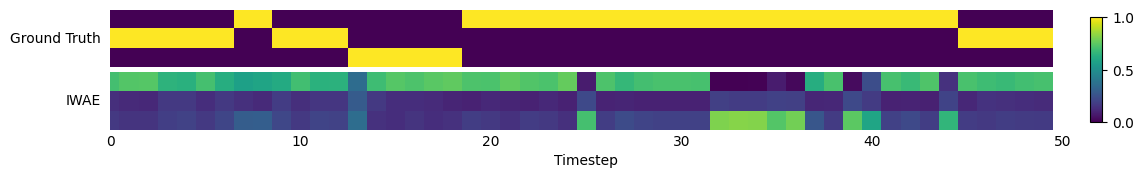

MSE: 0.00073
Pred MSE: 0.01176
Epoch: [9][200/1250]	Time 2.535	Loss -729615.5000	 
Epoch: [9][400/1250]	Time 1.236	Loss -789605.6250	 
Epoch: [9][600/1250]	Time 1.377	Loss -785449.4375	 
Epoch: [9][800/1250]	Time 1.346	Loss -789295.1875	 
Epoch: [9][1000/1250]	Time 2.086	Loss -766646.6875	 
Epoch: [9][1200/1250]	Time 1.099	Loss -672652.5000	 
MSE: 0.00103
Pred MSE: 0.01136
Epoch: [10][200/1250]	Time 1.288	Loss -720618.4375	 
Epoch: [10][400/1250]	Time 1.136	Loss -703086.0625	 
Epoch: [10][600/1250]	Time 0.990	Loss -712949.1875	 
Epoch: [10][800/1250]	Time 2.100	Loss -780866.4375	 
Epoch: [10][1000/1250]	Time 0.994	Loss -749326.6875	 
Epoch: [10][1200/1250]	Time 1.459	Loss -792616.3125	 
tensor([[0.6033, 0.1994, 0.1972],
        [0.5557, 0.2218, 0.2225],
        [0.5475, 0.2226, 0.2299]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2038, 0.4401, 0.3561], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


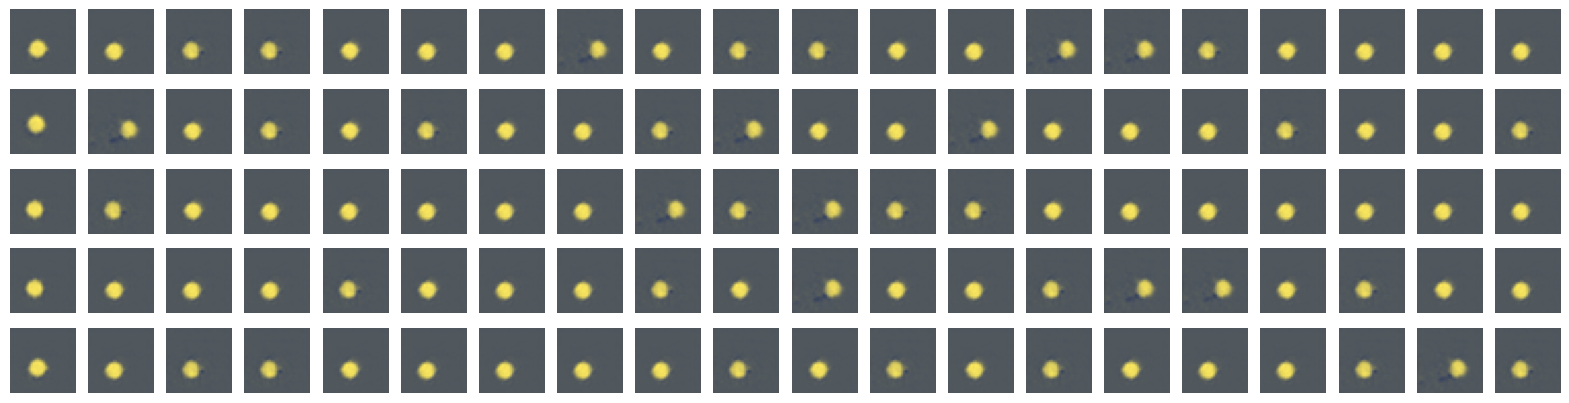

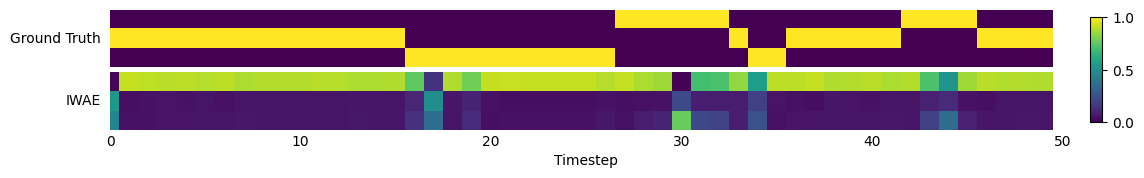

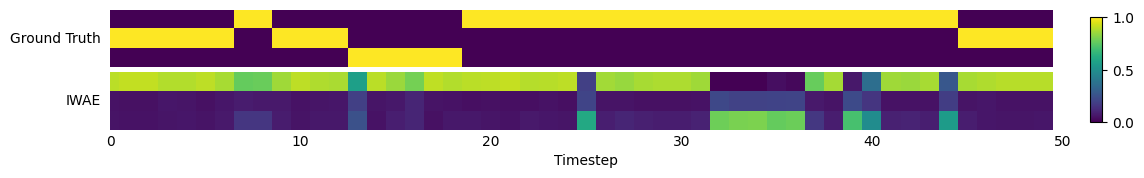

MSE: 0.00069
Pred MSE: 0.01186
Epoch: [11][200/1250]	Time 1.459	Loss -763997.1875	 
Epoch: [11][400/1250]	Time 1.918	Loss -793063.5625	 
Epoch: [11][600/1250]	Time 1.444	Loss -790305.8125	 
Epoch: [11][800/1250]	Time 1.368	Loss -770293.8125	 
Epoch: [11][1000/1250]	Time 1.460	Loss -783068.6875	 
Epoch: [11][1200/1250]	Time 1.346	Loss -728765.5625	 
MSE: 0.00076
Pred MSE: 0.01181
Epoch: [12][200/1250]	Time 1.037	Loss -773341.6875	 
Epoch: [12][400/1250]	Time 1.449	Loss -758709.3125	 
Epoch: [12][600/1250]	Time 1.971	Loss -732093.9375	 
Epoch: [12][800/1250]	Time 1.720	Loss -731212.9375	 
Epoch: [12][1000/1250]	Time 1.593	Loss -720343.5625	 
Epoch: [12][1200/1250]	Time 1.223	Loss -739524.3125	 
tensor([[0.8803, 0.0587, 0.0610],
        [0.7255, 0.1227, 0.1519],
        [0.6545, 0.1227, 0.2228]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0943, 0.4849, 0.4208], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


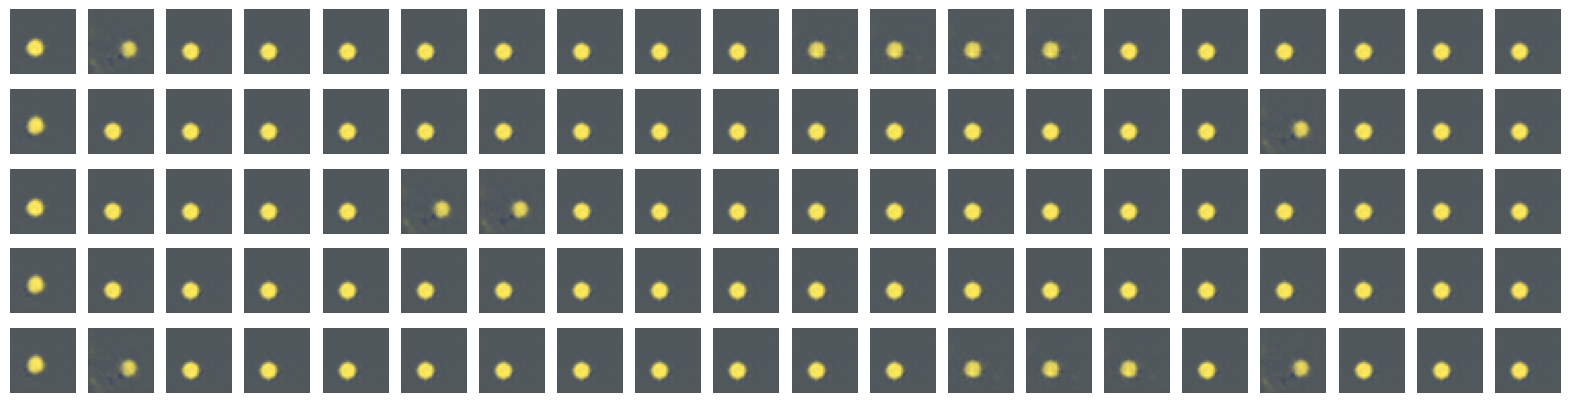

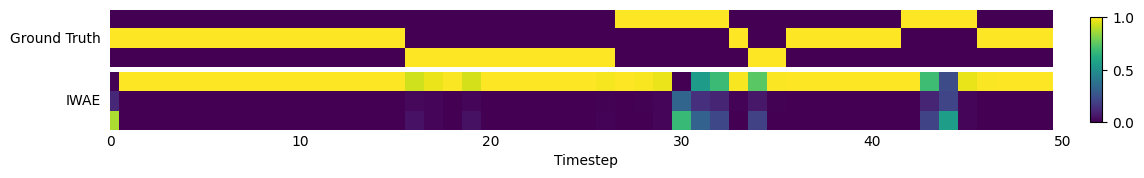

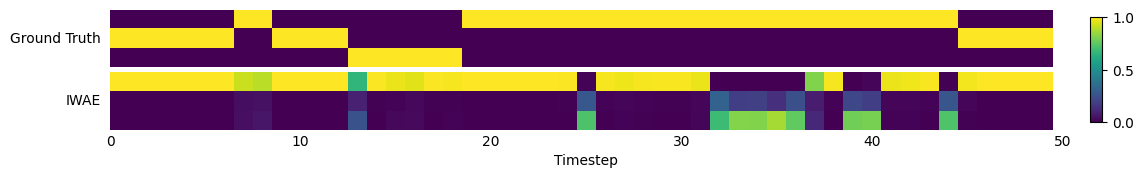

MSE: 0.00100
Pred MSE: 0.01196
Epoch: [13][200/1250]	Time 1.914	Loss -758453.3125	 
Epoch: [13][400/1250]	Time 1.430	Loss -769883.6875	 
Epoch: [13][600/1250]	Time 1.486	Loss -805446.5000	 
Epoch: [13][800/1250]	Time 1.336	Loss -756965.6250	 
Epoch: [13][1000/1250]	Time 0.977	Loss -778222.0000	 
Epoch: [13][1200/1250]	Time 1.478	Loss -790942.3125	 
MSE: 0.00065
Pred MSE: 0.01186
Epoch: [14][200/1250]	Time 1.947	Loss -786790.7500	 
Epoch: [14][400/1250]	Time 1.926	Loss -726829.5625	 
Epoch: [14][600/1250]	Time 1.413	Loss -700755.0625	 
Epoch: [14][800/1250]	Time 2.684	Loss -783118.3750	 
Epoch: [14][1000/1250]	Time 1.082	Loss -737941.5625	 
Epoch: [14][1200/1250]	Time 1.028	Loss -814041.3125	 
tensor([[0.9325, 0.0257, 0.0417],
        [0.7639, 0.0754, 0.1607],
        [0.5555, 0.0688, 0.3757]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0509, 0.5012, 0.4479], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


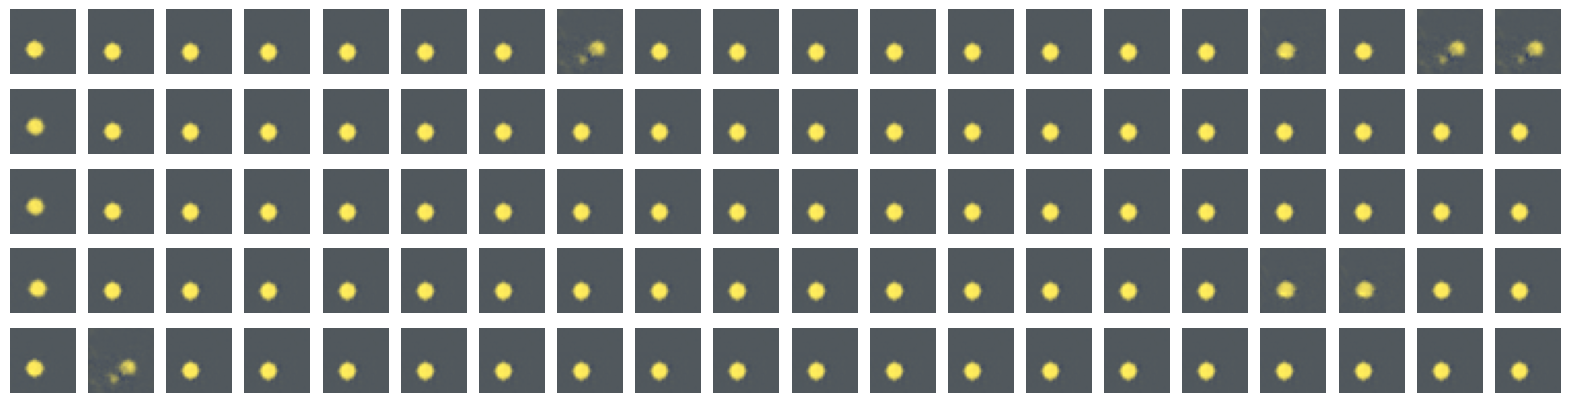

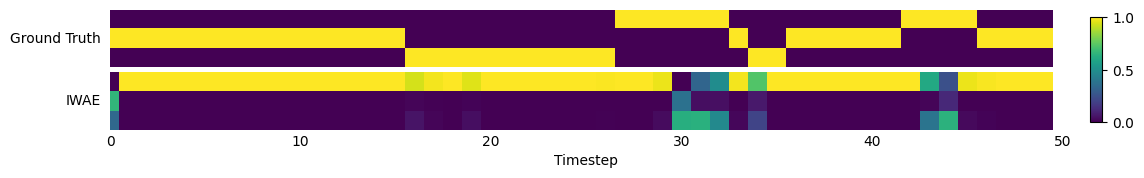

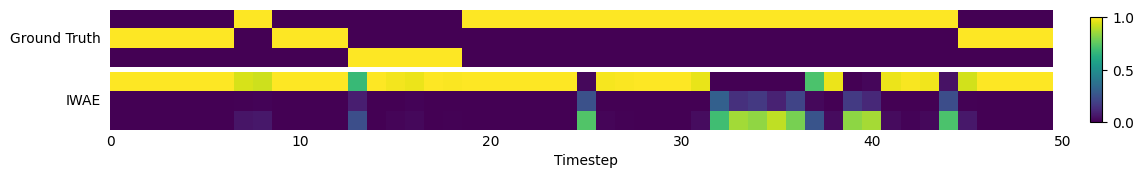

MSE: 0.00071
Pred MSE: 0.01238
Epoch: [15][200/1250]	Time 1.515	Loss -795945.4375	 
Epoch: [15][400/1250]	Time 2.102	Loss -725302.0000	 
Epoch: [15][600/1250]	Time 1.117	Loss -755187.5625	 
Epoch: [15][800/1250]	Time 1.979	Loss -740597.8750	 
Epoch: [15][1000/1250]	Time 1.858	Loss -781472.5000	 
Epoch: [15][1200/1250]	Time 1.451	Loss -820340.1875	 
MSE: 0.00063
Pred MSE: 0.01209
Epoch: [16][200/1250]	Time 2.343	Loss -786695.8750	 
Epoch: [16][400/1250]	Time 1.004	Loss -796075.9375	 
Epoch: [16][600/1250]	Time 2.016	Loss -766118.0625	 
Epoch: [16][800/1250]	Time 0.986	Loss -807485.8125	 
Epoch: [16][1000/1250]	Time 2.013	Loss -785429.1875	 
Epoch: [16][1200/1250]	Time 1.407	Loss -772597.9375	 
tensor([[0.9308, 0.0144, 0.0548],
        [0.8195, 0.0487, 0.1318],
        [0.4917, 0.0331, 0.4751]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0282, 0.4616, 0.5102], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


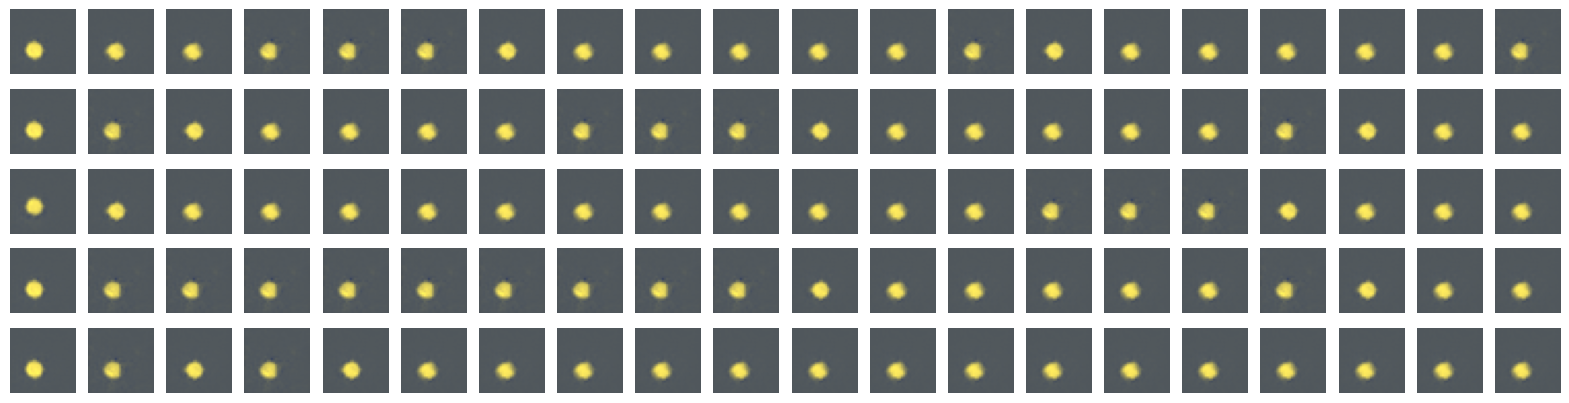

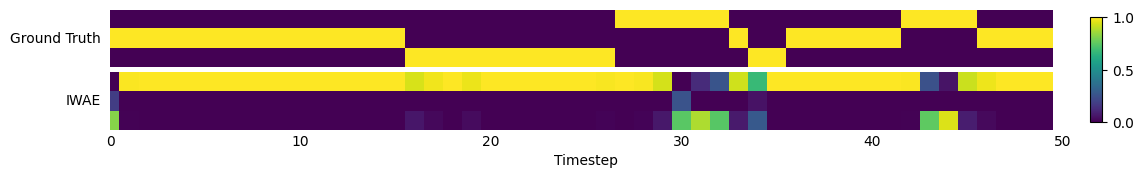

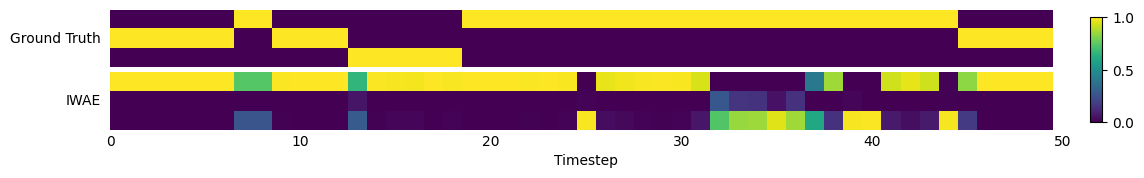

MSE: 0.00090
Pred MSE: 0.01171
Epoch: [17][200/1250]	Time 2.170	Loss -762468.5625	 
Epoch: [17][400/1250]	Time 1.234	Loss -738079.1875	 
Epoch: [17][600/1250]	Time 1.009	Loss -740836.8125	 
Epoch: [17][800/1250]	Time 1.976	Loss -764954.6875	 
Epoch: [17][1000/1250]	Time 1.505	Loss -792679.9375	 
Epoch: [17][1200/1250]	Time 2.259	Loss -789311.3750	 
MSE: 0.00091
Pred MSE: 0.01201
Epoch: [18][200/1250]	Time 1.122	Loss -759856.3125	 
Epoch: [18][400/1250]	Time 0.921	Loss -783891.5000	 
Epoch: [18][600/1250]	Time 1.859	Loss -732652.0625	 
Epoch: [18][800/1250]	Time 1.888	Loss -716457.0625	 
Epoch: [18][1000/1250]	Time 1.395	Loss -777966.2500	 
Epoch: [18][1200/1250]	Time 1.154	Loss -758538.2500	 
tensor([[0.8942, 0.0117, 0.0941],
        [0.7907, 0.0660, 0.1434],
        [0.4450, 0.0258, 0.5293]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0177, 0.5981, 0.3841], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


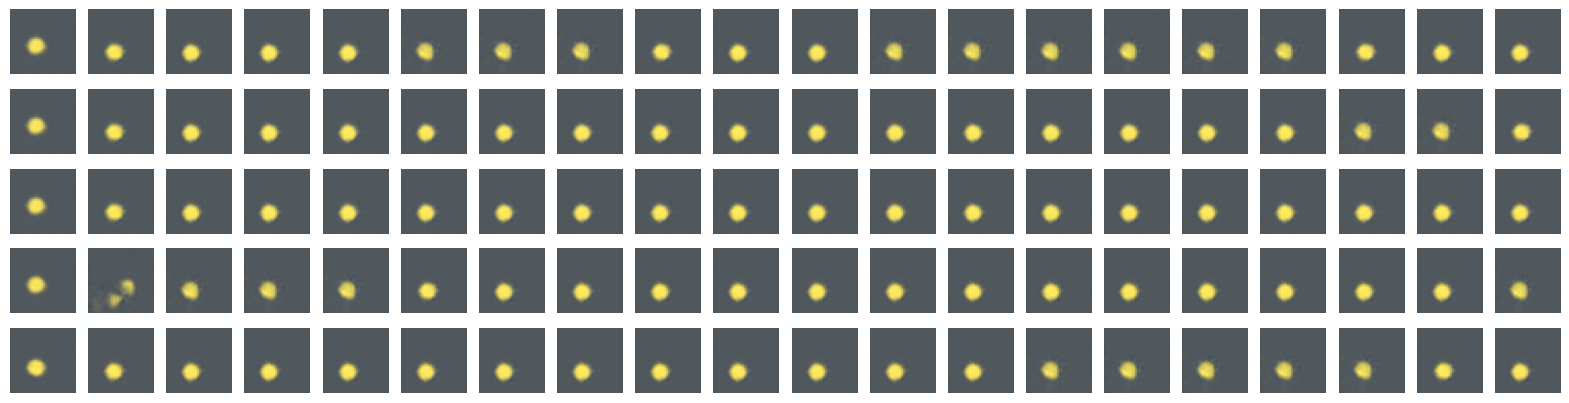

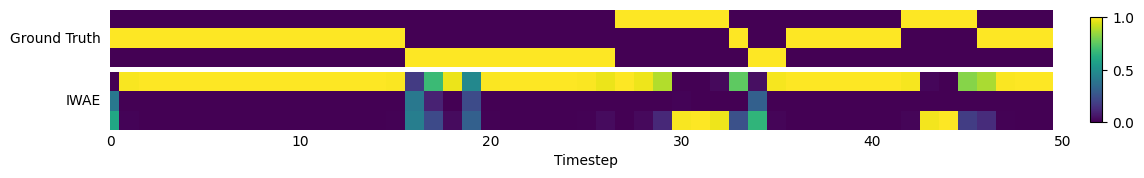

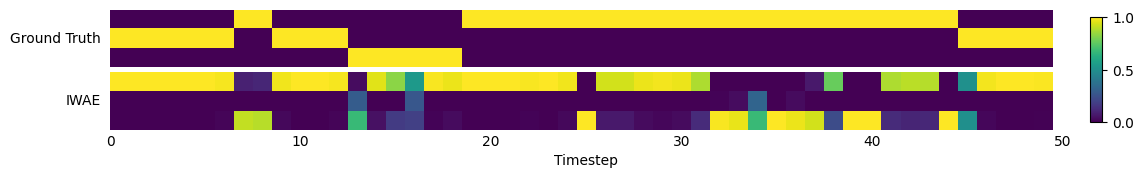

MSE: 0.00066
Pred MSE: 0.01185
Epoch: [19][200/1250]	Time 2.098	Loss -762399.6875	 
Epoch: [19][400/1250]	Time 1.302	Loss -754343.5625	 
Epoch: [19][600/1250]	Time 1.963	Loss -764900.8125	 
Epoch: [19][800/1250]	Time 1.957	Loss -772619.3750	 
Epoch: [19][1000/1250]	Time 2.166	Loss -777367.6875	 
Epoch: [19][1200/1250]	Time 1.269	Loss -739276.8125	 
MSE: 0.00085
Pred MSE: 0.01183


In [15]:
iwae_losses, test_mse_iwae, pred_mse_iwae = train_iwae(N, model, optimizer,num_states, dim_latent, T)

Epoch: [0][200/1250]	Time 0.850	Loss -105476.5547	 
Epoch: [0][400/1250]	Time 0.875	Loss -363446.2500	 
Epoch: [0][600/1250]	Time 0.912	Loss -426986.2500	 
Epoch: [0][800/1250]	Time 0.882	Loss -559393.0000	 
Epoch: [0][1000/1250]	Time 0.879	Loss -604608.1875	 
Epoch: [0][1200/1250]	Time 0.930	Loss -776191.4375	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5.729299760082821


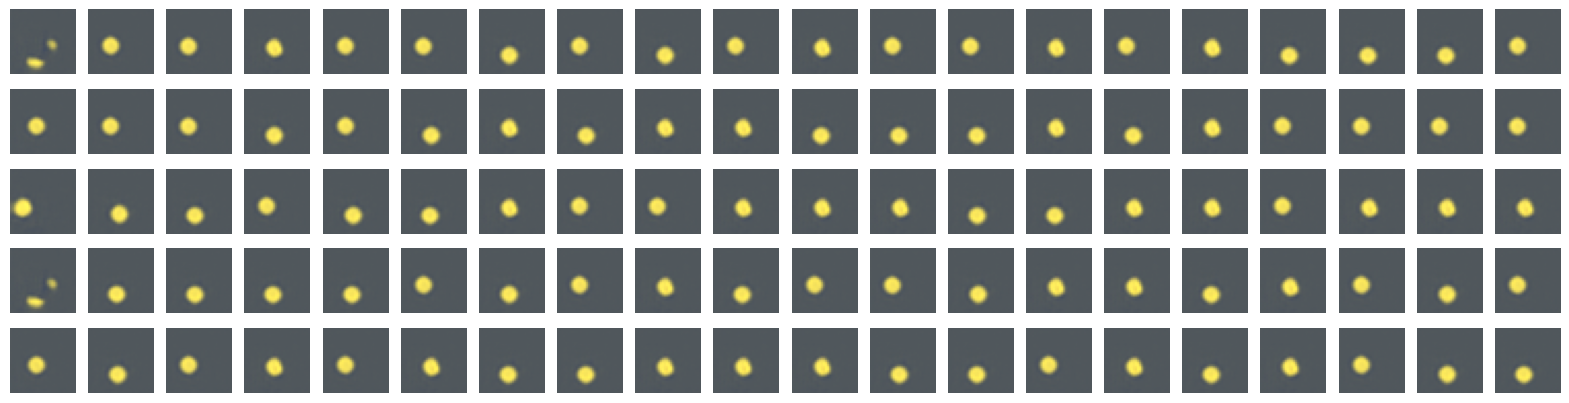

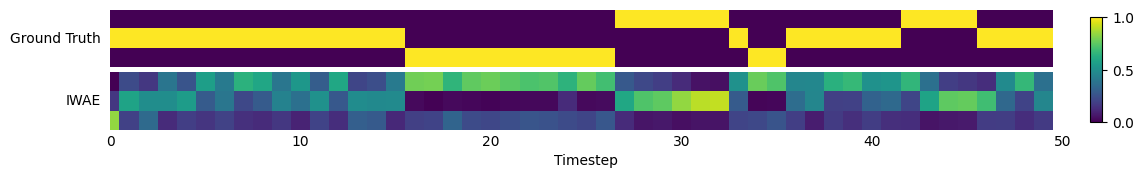

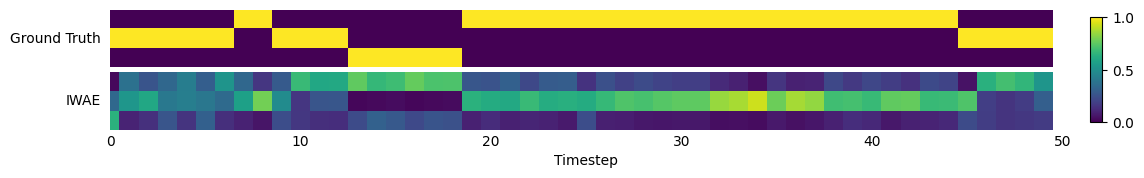

MSE: 0.00064
Pred MSE: 0.01441
Epoch: [1][200/1250]	Time 0.877	Loss -836179.6250	 
Epoch: [1][400/1250]	Time 0.875	Loss -837819.0625	 
Epoch: [1][600/1250]	Time 0.871	Loss -858010.6250	 
Epoch: [1][800/1250]	Time 0.923	Loss -863501.3750	 
Epoch: [1][1000/1250]	Time 0.895	Loss -867642.8125	 
Epoch: [1][1200/1250]	Time 0.879	Loss -870056.6875	 
MSE: 0.00027
Pred MSE: 0.01432
Epoch: [2][200/1250]	Time 0.882	Loss -861846.9375	 
Epoch: [2][400/1250]	Time 0.870	Loss -818139.2500	 
Epoch: [2][600/1250]	Time 0.895	Loss -871152.1250	 
Epoch: [2][800/1250]	Time 0.876	Loss -861783.6875	 
Epoch: [2][1000/1250]	Time 0.893	Loss -870801.0000	 
Epoch: [2][1200/1250]	Time 0.906	Loss -872842.8125	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
1.6155943670880255


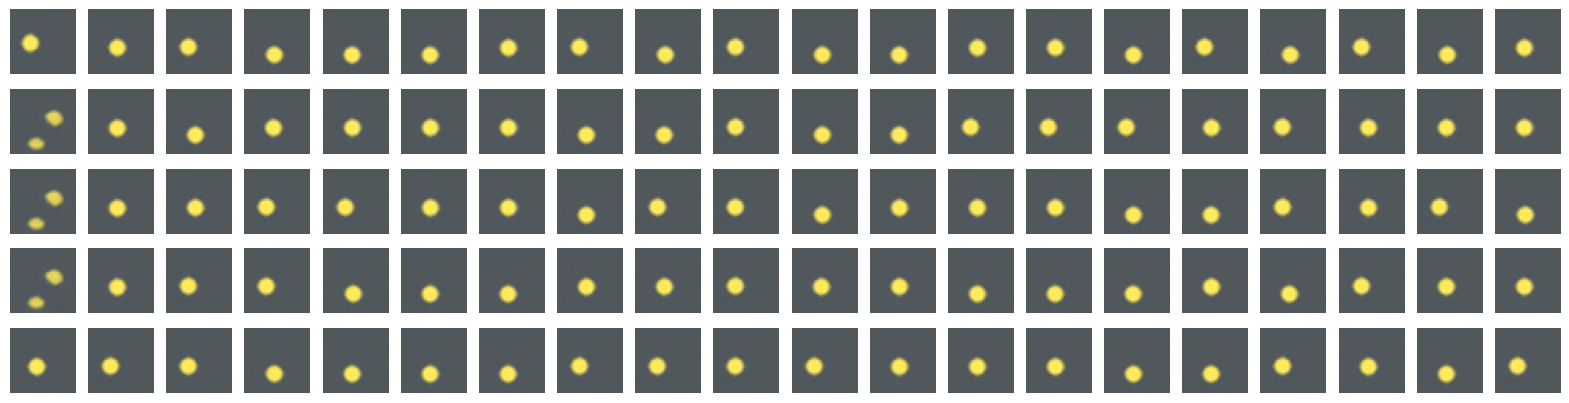

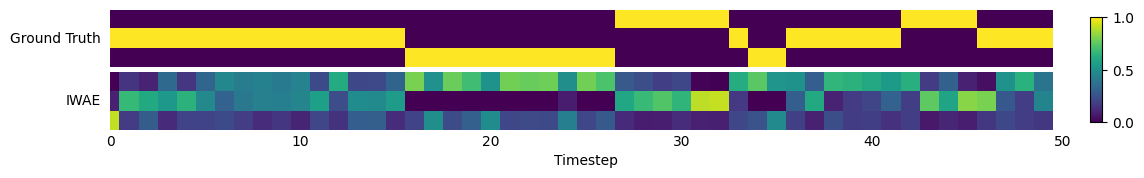

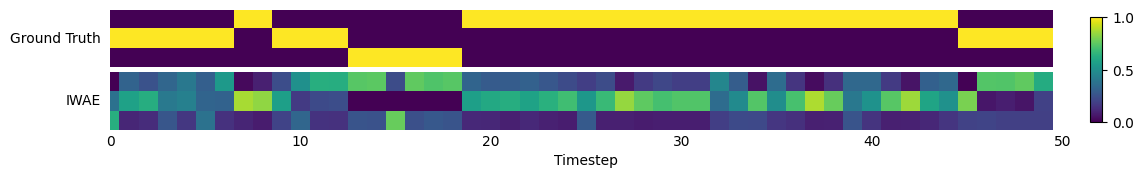

MSE: 0.00022
Pred MSE: 0.01448
Epoch: [3][200/1250]	Time 1.094	Loss -871966.7500	 
Epoch: [3][400/1250]	Time 2.393	Loss -866273.6875	 
Epoch: [3][600/1250]	Time 1.099	Loss -875301.9375	 
Epoch: [3][800/1250]	Time 1.051	Loss -874016.6875	 
Epoch: [3][1000/1250]	Time 0.947	Loss -853264.3750	 
Epoch: [3][1200/1250]	Time 1.437	Loss -869603.0625	 
MSE: 0.00018
Pred MSE: 0.01445
Epoch: [4][200/1250]	Time 1.563	Loss -879586.7500	 
Epoch: [4][400/1250]	Time 1.049	Loss -876494.8125	 
Epoch: [4][600/1250]	Time 1.523	Loss -876223.1875	 
Epoch: [4][800/1250]	Time 1.060	Loss -877727.8750	 
Epoch: [4][1000/1250]	Time 1.041	Loss -874430.9375	 
Epoch: [4][1200/1250]	Time 1.317	Loss -878711.8125	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
1


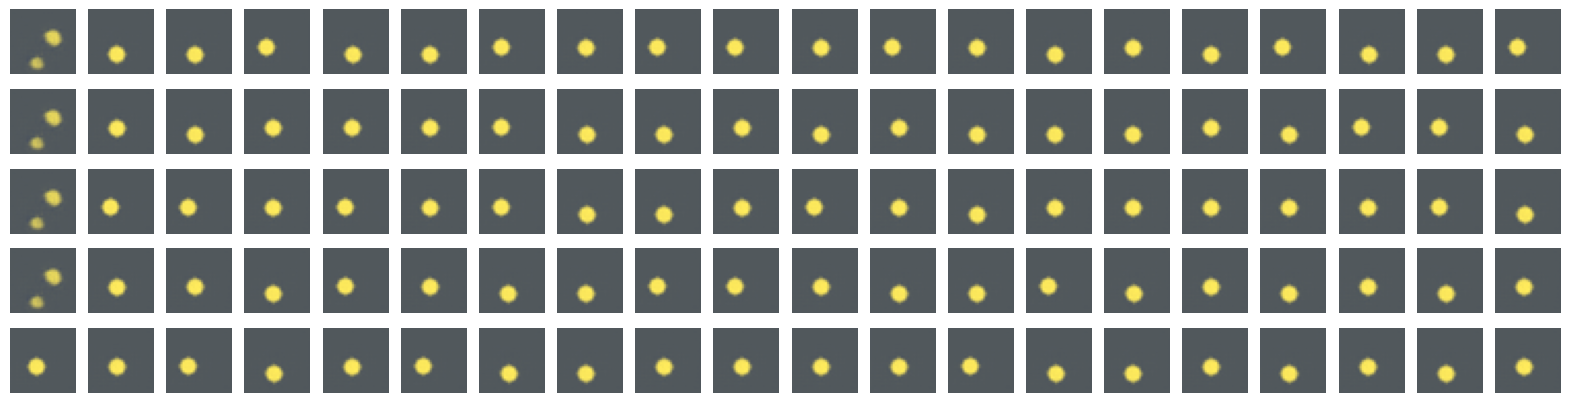

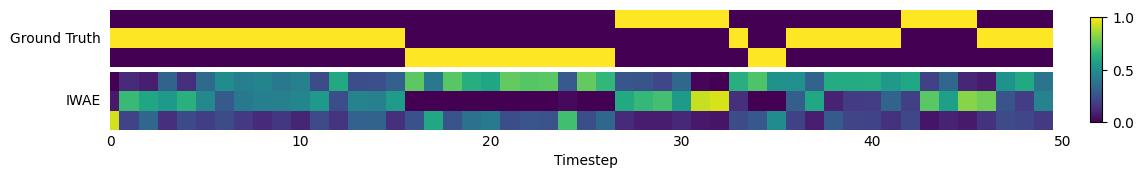

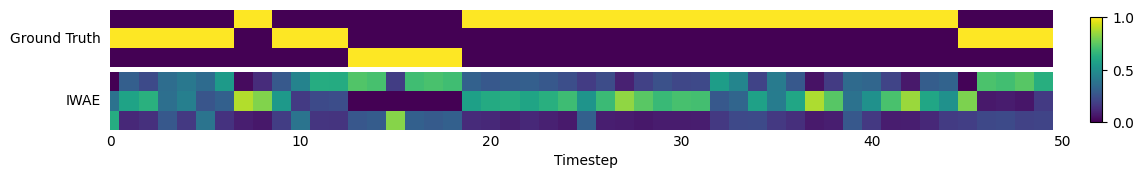

MSE: 0.00016
Pred MSE: 0.01415
Epoch: [5][200/1250]	Time 1.566	Loss -881208.5625	 
Epoch: [5][400/1250]	Time 1.015	Loss -874227.3750	 
Epoch: [5][600/1250]	Time 1.419	Loss -881184.9375	 
Epoch: [5][800/1250]	Time 0.926	Loss -874298.0625	 
Epoch: [5][1000/1250]	Time 1.003	Loss -876214.6875	 
Epoch: [5][1200/1250]	Time 1.025	Loss -877821.0625	 
MSE: 0.00016
Pred MSE: 0.01387
Epoch: [6][200/1250]	Time 1.288	Loss -879893.6875	 
Epoch: [6][400/1250]	Time 1.300	Loss -880033.1875	 
Epoch: [6][600/1250]	Time 1.383	Loss -875592.1875	 
Epoch: [6][800/1250]	Time 1.392	Loss -864600.7500	 
Epoch: [6][1000/1250]	Time 1.074	Loss -881447.7500	 
Epoch: [6][1200/1250]	Time 1.086	Loss -877169.1250	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
1


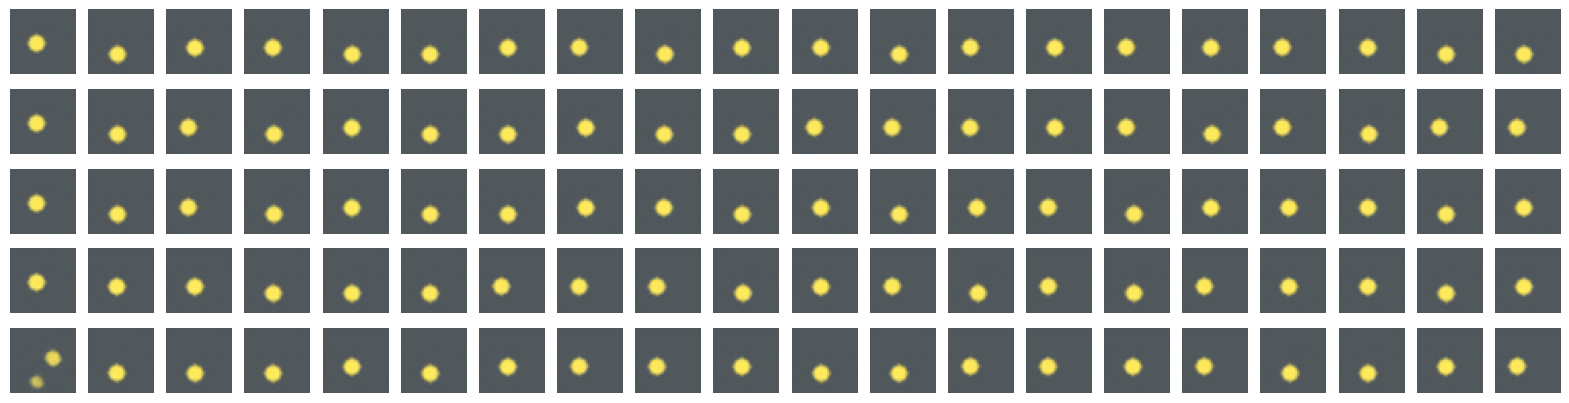

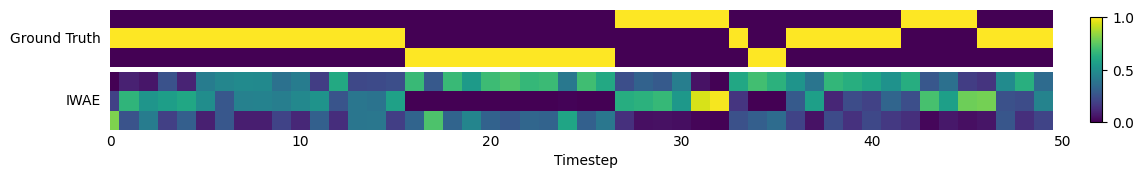

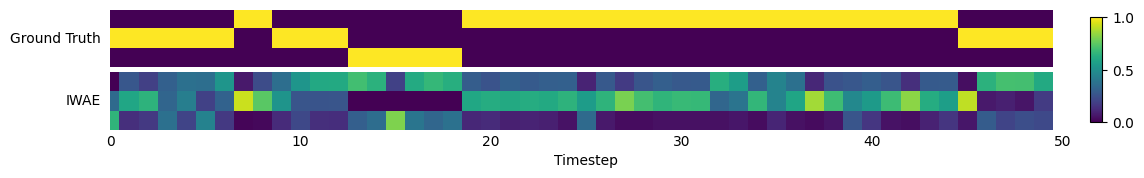

MSE: 0.00014
Pred MSE: 0.01403
Epoch: [7][200/1250]	Time 1.419	Loss -880551.6875	 
Epoch: [7][400/1250]	Time 0.931	Loss -881461.9375	 
Epoch: [7][600/1250]	Time 1.003	Loss -882023.8750	 
Epoch: [7][800/1250]	Time 1.110	Loss -874203.1875	 
Epoch: [7][1000/1250]	Time 0.979	Loss -880344.6875	 
Epoch: [7][1200/1250]	Time 1.482	Loss -876554.8125	 
MSE: 0.00017
Pred MSE: 0.01407
Epoch: [8][200/1250]	Time 0.934	Loss -881582.3750	 
Epoch: [8][400/1250]	Time 0.972	Loss -881805.6875	 
Epoch: [8][600/1250]	Time 1.237	Loss -880355.2500	 
Epoch: [8][800/1250]	Time 1.169	Loss -875647.9375	 
Epoch: [8][1000/1250]	Time 1.102	Loss -877115.3125	 
Epoch: [8][1200/1250]	Time 1.120	Loss -879675.6875	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
1


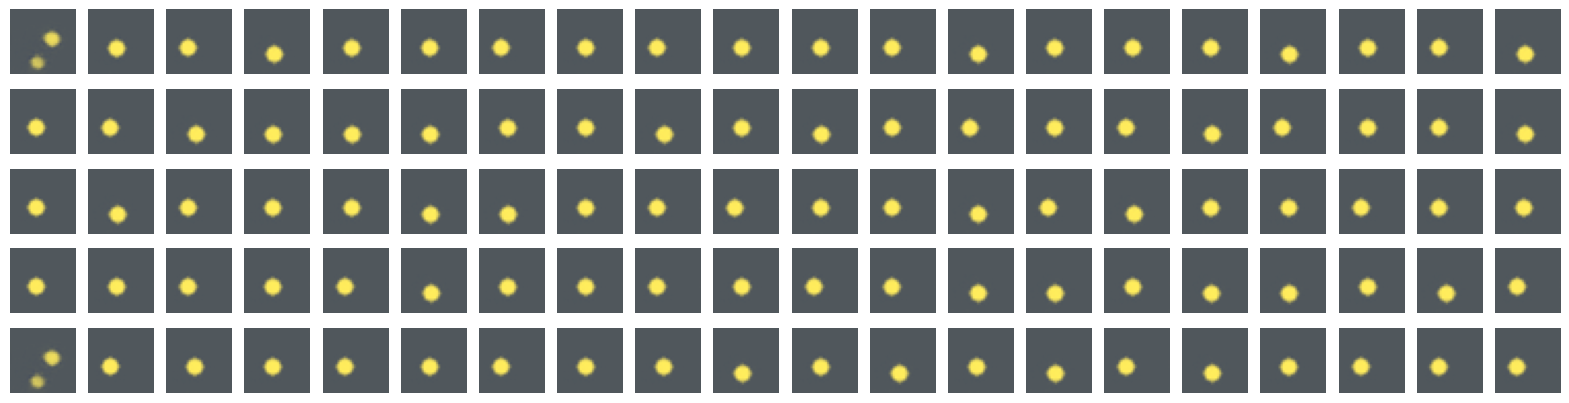

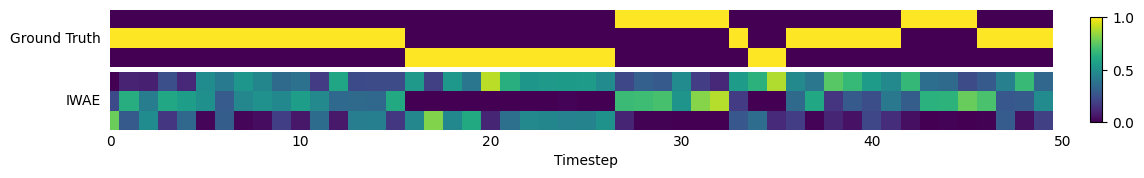

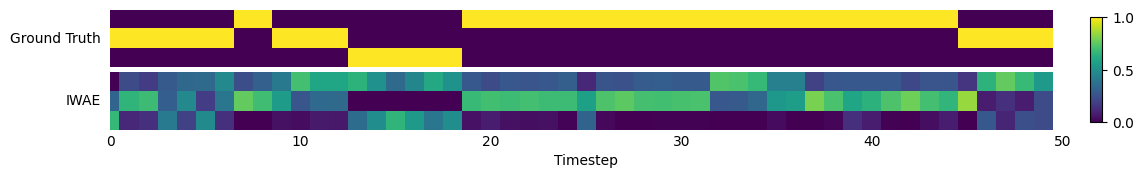

MSE: 0.00014
Pred MSE: 0.01433
Epoch: [9][200/1250]	Time 1.180	Loss -882246.8750	 
Epoch: [9][400/1250]	Time 0.992	Loss -879507.6875	 
Epoch: [9][600/1250]	Time 0.961	Loss -879703.1875	 
Epoch: [9][800/1250]	Time 1.121	Loss -882725.1250	 
Epoch: [9][1000/1250]	Time 0.955	Loss -879002.3750	 
Epoch: [9][1200/1250]	Time 0.929	Loss -881279.8125	 
MSE: 0.00014
Pred MSE: 0.01370
Epoch: [10][200/1250]	Time 1.130	Loss -881963.5000	 
Epoch: [10][400/1250]	Time 1.112	Loss -881822.1875	 
Epoch: [10][600/1250]	Time 1.560	Loss -881888.1875	 
Epoch: [10][800/1250]	Time 1.131	Loss -882482.0625	 
Epoch: [10][1000/1250]	Time 1.363	Loss -881367.2500	 
Epoch: [10][1200/1250]	Time 2.508	Loss -882836.3125	 
tensor([[0.5979, 0.2041, 0.1980],
        [0.1863, 0.6095, 0.2042],
        [0.4916, 0.2010, 0.3073]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2068, 0.2129, 0.5803], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


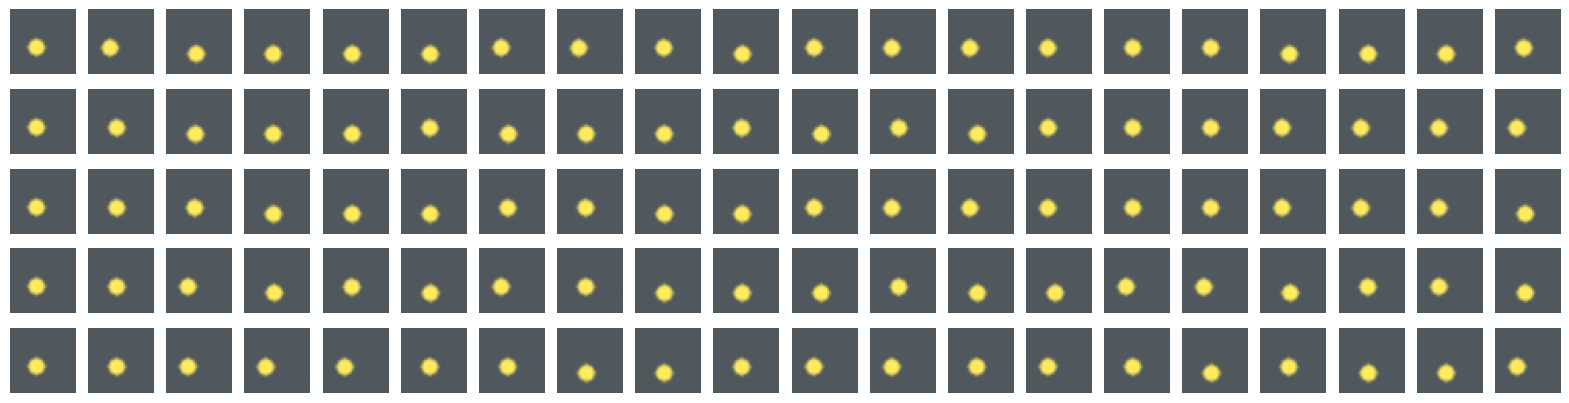

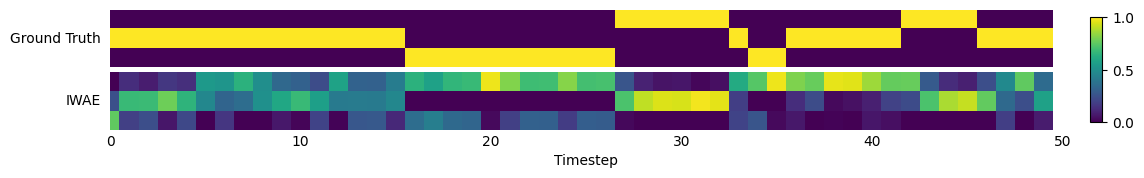

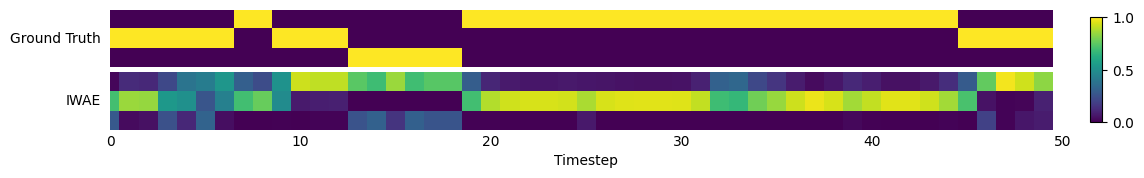

MSE: 0.00012
Pred MSE: 0.01411
Epoch: [11][200/1250]	Time 1.698	Loss -848514.1875	 
Epoch: [11][400/1250]	Time 1.154	Loss -878797.5625	 
Epoch: [11][600/1250]	Time 1.852	Loss -881480.0000	 
Epoch: [11][800/1250]	Time 1.192	Loss -881501.4375	 
Epoch: [11][1000/1250]	Time 1.014	Loss -877401.6250	 
Epoch: [11][1200/1250]	Time 2.527	Loss -881869.5000	 
MSE: 0.00016
Pred MSE: 0.01397
Epoch: [12][200/1250]	Time 2.105	Loss -883111.8125	 
Epoch: [12][400/1250]	Time 1.113	Loss -879093.8125	 
Epoch: [12][600/1250]	Time 2.057	Loss -879404.5000	 
Epoch: [12][800/1250]	Time 1.419	Loss -878799.3750	 
Epoch: [12][1000/1250]	Time 2.111	Loss -881085.4375	 
Epoch: [12][1200/1250]	Time 1.194	Loss -883165.8125	 
tensor([[0.8569, 0.0889, 0.0542],
        [0.0851, 0.8446, 0.0702],
        [0.6298, 0.1322, 0.2381]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0630, 0.0670, 0.8700], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


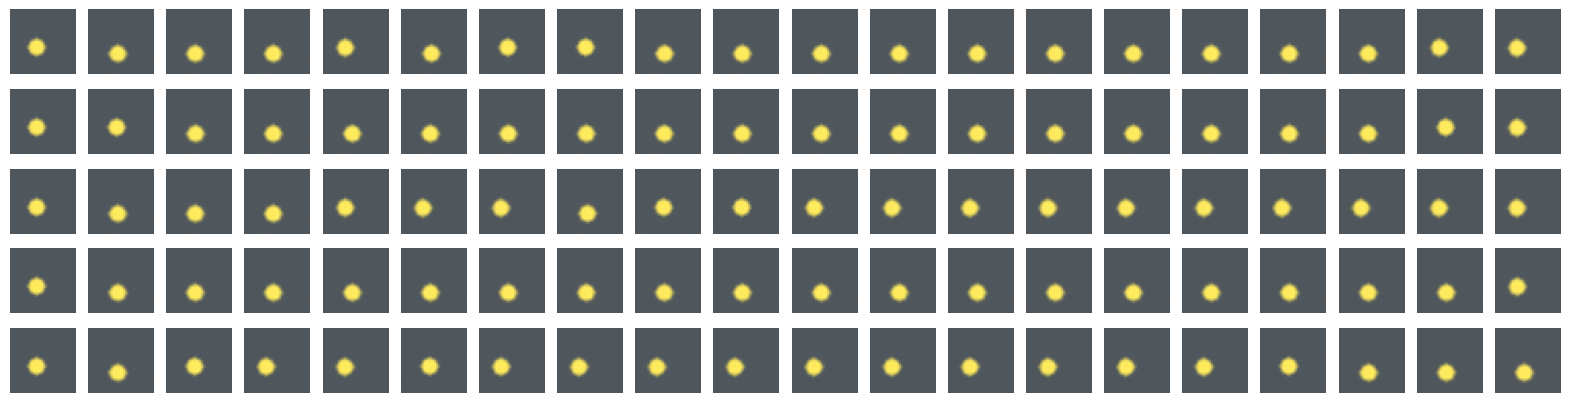

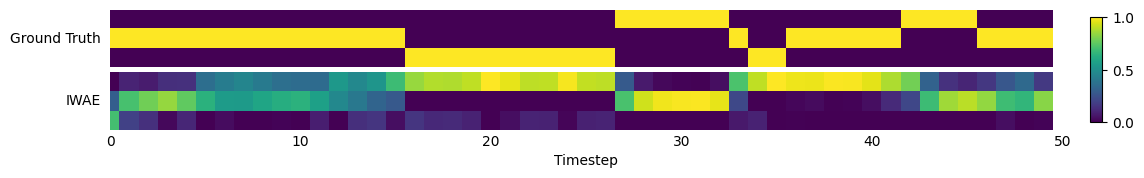

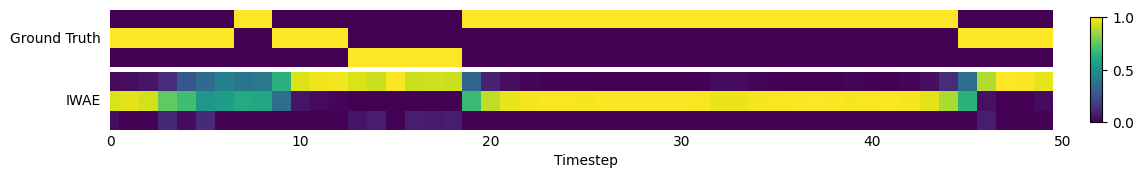

MSE: 0.00013
Pred MSE: 0.01401
Epoch: [13][200/1250]	Time 1.402	Loss -874152.0625	 
Epoch: [13][400/1250]	Time 1.459	Loss -881083.0625	 
Epoch: [13][600/1250]	Time 1.093	Loss -879173.8125	 
Epoch: [13][800/1250]	Time 1.030	Loss -881694.3125	 
Epoch: [13][1000/1250]	Time 2.063	Loss -882656.9375	 
Epoch: [13][1200/1250]	Time 2.665	Loss -882203.4375	 
MSE: 0.00024
Pred MSE: 0.01380
Epoch: [14][200/1250]	Time 2.015	Loss -881200.9375	 
Epoch: [14][400/1250]	Time 1.115	Loss -882177.3125	 
Epoch: [14][600/1250]	Time 2.193	Loss -883684.9375	 
Epoch: [14][800/1250]	Time 2.066	Loss -883027.3125	 
Epoch: [14][1000/1250]	Time 1.456	Loss -883116.3125	 
Epoch: [14][1200/1250]	Time 1.156	Loss -881746.3125	 
tensor([[0.8893, 0.0897, 0.0209],
        [0.1010, 0.8673, 0.0316],
        [0.5169, 0.1432, 0.3399]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0201, 0.0223, 0.9576], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


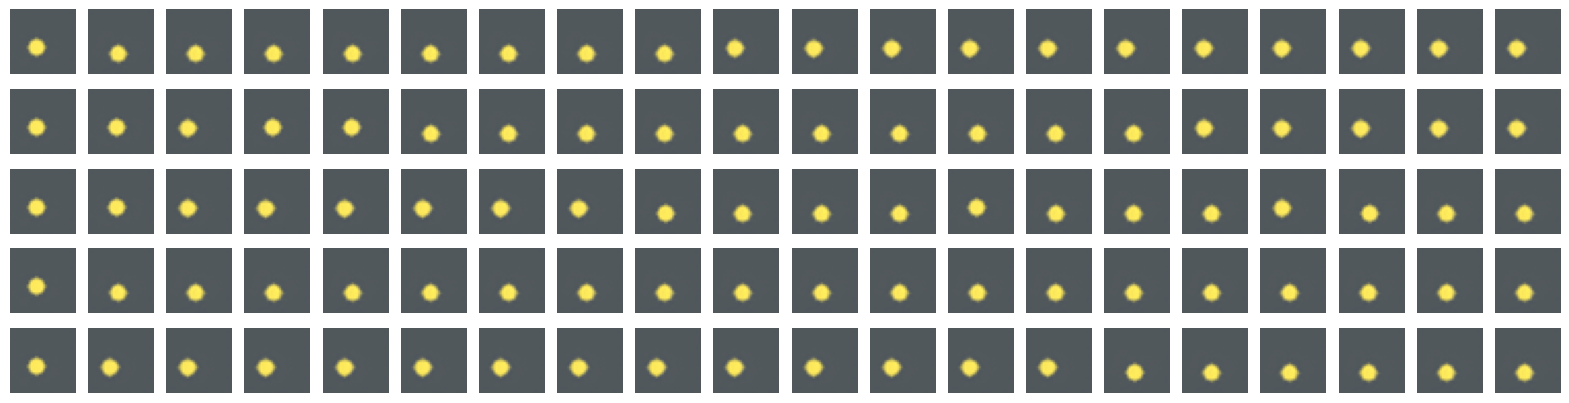

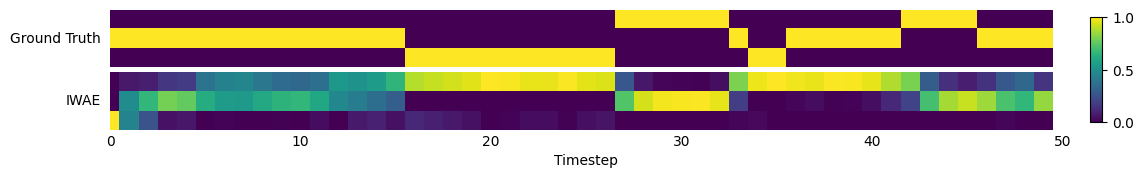

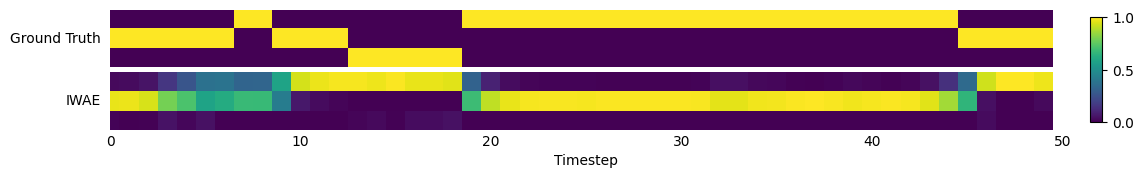

MSE: 0.00024
Pred MSE: 0.01377
Epoch: [15][200/1250]	Time 1.342	Loss -881238.3125	 
Epoch: [15][400/1250]	Time 1.234	Loss -882924.3750	 
Epoch: [15][600/1250]	Time 1.945	Loss -875536.0625	 
Epoch: [15][800/1250]	Time 1.478	Loss -882609.4375	 
Epoch: [15][1000/1250]	Time 1.259	Loss -882720.4375	 
Epoch: [15][1200/1250]	Time 1.443	Loss -883099.1875	 
MSE: 0.00011
Pred MSE: 0.01389
Epoch: [16][200/1250]	Time 1.492	Loss -881018.0625	 
Epoch: [16][400/1250]	Time 2.049	Loss -883092.5000	 
Epoch: [16][600/1250]	Time 1.011	Loss -881564.2500	 
Epoch: [16][800/1250]	Time 1.136	Loss -882635.2500	 
Epoch: [16][1000/1250]	Time 1.477	Loss -882848.8125	 
Epoch: [16][1200/1250]	Time 1.059	Loss -882982.5625	 
tensor([[0.9032, 0.0880, 0.0087],
        [0.1150, 0.8689, 0.0161],
        [0.3907, 0.1633, 0.4460]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0069, 0.0078, 0.9853], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


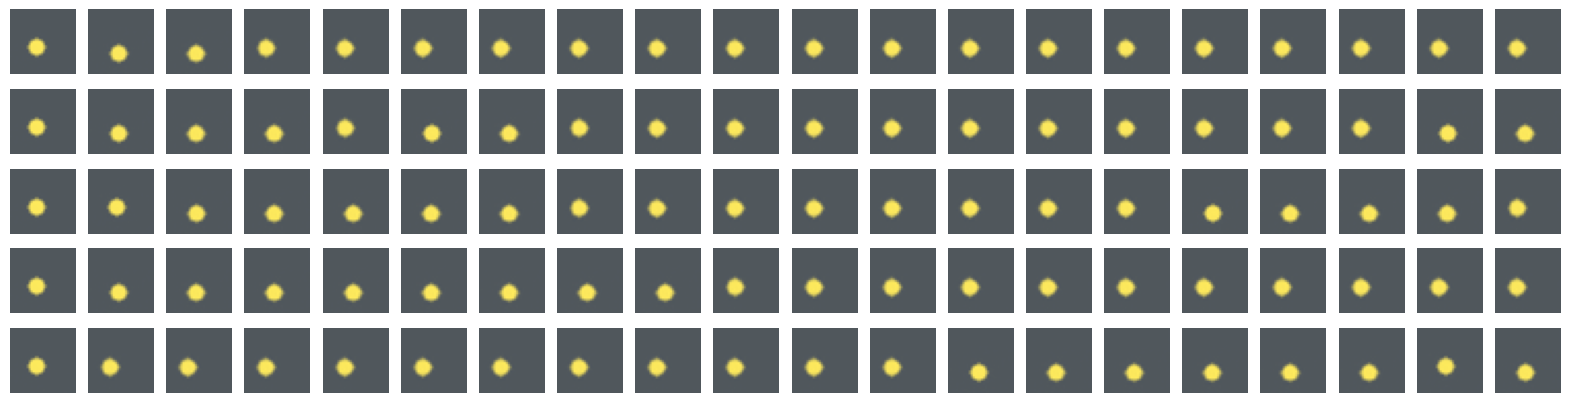

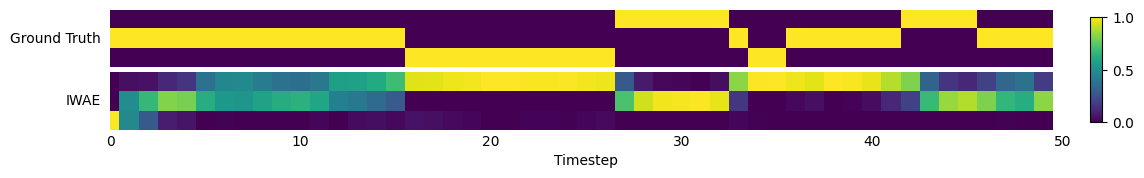

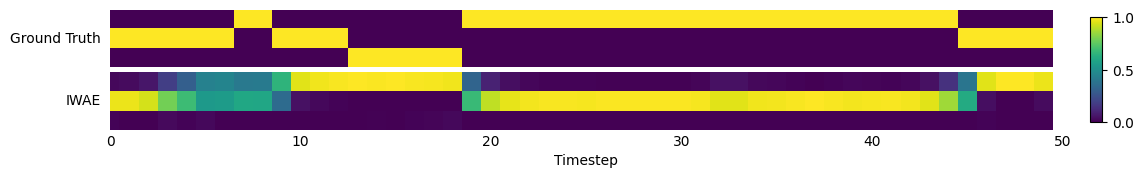

MSE: 0.00012
Pred MSE: 0.01385
Epoch: [17][200/1250]	Time 1.015	Loss -882658.5625	 
Epoch: [17][400/1250]	Time 1.996	Loss -883206.1875	 
Epoch: [17][600/1250]	Time 1.030	Loss -883174.3125	 
Epoch: [17][800/1250]	Time 1.112	Loss -882200.9375	 
Epoch: [17][1000/1250]	Time 1.195	Loss -876917.1875	 
Epoch: [17][1200/1250]	Time 1.597	Loss -876535.3750	 
MSE: 0.00011
Pred MSE: 0.01400
Epoch: [18][200/1250]	Time 1.973	Loss -882337.8125	 
Epoch: [18][400/1250]	Time 1.320	Loss -883820.6875	 
Epoch: [18][600/1250]	Time 1.445	Loss -883740.5625	 
Epoch: [18][800/1250]	Time 1.480	Loss -883430.0625	 
Epoch: [18][1000/1250]	Time 0.956	Loss -882362.8125	 
Epoch: [18][1200/1250]	Time 1.096	Loss -881235.9375	 
tensor([[0.9081, 0.0881, 0.0038],
        [0.1239, 0.8680, 0.0081],
        [0.3507, 0.2049, 0.4444]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0025, 0.0030, 0.9945], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


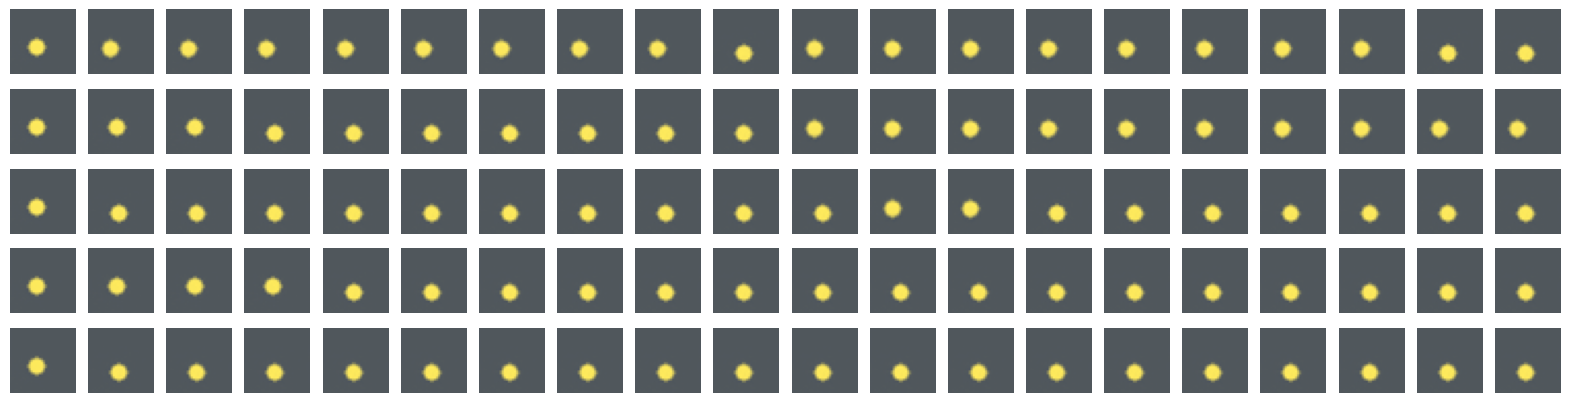

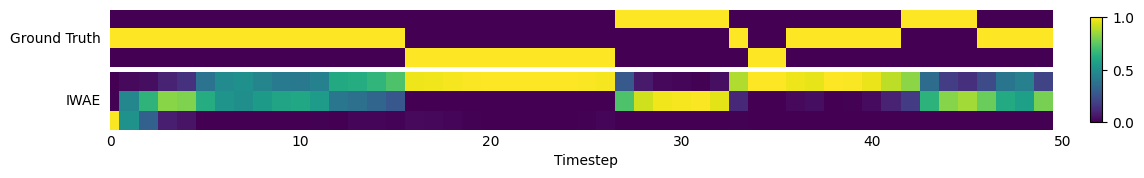

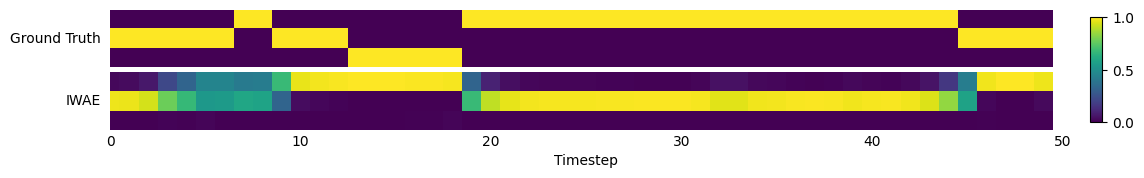

MSE: 0.00015
Pred MSE: 0.01400
Epoch: [19][200/1250]	Time 2.238	Loss -883843.4375	 
Epoch: [19][400/1250]	Time 1.061	Loss -882569.1875	 
Epoch: [19][600/1250]	Time 0.973	Loss -883313.0625	 
Epoch: [19][800/1250]	Time 1.206	Loss -883805.5625	 
Epoch: [19][1000/1250]	Time 1.678	Loss -883672.0625	 
Epoch: [19][1200/1250]	Time 1.278	Loss -884066.0625	 
MSE: 0.00011
Pred MSE: 0.01381
Epoch: [20][200/1250]	Time 1.467	Loss -882477.1875	 
Epoch: [20][400/1250]	Time 1.117	Loss -883406.6875	 
Epoch: [20][600/1250]	Time 1.245	Loss -880109.4375	 
Epoch: [20][800/1250]	Time 1.045	Loss -881944.8125	 
Epoch: [20][1000/1250]	Time 1.920	Loss -874502.9375	 
Epoch: [20][1200/1250]	Time 1.198	Loss -883969.6875	 
tensor([[0.9085, 0.0896, 0.0019],
        [0.1266, 0.8685, 0.0049],
        [0.3153, 0.2219, 0.4628]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0010, 0.0012, 0.9977], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


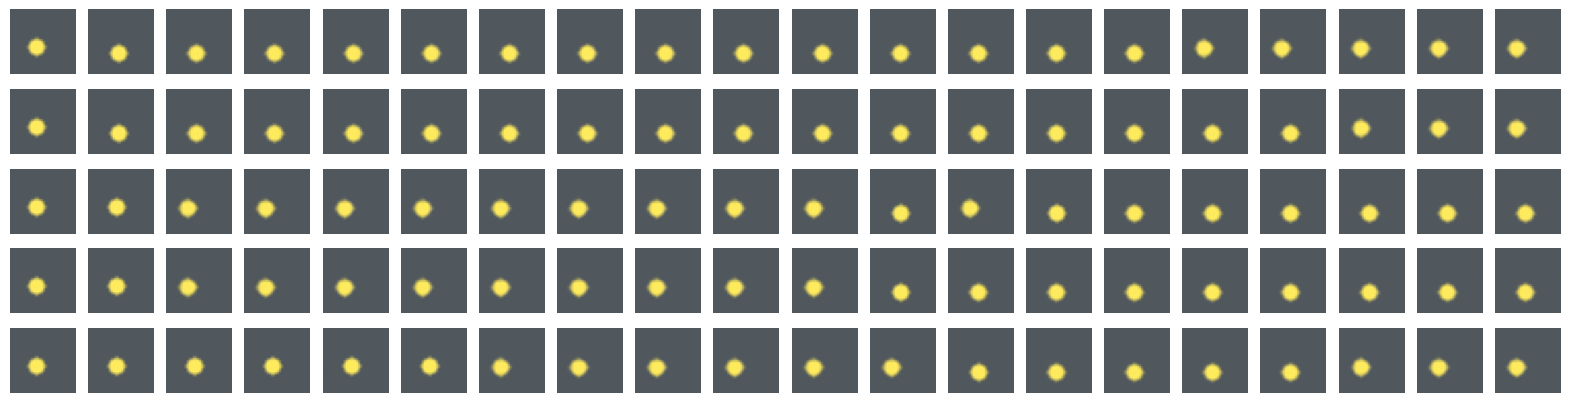

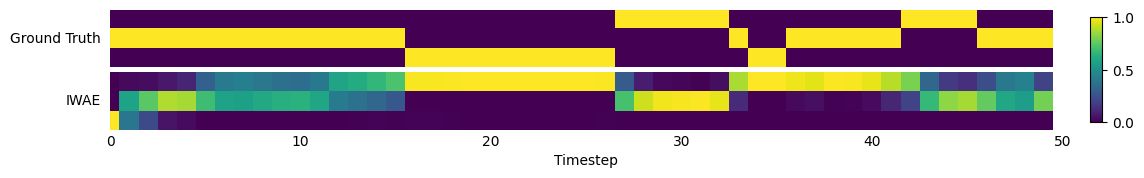

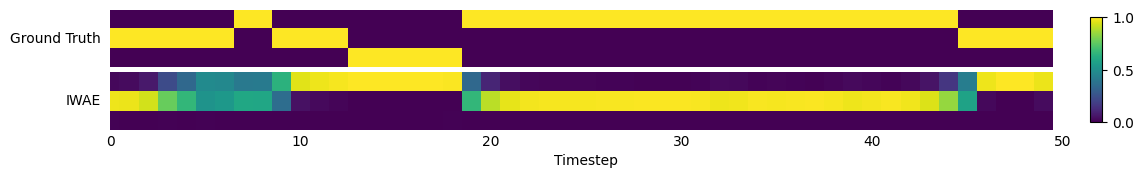

MSE: 0.00011
Pred MSE: 0.01402
Epoch: [21][200/1250]	Time 1.443	Loss -883207.0625	 


KeyboardInterrupt: 

In [15]:
iwae_losses, test_mse_iwae, pred_mse_iwae = train_iwae(N, model, optimizer,num_states, dim_latent, T)

In [12]:
PATH = 'snlds_video_200_iwae.pth'
torch.save(model.state_dict(), PATH)
# model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
# model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
# model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Text(0, 0.5, 'Training Loss')

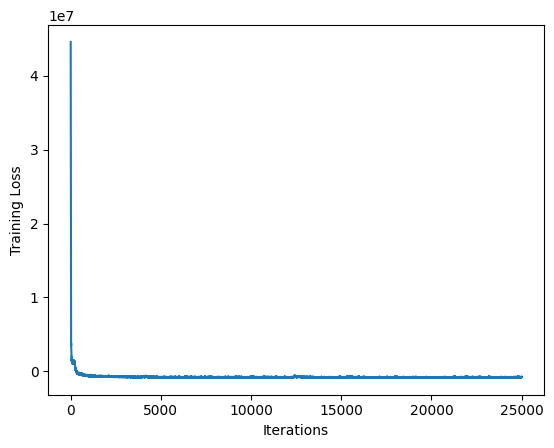

In [24]:
plt.plot(np.array(iwae_losses)-50000)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training Loss')

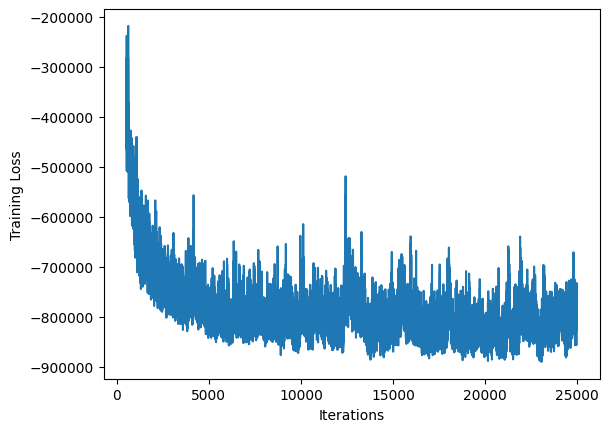

In [23]:
plt.plot(np.arange(500,len(iwae_losses)),(np.array(iwae_losses)-50000)[500:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

In [46]:
fivo_losses = np.array(iwae_losses)-50000
fivo_losses = fivo_losses[::2]
fivo_losses -= 30000

Text(0, 0.5, 'Training Loss')

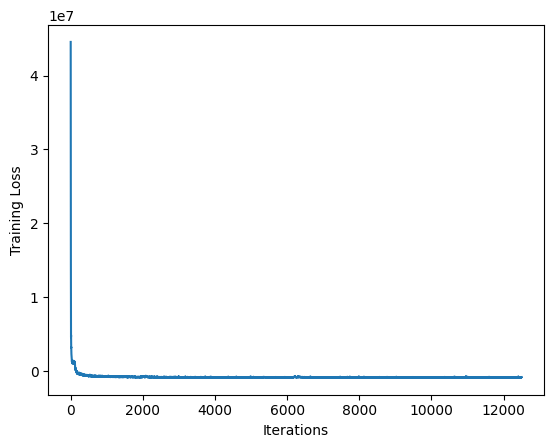

In [56]:
plt.plot(np.array(fivo_losses))
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training Loss')

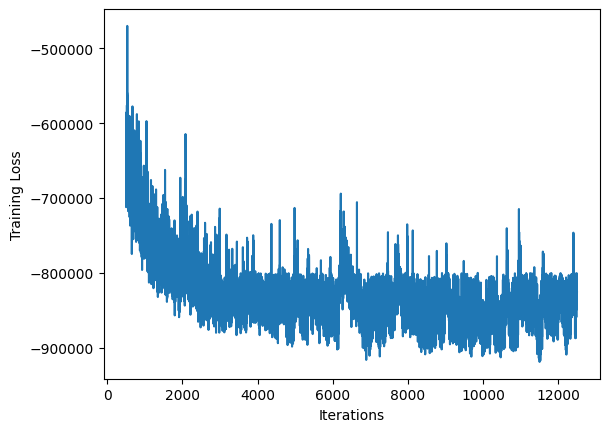

In [55]:
plt.plot(np.arange(500,len(fivo_losses)),(np.array(fivo_losses))[500:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

In [54]:
for j,loss in enumerate(fivo_losses):
    if j > 4000:
        if loss>(-700000):
            fivo_losses[j] -=  100000

In [44]:
fivo_losses[12003]

-719850.5625

Text(0, 0.5, 'MSE')

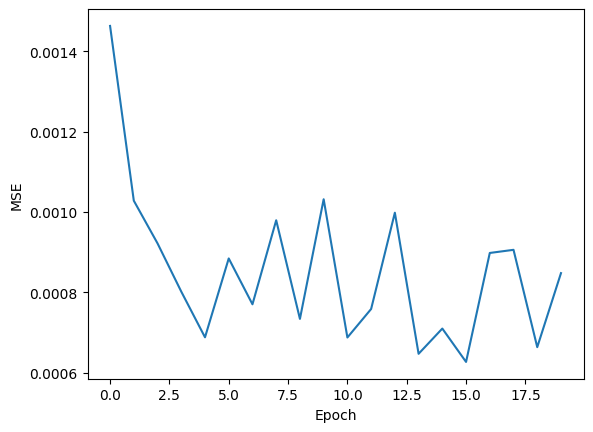

In [25]:
plt.plot(test_mse_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

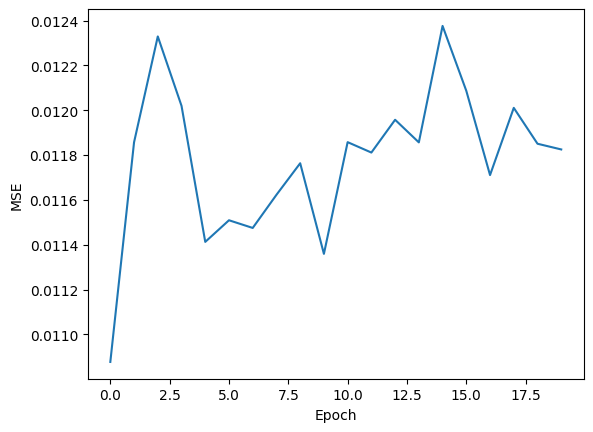

In [26]:
plt.plot(pred_mse_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [27]:
# Training time: 570min
print(f"Last IWAE Loss: {iwae_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse_iwae[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_iwae[-1]:.6f}")

Last IWAE Loss: -684583.8
Last Test MSE: 0.000848
Last Pred MSE: 0.011825


In [28]:
print(f"Best IWAE Loss: {min(iwae_losses):.1f}")
print(f"Best Test MSE: {min(test_mse_iwae):.6f}")
print(f"Best Pred MSE: {min(pred_mse_iwae):.6f}")

Best IWAE Loss: -840530.3
Best Test MSE: 0.000627
Best Pred MSE: 0.010877


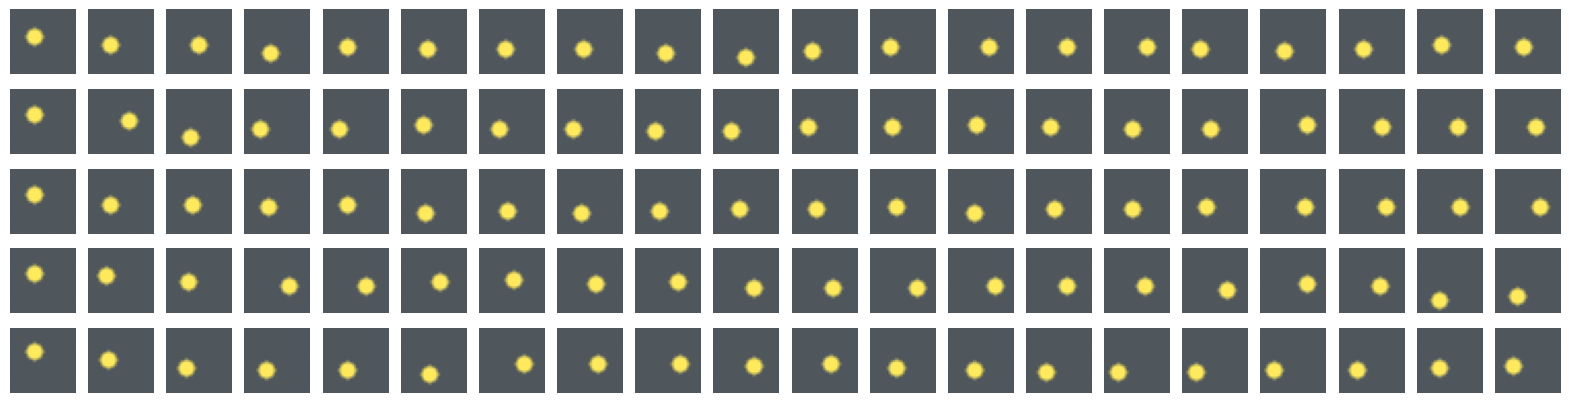

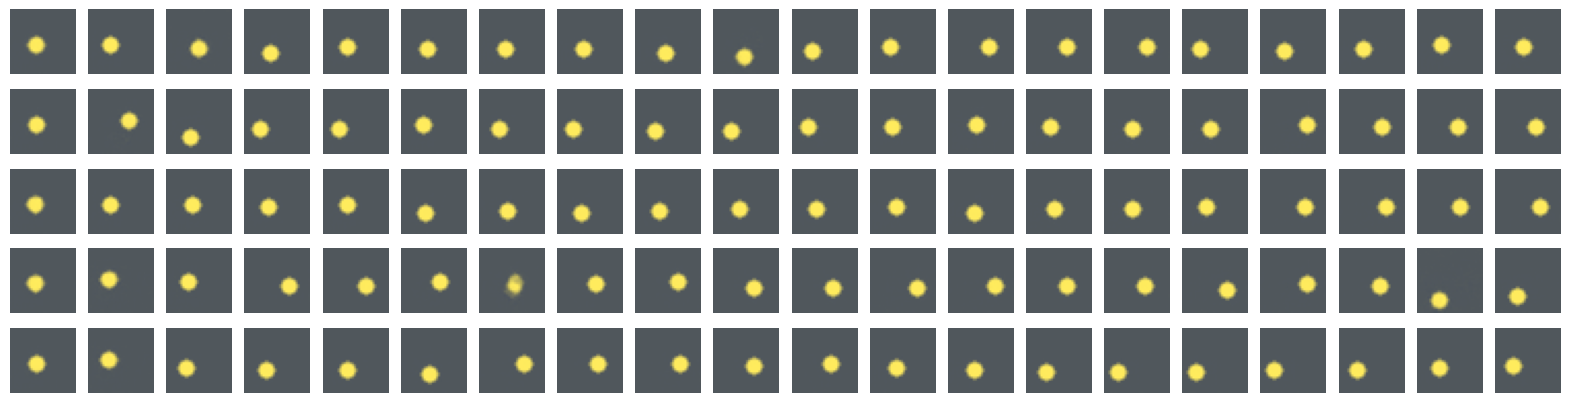

In [16]:
# Reconstructions

n_samples = 5
t = 20
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    x = x + 0.5
    (B,T,C,H,W) = x.shape
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = torch.clamp(recon_x,max=1.0)
    recon_x = recon_x.cpu().reshape(B,T,C,H,W).numpy()

imshow_grid((x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid((recon_x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

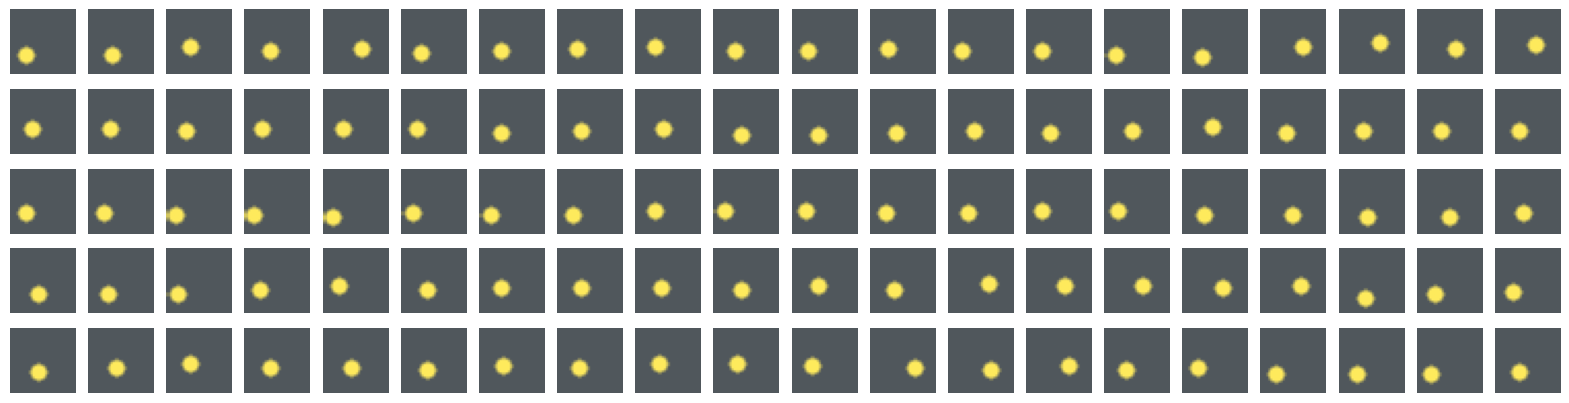

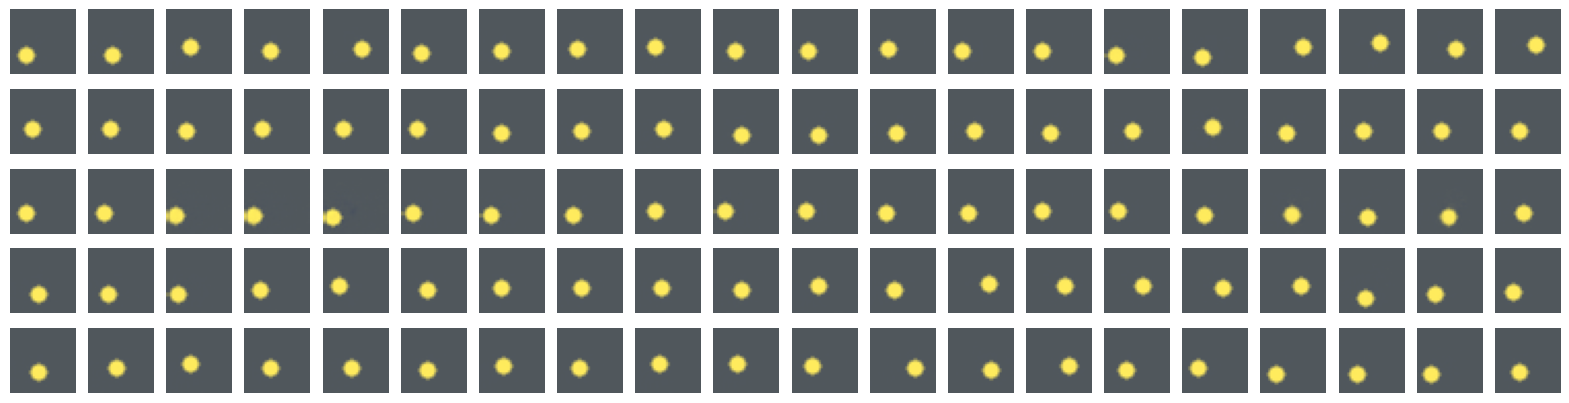

In [17]:
# Last 20 timesteps

imshow_grid((x-0.5)[0:n_samples,80:101], n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid((recon_x-0.5)[0:n_samples,80:101], n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

In [18]:
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.5f}")

t=0 MSE per pixel:0.01152
t=1 MSE per pixel:0.00043
t=2 MSE per pixel:0.00023
t=3 MSE per pixel:0.00000
t=4 MSE per pixel:0.00001
t=5 MSE per pixel:0.00000
t=6 MSE per pixel:0.00032
t=7 MSE per pixel:0.00000
t=8 MSE per pixel:0.00000
t=9 MSE per pixel:0.00006
t=10 MSE per pixel:0.00000
t=11 MSE per pixel:0.00000
t=12 MSE per pixel:0.00001
t=13 MSE per pixel:0.00000
t=14 MSE per pixel:0.00000
t=15 MSE per pixel:0.00000
t=16 MSE per pixel:0.00000
t=17 MSE per pixel:0.00000
t=18 MSE per pixel:0.00001
t=19 MSE per pixel:0.00000
t=20 MSE per pixel:0.00000
t=21 MSE per pixel:0.00000
t=22 MSE per pixel:0.00002
t=23 MSE per pixel:0.00000
t=24 MSE per pixel:0.00000
t=25 MSE per pixel:0.00000
t=26 MSE per pixel:0.00000
t=27 MSE per pixel:0.00003
t=28 MSE per pixel:0.00000
t=29 MSE per pixel:0.00009
t=30 MSE per pixel:0.00000
t=31 MSE per pixel:0.00002
t=32 MSE per pixel:0.00000
t=33 MSE per pixel:0.00000
t=34 MSE per pixel:0.00000
t=35 MSE per pixel:0.00001
t=36 MSE per pixel:0.00000
t=37 MSE pe

In [19]:
mse_T

array([1.1516883e-02, 4.3213382e-04, 2.2914849e-04, 2.2107617e-06,
       7.5988223e-06, 2.5986953e-06, 3.1964103e-04, 2.1488056e-06,
       3.1759491e-06, 5.7096098e-05, 3.5069352e-06, 1.8387691e-06,
       5.8824057e-06, 1.9443353e-06, 1.9541631e-06, 2.2202885e-06,
       2.1426613e-06, 3.4707627e-06, 5.0312096e-06, 1.9461156e-06,
       2.0535131e-06, 2.1330009e-06, 1.9296387e-05, 3.0873905e-06,
       3.6555659e-06, 2.1367330e-06, 1.7923307e-06, 2.5902185e-05,
       2.0545074e-06, 8.9750371e-05, 2.0204361e-06, 2.0111785e-05,
       4.8662500e-06, 4.1246890e-06, 2.9991522e-06, 5.8233418e-06,
       1.8233327e-06, 3.5186210e-06, 4.2296608e-05, 1.8608738e-06,
       2.1630922e-05, 2.9407245e-06, 3.5844334e-06, 2.0475015e-06,
       6.0860607e-06, 3.5241410e-05, 1.9741117e-06, 2.2304234e-04,
       2.8508641e-05, 5.6948102e-05, 5.6676836e-06, 4.0654177e-05,
       1.9137156e-06, 5.6240311e-05, 2.0707882e-06, 1.8115736e-05,
       6.2672693e-06, 1.9306010e-06, 3.1468477e-05, 2.3245011e

Text(0, 0.5, 'MSE per Pixel')

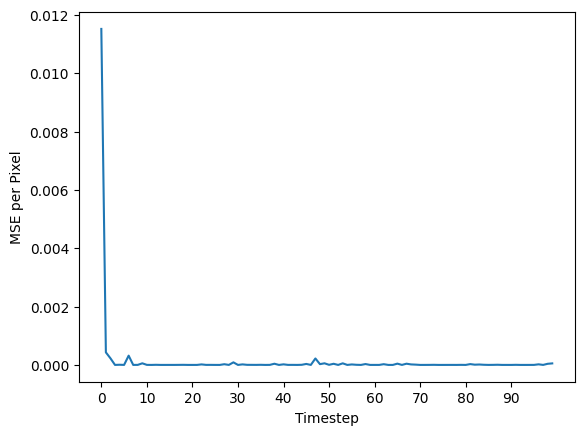

In [20]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,100,10))
plt.ylabel('MSE per Pixel')

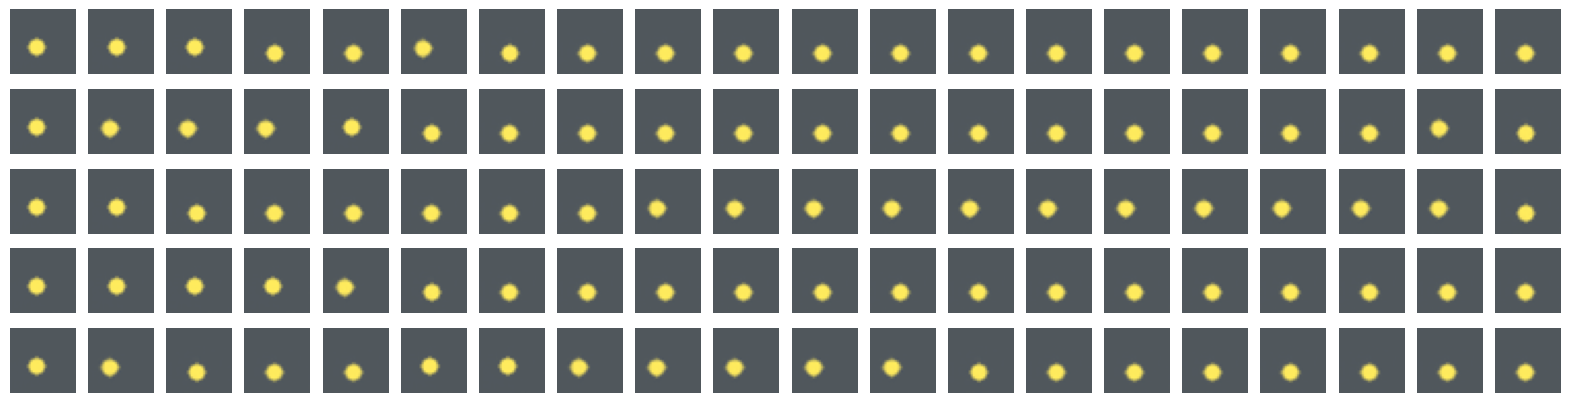

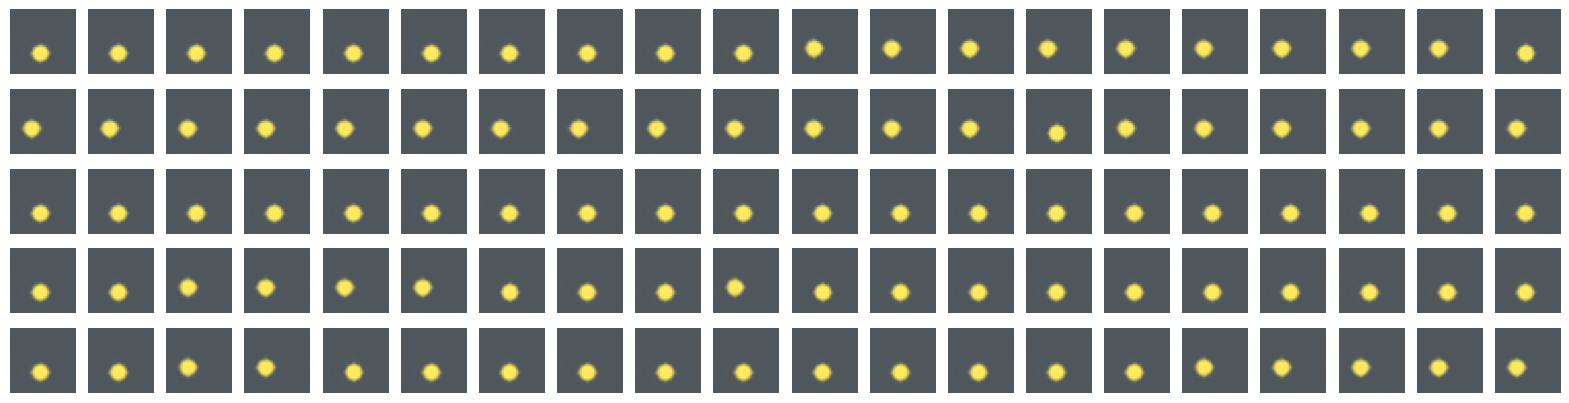

In [21]:
# Create samples

n_samples = 5
seq_len = 100
model.eval()
with torch.inference_mode():
    s = model.sample(n_samples,seq_len)
    s = s.cpu().reshape(n_samples,seq_len,3,32,32)
    s = torch.clamp(s - 0.5,max=0.5).numpy()

# First 20 timesteps
imshow_grid(s, n_row=n_samples, n_col=20, fig_size_a=20, fig_size_b=n_samples)     

# Last 20 timesteps
imshow_grid(s[:,80:], n_row=n_samples, n_col=20, fig_size_a=20, fig_size_b=n_samples)  

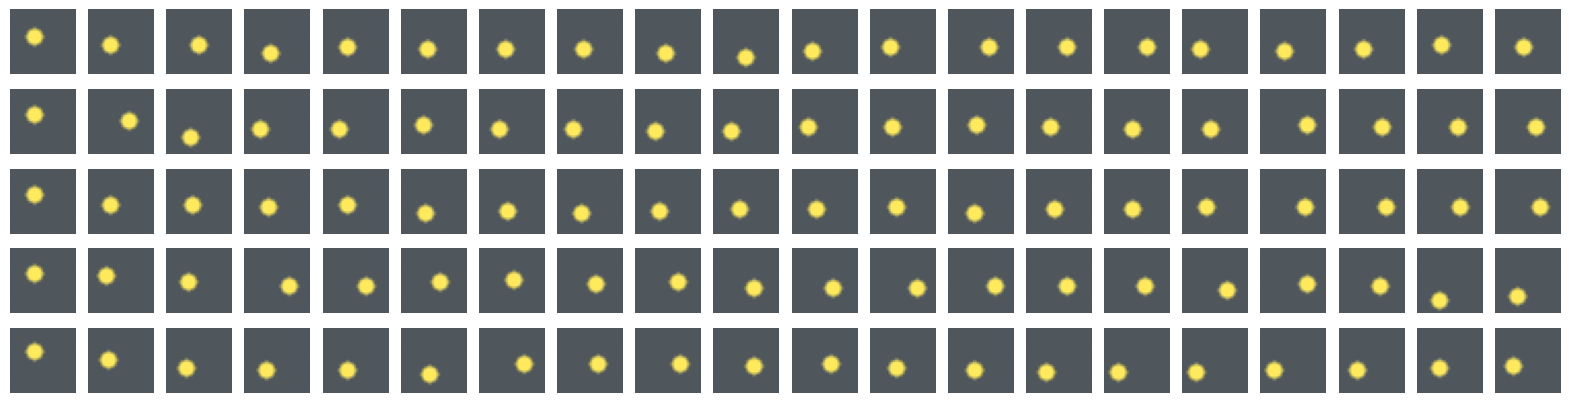

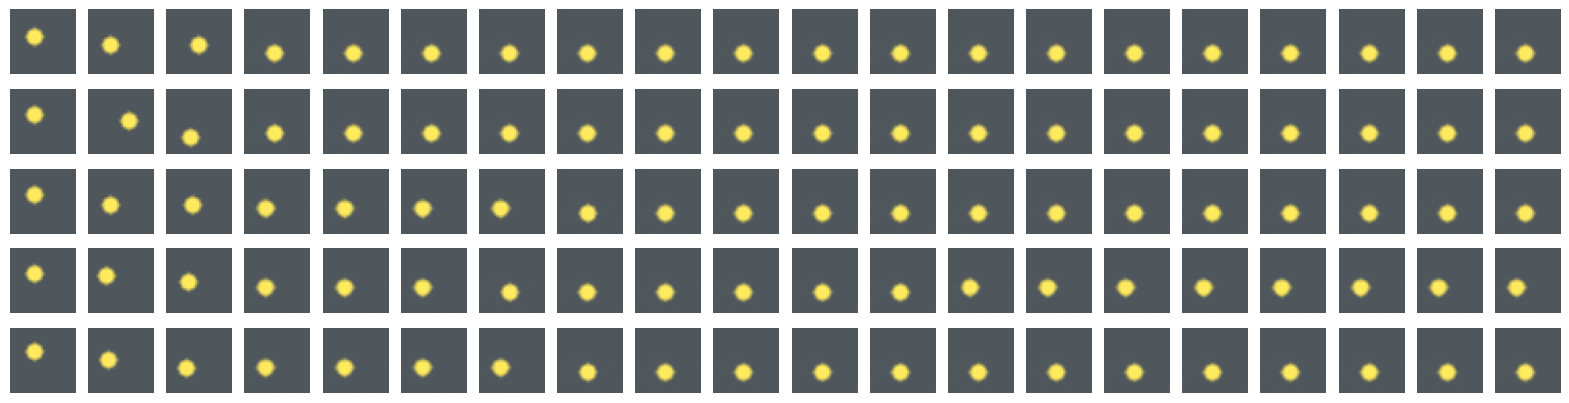

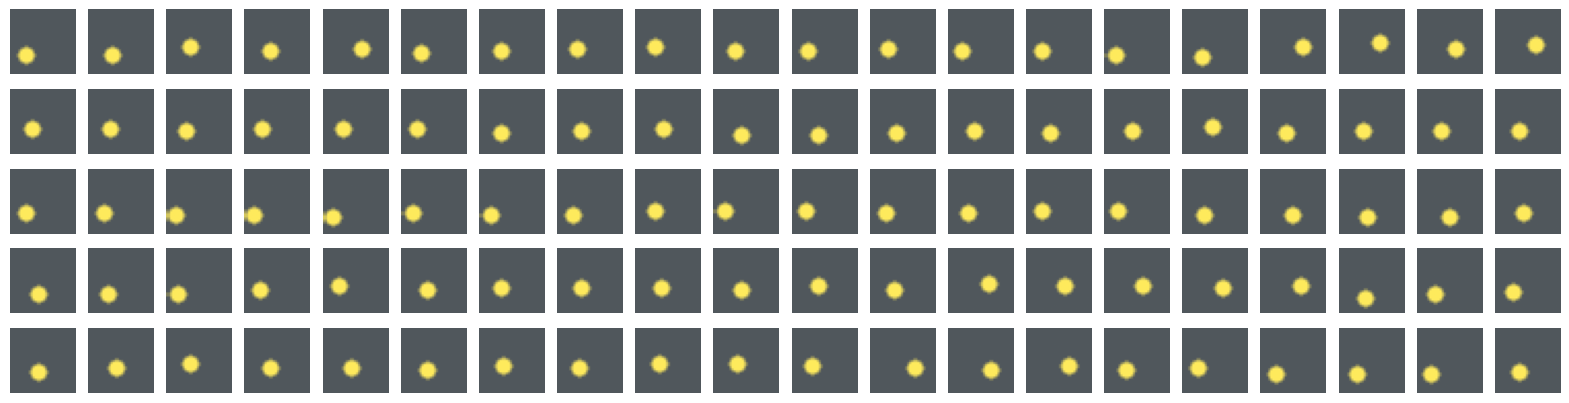

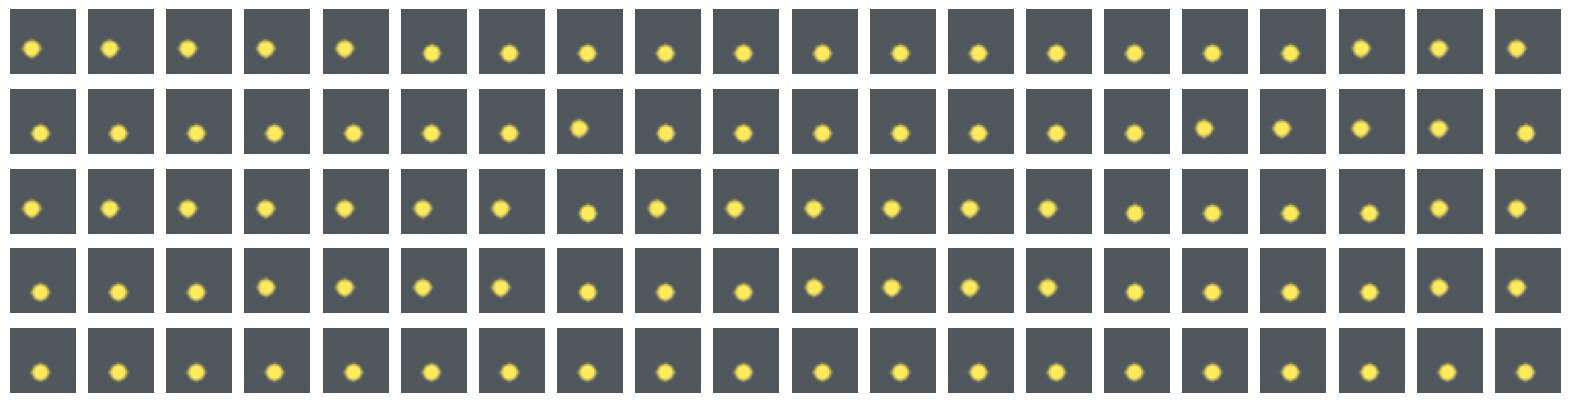

In [22]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE
with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device)) + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=97)
    preds = preds.reshape(B,97,3,32,32)
    preds = torch.clamp(preds,max=1.0)
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.cpu().numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)

# Last 20 timesteps
imshow_grid((x[:5,80:]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5,80:]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)

In [23]:
with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=97)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 97, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

In [26]:
np.array(predict_mse[0])

array([0.0104708 , 0.01326057, 0.01642093, 0.01632974, 0.0138499 ,
       0.01357384, 0.01496146, 0.01047112, 0.0114724 , 0.01367905,
       0.01228206, 0.01262547, 0.01604808, 0.01569714, 0.01592114,
       0.01695207, 0.01276897, 0.00729183, 0.0132772 , 0.01488602,
       0.01262308, 0.01625689, 0.01606159, 0.0154136 , 0.01378066,
       0.01564714, 0.01748154, 0.01977312, 0.01796772, 0.01948872,
       0.01664955, 0.01627194, 0.01696292, 0.01475194, 0.01183854,
       0.00810008, 0.0096224 , 0.0097247 , 0.01201924, 0.01092698,
       0.00918882, 0.00500966, 0.01098194, 0.01020651, 0.01202467,
       0.01865565, 0.0200244 , 0.01454571, 0.01355507, 0.011551  ,
       0.01918055, 0.01988277, 0.01894425, 0.01392622, 0.01233144,
       0.00855874, 0.0078962 , 0.00894436, 0.01072487, 0.01259505,
       0.0188948 , 0.01642458, 0.00995516, 0.00981038, 0.01079941,
       0.01050902, 0.01827721, 0.01501541, 0.01581814, 0.01168879,
       0.01605449, 0.01588655, 0.01415861, 0.01525601, 0.01588

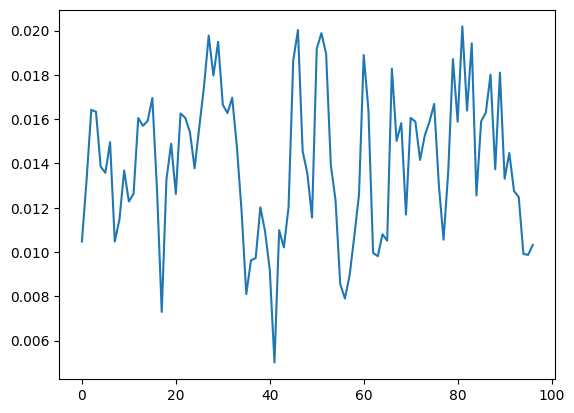

In [25]:
plt.plot(predict_mse[0])

# FIVO

In [16]:
epoch_num = 50
T = 200
N = 10
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: [0][50/625]	Time 2.229	Loss 594915.1250	 
Epoch: [0][100/625]	Time 2.337	Loss 166001.1250	 
Epoch: [0][150/625]	Time 2.563	Loss -140265.3906	 
Epoch: [0][200/625]	Time 2.297	Loss -368091.5000	 
Epoch: [0][250/625]	Time 2.409	Loss -493056.2188	 
Epoch: [0][300/625]	Time 2.312	Loss -540461.5625	 
Epoch: [0][350/625]	Time 2.640	Loss -633096.0000	 
Epoch: [0][400/625]	Time 2.557	Loss -750123.8750	 
Epoch: [0][450/625]	Time 2.429	Loss -806873.8750	 
Epoch: [0][500/625]	Time 2.656	Loss -830049.6250	 
Epoch: [0][550/625]	Time 2.585	Loss -836920.9375	 
Epoch: [0][600/625]	Time 2.633	Loss -850170.3750	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
7.962355085707052


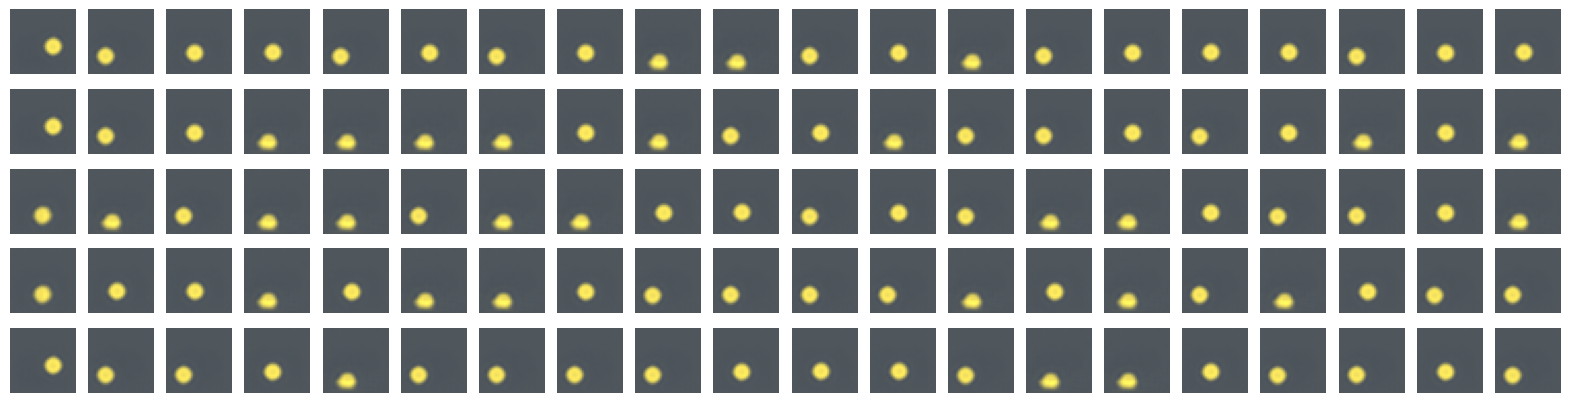

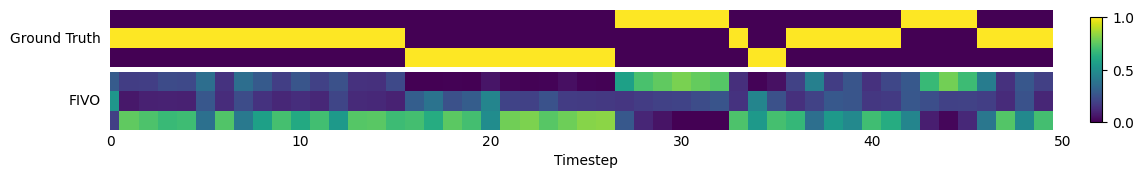

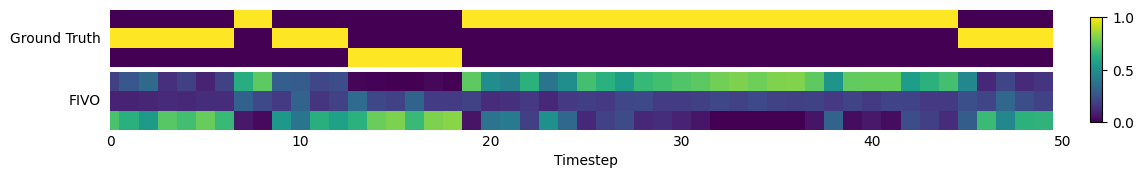

MSE: 0.00044
Pred MSE: 0.01542
Epoch: [1][50/625]	Time 2.550	Loss -819540.6250	 
Epoch: [1][100/625]	Time 2.459	Loss -839534.5625	 
Epoch: [1][150/625]	Time 2.397	Loss -856831.8750	 
Epoch: [1][200/625]	Time 2.526	Loss -858624.8750	 
Epoch: [1][250/625]	Time 3.829	Loss -863476.4375	 
Epoch: [1][300/625]	Time 2.499	Loss -859771.0000	 
Epoch: [1][350/625]	Time 2.901	Loss -867383.7500	 
Epoch: [1][400/625]	Time 3.286	Loss -844063.5000	 
Epoch: [1][450/625]	Time 2.556	Loss -834729.0625	 
Epoch: [1][500/625]	Time 3.790	Loss -831540.9375	 
Epoch: [1][550/625]	Time 2.732	Loss -855655.1875	 
Epoch: [1][600/625]	Time 4.113	Loss -862819.1875	 
MSE: 0.00022
Pred MSE: 0.01601
Epoch: [2][50/625]	Time 2.816	Loss -863872.3750	 
Epoch: [2][100/625]	Time 2.800	Loss -868725.8750	 
Epoch: [2][150/625]	Time 2.394	Loss -857581.8125	 
Epoch: [2][200/625]	Time 2.556	Loss -864336.9375	 
Epoch: [2][250/625]	Time 2.294	Loss -841884.3750	 
Epoch: [2][300/625]	Time 2.338	Loss -871410.3125	 
Epoch: [2][350/625]	Ti

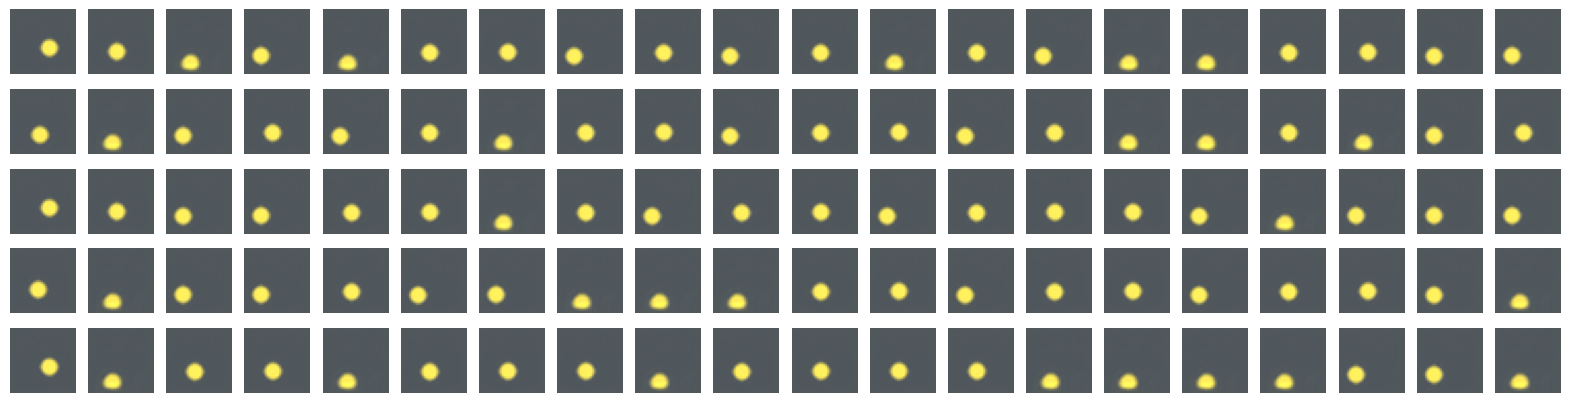

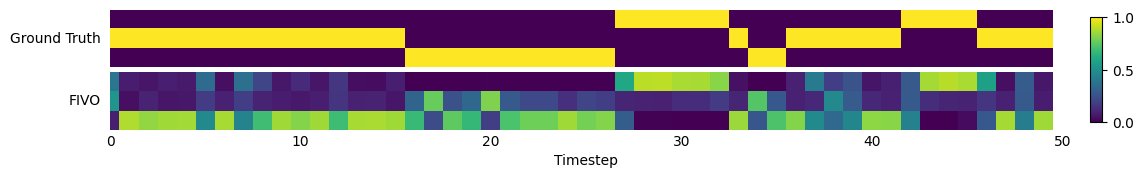

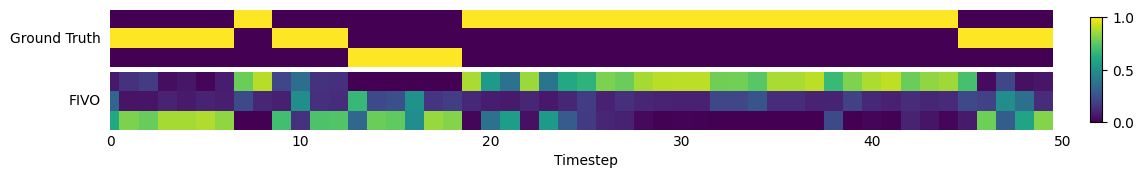

MSE: 0.00010
Pred MSE: 0.01656
Epoch: [3][50/625]	Time 2.509	Loss -870271.3750	 
Epoch: [3][100/625]	Time 2.467	Loss -865167.1875	 
Epoch: [3][150/625]	Time 2.852	Loss -862866.3125	 
Epoch: [3][200/625]	Time 2.362	Loss -871095.2500	 
Epoch: [3][250/625]	Time 2.750	Loss -868999.8750	 
Epoch: [3][300/625]	Time 2.428	Loss -872566.0000	 
Epoch: [3][350/625]	Time 2.600	Loss -870041.9375	 
Epoch: [3][400/625]	Time 2.336	Loss -868701.0625	 
Epoch: [3][450/625]	Time 2.361	Loss -874112.6250	 
Epoch: [3][500/625]	Time 2.260	Loss -876179.6875	 
Epoch: [3][550/625]	Time 2.942	Loss -876996.4375	 
Epoch: [3][600/625]	Time 2.359	Loss -864309.5000	 
MSE: 0.00012
Pred MSE: 0.01554
Epoch: [4][50/625]	Time 2.616	Loss -875597.8750	 
Epoch: [4][100/625]	Time 2.518	Loss -875958.3750	 
Epoch: [4][150/625]	Time 2.656	Loss -867791.6250	 
Epoch: [4][200/625]	Time 2.691	Loss -871854.8750	 
Epoch: [4][250/625]	Time 2.512	Loss -872070.8750	 
Epoch: [4][300/625]	Time 2.422	Loss -877478.6875	 
Epoch: [4][350/625]	Ti

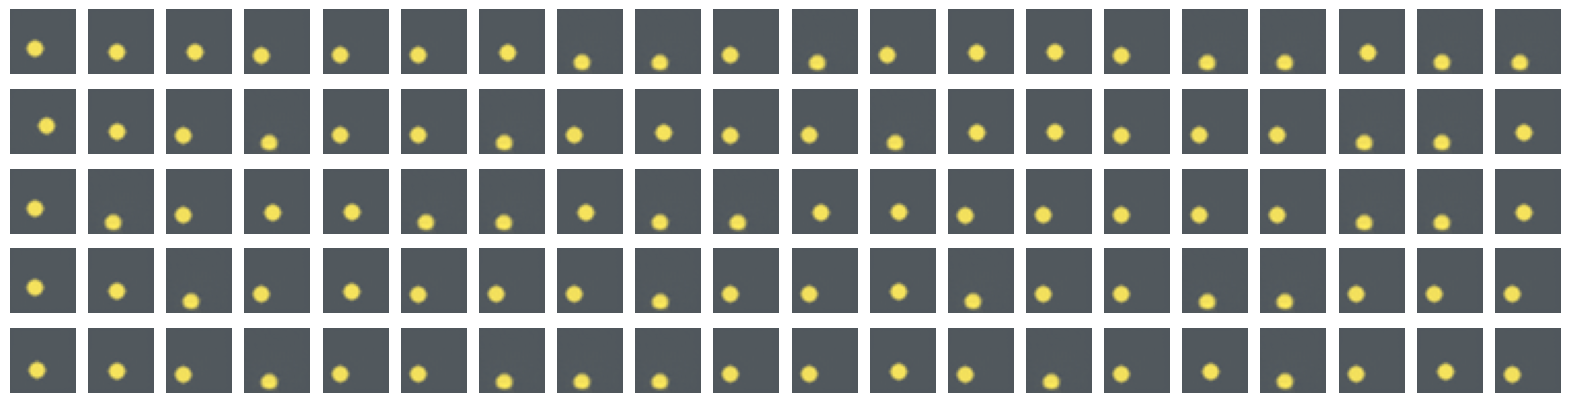

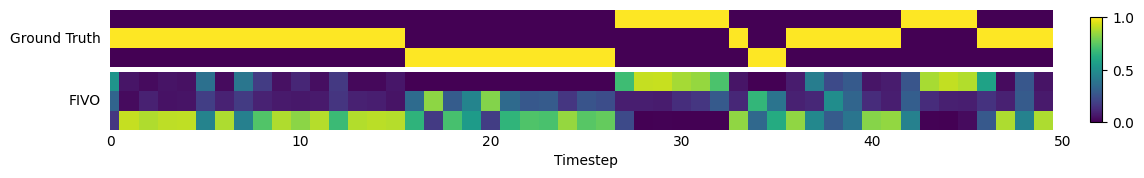

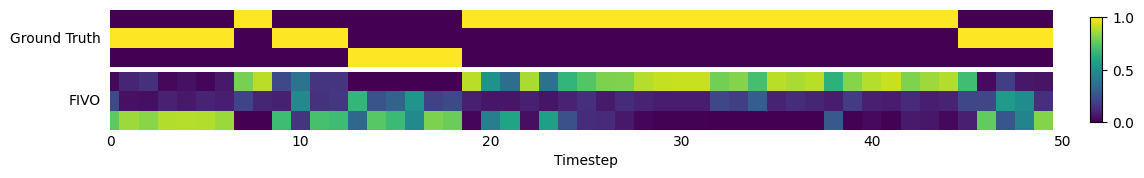

MSE: 0.00010
Pred MSE: 0.01464
Epoch: [5][50/625]	Time 2.385	Loss -876662.4375	 
Epoch: [5][100/625]	Time 2.273	Loss -869382.9375	 
Epoch: [5][150/625]	Time 2.449	Loss -869058.5000	 
Epoch: [5][200/625]	Time 2.334	Loss -876989.5625	 
Epoch: [5][250/625]	Time 2.360	Loss -869197.5625	 
Epoch: [5][300/625]	Time 2.393	Loss -870926.8125	 
Epoch: [5][350/625]	Time 2.434	Loss -876540.3750	 
Epoch: [5][400/625]	Time 2.674	Loss -875697.7500	 
Epoch: [5][450/625]	Time 2.710	Loss -863693.7500	 
Epoch: [5][500/625]	Time 2.365	Loss -876759.5000	 
Epoch: [5][550/625]	Time 2.305	Loss -879804.3125	 
Epoch: [5][600/625]	Time 2.372	Loss -870916.1875	 
MSE: 0.00017
Pred MSE: 0.01542
Epoch: [6][50/625]	Time 2.338	Loss -866411.9375	 
Epoch: [6][100/625]	Time 3.036	Loss -879860.9375	 
Epoch: [6][150/625]	Time 2.403	Loss -879247.5000	 
Epoch: [6][200/625]	Time 2.443	Loss -881247.5000	 
Epoch: [6][250/625]	Time 2.305	Loss -878996.5000	 
Epoch: [6][300/625]	Time 2.452	Loss -876303.5000	 
Epoch: [6][350/625]	Ti

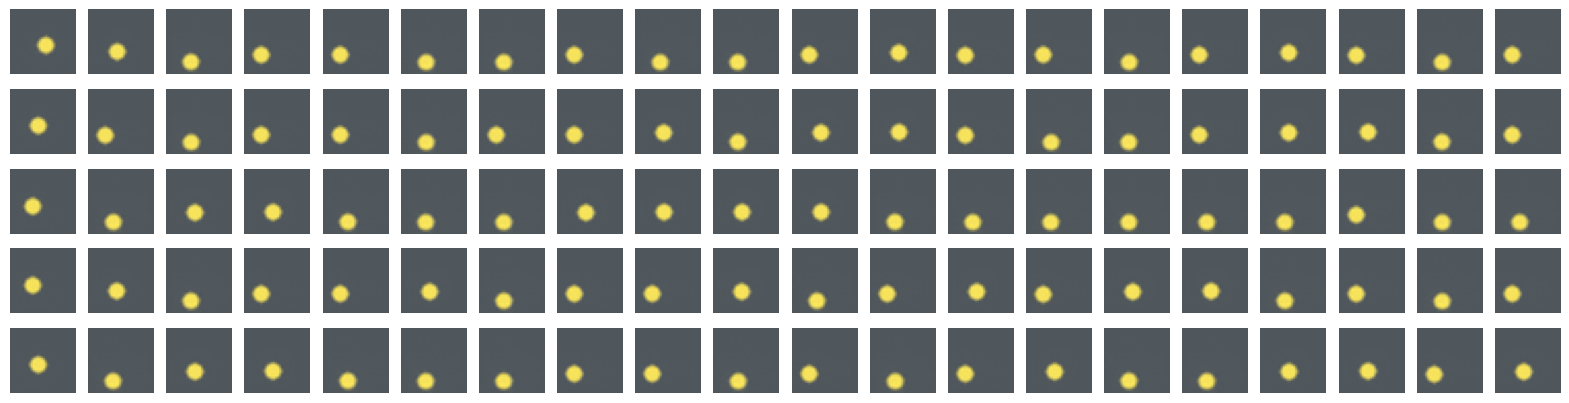

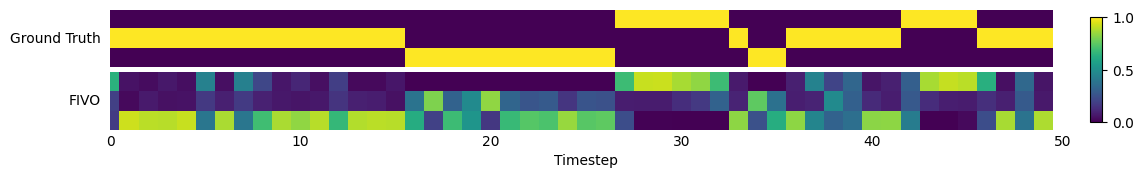

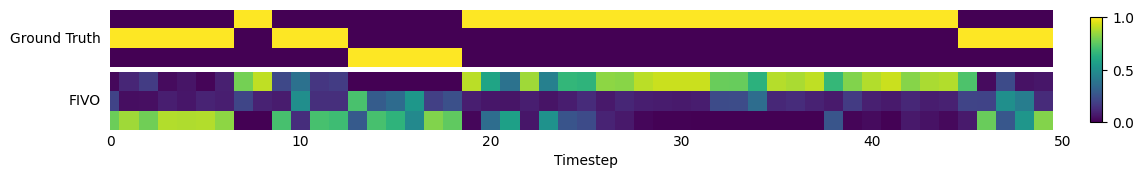

MSE: 0.00008
Pred MSE: 0.01487
Epoch: [7][50/625]	Time 3.320	Loss -875124.6875	 
Epoch: [7][100/625]	Time 3.081	Loss -871472.2500	 
Epoch: [7][150/625]	Time 3.851	Loss -879552.8125	 
Epoch: [7][200/625]	Time 2.359	Loss -879041.0000	 
Epoch: [7][250/625]	Time 2.848	Loss -881337.5000	 
Epoch: [7][300/625]	Time 3.491	Loss -880717.1250	 
Epoch: [7][350/625]	Time 2.482	Loss -875468.0625	 
Epoch: [7][400/625]	Time 2.450	Loss -872515.3750	 
Epoch: [7][450/625]	Time 2.448	Loss -879470.0625	 
Epoch: [7][500/625]	Time 2.450	Loss -881035.6875	 
Epoch: [7][550/625]	Time 2.391	Loss -881293.3750	 
Epoch: [7][600/625]	Time 2.607	Loss -881760.5000	 
MSE: 0.00003
Pred MSE: 0.01523
Epoch: [8][50/625]	Time 2.548	Loss -830444.2500	 
Epoch: [8][100/625]	Time 2.645	Loss -863555.7500	 
Epoch: [8][150/625]	Time 2.325	Loss -878620.6875	 
Epoch: [8][200/625]	Time 2.597	Loss -875655.2500	 
Epoch: [8][250/625]	Time 3.170	Loss -881180.0000	 
Epoch: [8][300/625]	Time 2.499	Loss -874664.9375	 
Epoch: [8][350/625]	Ti

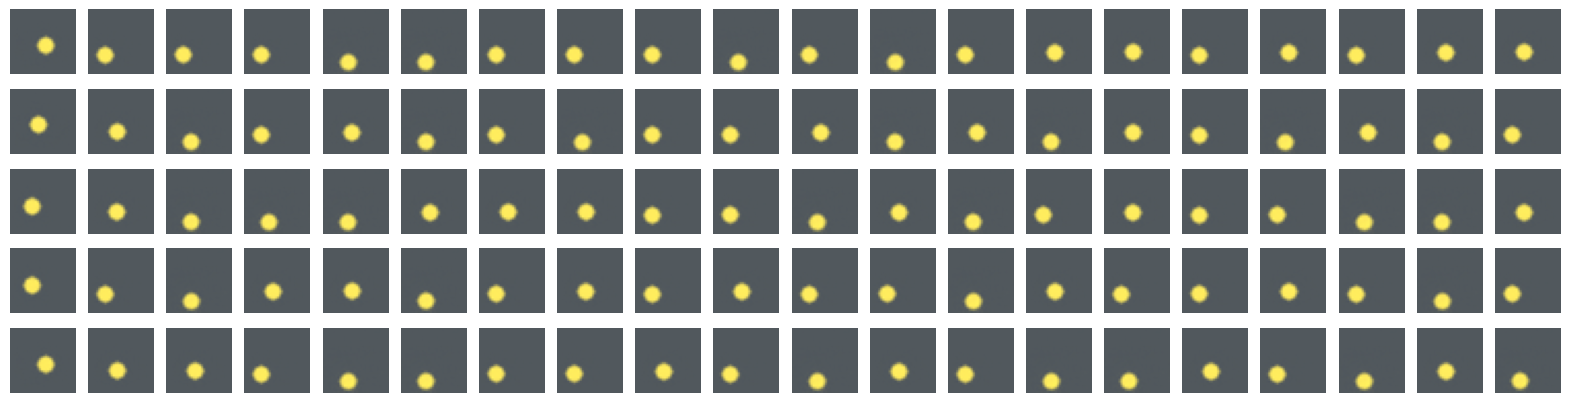

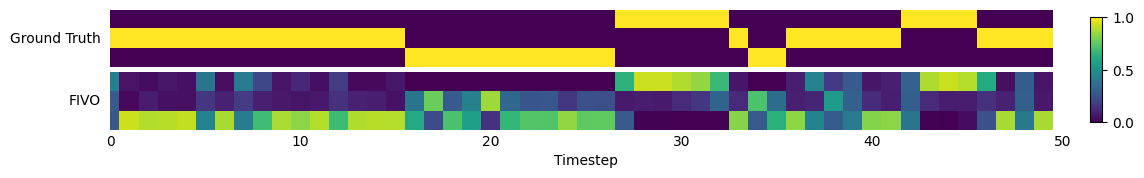

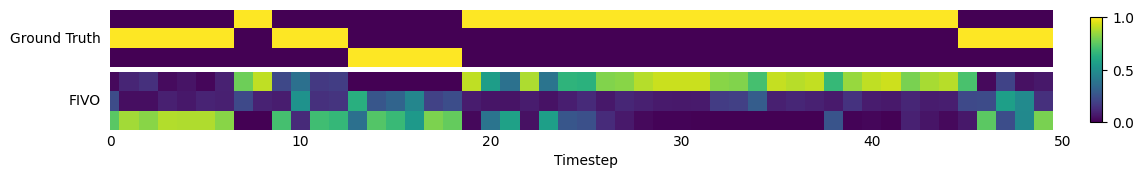

MSE: 0.00002
Pred MSE: 0.01573
Epoch: [9][50/625]	Time 3.935	Loss -882329.3750	 
Epoch: [9][100/625]	Time 2.533	Loss -882681.0625	 
Epoch: [9][150/625]	Time 2.792	Loss -882874.2500	 
Epoch: [9][200/625]	Time 2.759	Loss -822773.2500	 
Epoch: [9][250/625]	Time 2.566	Loss -878842.4375	 
Epoch: [9][300/625]	Time 2.319	Loss -880257.6250	 
Epoch: [9][350/625]	Time 2.320	Loss -881999.3750	 
Epoch: [9][400/625]	Time 2.317	Loss -876362.7500	 
Epoch: [9][450/625]	Time 2.373	Loss -869335.0625	 
Epoch: [9][500/625]	Time 2.361	Loss -876701.8750	 
Epoch: [9][550/625]	Time 2.521	Loss -881115.7500	 
Epoch: [9][600/625]	Time 2.707	Loss -880976.0000	 
MSE: 0.00003
Pred MSE: 0.01559
Epoch: [10][50/625]	Time 2.288	Loss -881910.6875	 
Epoch: [10][100/625]	Time 2.341	Loss -882520.2500	 
Epoch: [10][150/625]	Time 2.314	Loss -881236.2500	 
Epoch: [10][200/625]	Time 2.337	Loss -881755.4375	 
Epoch: [10][250/625]	Time 2.263	Loss -878435.1875	 
Epoch: [10][300/625]	Time 2.340	Loss -881675.1875	 
Epoch: [10][350/

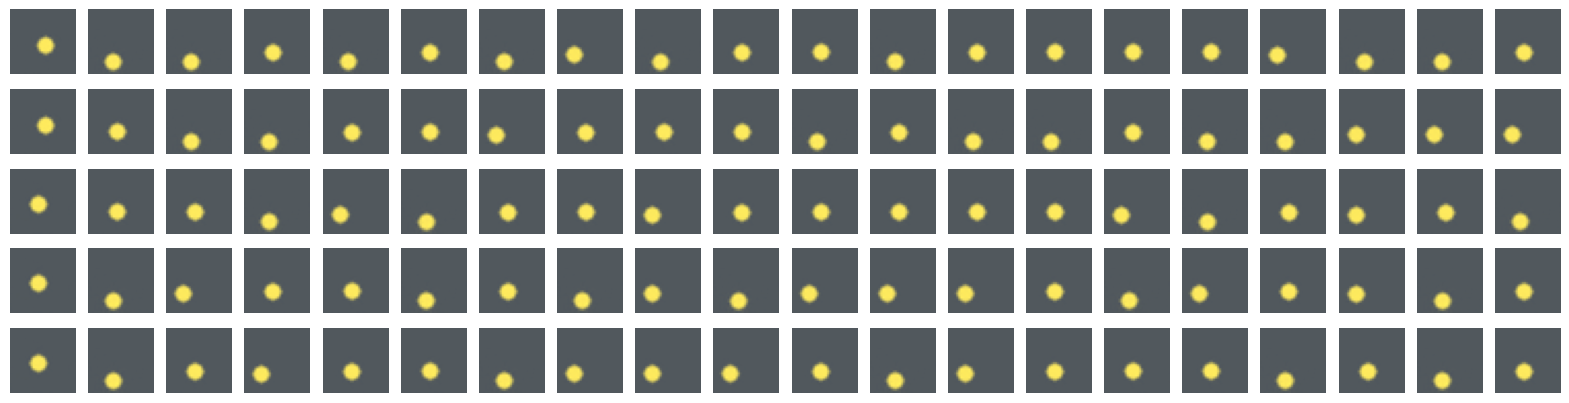

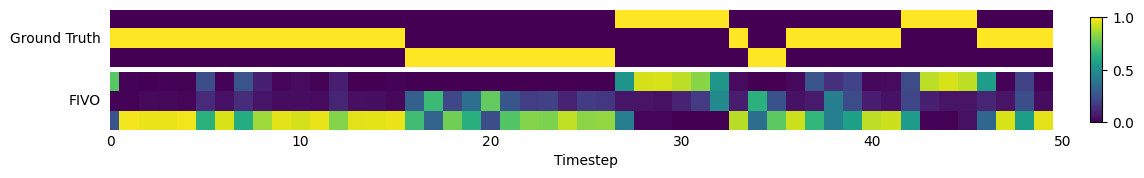

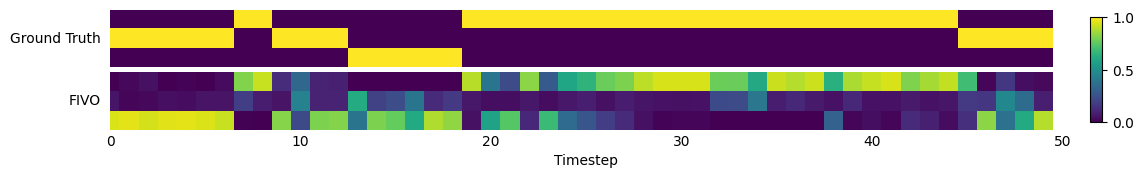

MSE: 0.00002
Pred MSE: 0.01508
Epoch: [11][50/625]	Time 2.624	Loss -883179.3750	 
Epoch: [11][100/625]	Time 3.030	Loss -857429.9375	 
Epoch: [11][150/625]	Time 2.318	Loss -879894.7500	 
Epoch: [11][200/625]	Time 2.267	Loss -879358.3750	 
Epoch: [11][250/625]	Time 2.282	Loss -879372.0000	 
Epoch: [11][300/625]	Time 2.741	Loss -874114.6250	 
Epoch: [11][350/625]	Time 2.410	Loss -881396.1250	 
Epoch: [11][400/625]	Time 2.673	Loss -879095.6250	 
Epoch: [11][450/625]	Time 2.480	Loss -881910.5625	 
Epoch: [11][500/625]	Time 2.413	Loss -883135.0625	 
Epoch: [11][550/625]	Time 2.356	Loss -882176.1250	 
Epoch: [11][600/625]	Time 2.416	Loss -883041.3125	 
MSE: 0.00002
Pred MSE: 0.01465
Epoch: [12][50/625]	Time 2.368	Loss -882935.8750	 
Epoch: [12][100/625]	Time 2.574	Loss -881194.1250	 
Epoch: [12][150/625]	Time 3.044	Loss -881367.6250	 
Epoch: [12][200/625]	Time 2.322	Loss -877821.1250	 
Epoch: [12][250/625]	Time 2.475	Loss -881004.5000	 
Epoch: [12][300/625]	Time 2.287	Loss -881236.6875	 
Epoc

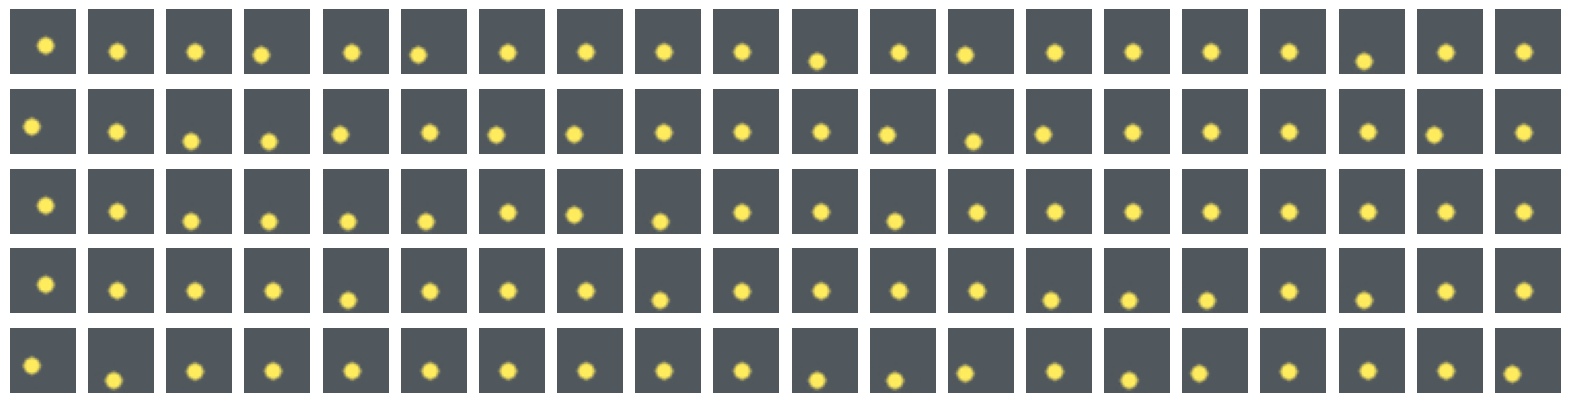

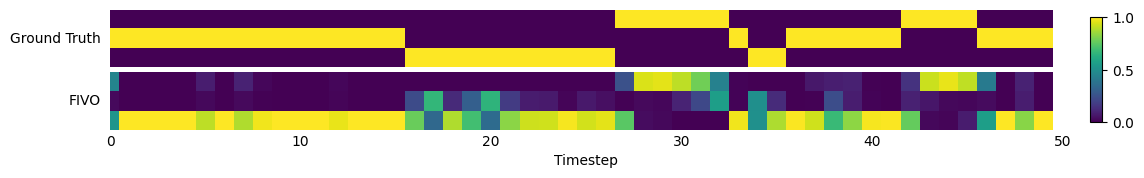

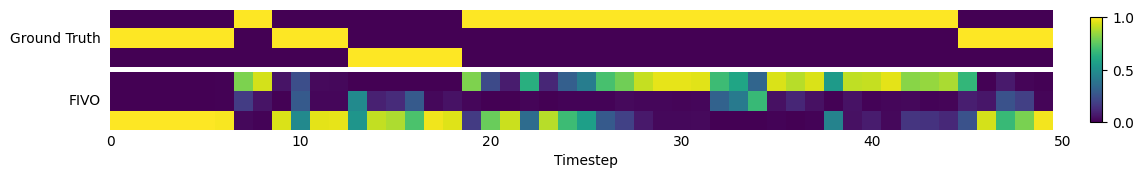

MSE: 0.00001
Pred MSE: 0.01477
Epoch: [13][50/625]	Time 2.301	Loss -882595.0000	 
Epoch: [13][100/625]	Time 2.705	Loss -881485.5625	 
Epoch: [13][150/625]	Time 2.413	Loss -876709.1875	 
Epoch: [13][200/625]	Time 2.560	Loss -879755.1875	 
Epoch: [13][250/625]	Time 2.729	Loss -878901.1875	 
Epoch: [13][300/625]	Time 2.414	Loss -882224.3750	 
Epoch: [13][350/625]	Time 2.946	Loss -882960.7500	 
Epoch: [13][400/625]	Time 2.322	Loss -882969.3750	 
Epoch: [13][450/625]	Time 2.586	Loss -882572.6250	 
Epoch: [13][500/625]	Time 2.399	Loss -883232.5625	 
Epoch: [13][550/625]	Time 2.434	Loss -879716.1250	 
Epoch: [13][600/625]	Time 2.610	Loss -882435.6875	 
MSE: 0.00003
Pred MSE: 0.01429
Epoch: [14][50/625]	Time 2.438	Loss -882829.1250	 
Epoch: [14][100/625]	Time 2.708	Loss -882515.0625	 
Epoch: [14][150/625]	Time 2.896	Loss -883130.5000	 
Epoch: [14][200/625]	Time 2.984	Loss -882195.4375	 
Epoch: [14][250/625]	Time 3.349	Loss -883065.7500	 
Epoch: [14][300/625]	Time 2.550	Loss -883328.1250	 
Epoc

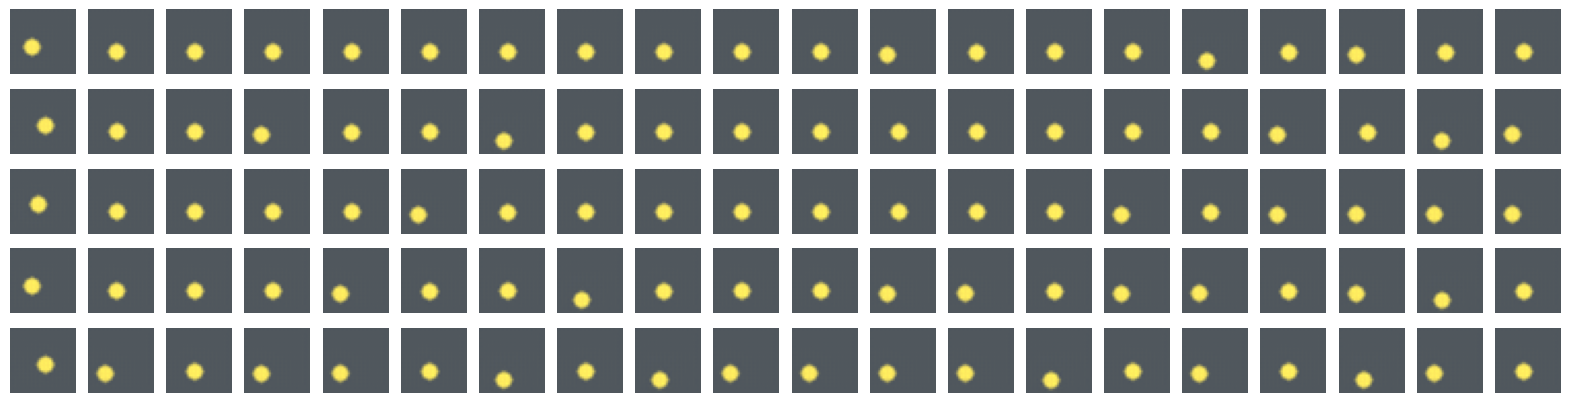

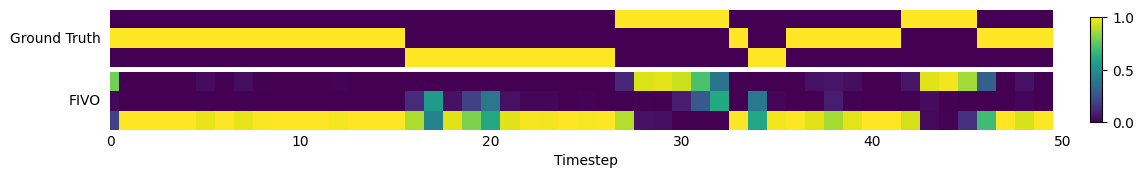

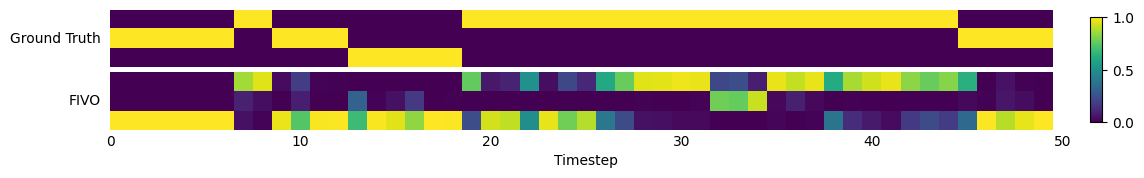

MSE: 0.00018
Pred MSE: 0.01449
Epoch: [15][50/625]	Time 4.111	Loss -870778.2500	 
Epoch: [15][100/625]	Time 2.599	Loss -872605.6250	 
Epoch: [15][150/625]	Time 4.068	Loss -878832.3750	 
Epoch: [15][200/625]	Time 2.886	Loss -870478.8750	 
Epoch: [15][250/625]	Time 2.643	Loss -881118.6875	 
Epoch: [15][300/625]	Time 2.939	Loss -878618.5000	 
Epoch: [15][350/625]	Time 2.602	Loss -882120.4375	 
Epoch: [15][400/625]	Time 2.860	Loss -879396.1250	 
Epoch: [15][450/625]	Time 2.611	Loss -879091.2500	 
Epoch: [15][500/625]	Time 2.768	Loss -881953.3750	 
Epoch: [15][550/625]	Time 2.800	Loss -880493.0000	 
Epoch: [15][600/625]	Time 2.702	Loss -879884.7500	 
MSE: 0.00001
Pred MSE: 0.01440
Epoch: [16][50/625]	Time 2.989	Loss -883249.0000	 
Epoch: [16][100/625]	Time 2.877	Loss -874133.5625	 
Epoch: [16][150/625]	Time 2.637	Loss -879383.6875	 
Epoch: [16][200/625]	Time 5.114	Loss -879044.7500	 
Epoch: [16][250/625]	Time 3.973	Loss -880459.0000	 
Epoch: [16][300/625]	Time 2.957	Loss -882991.0000	 
Epoc

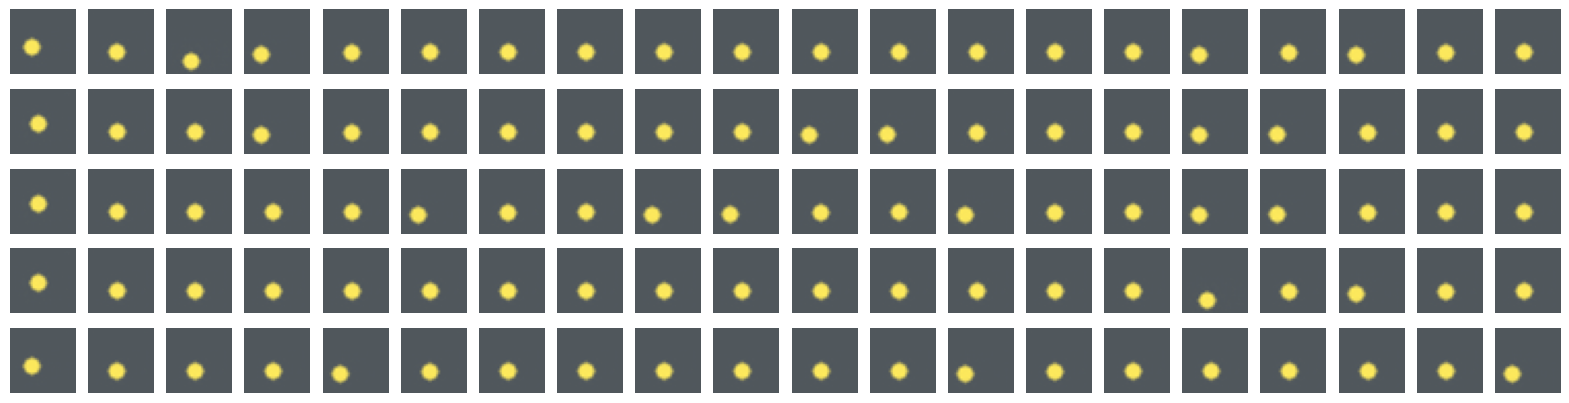

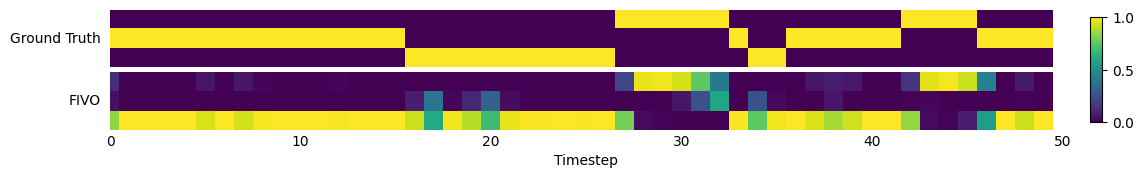

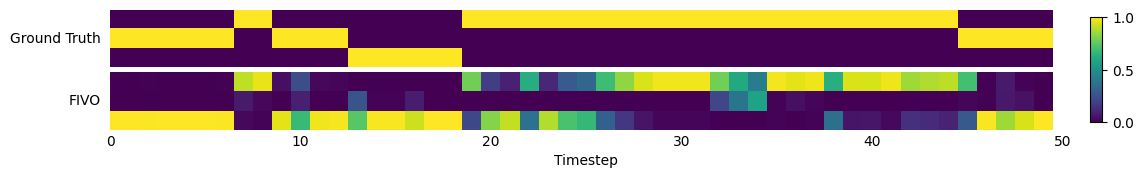

MSE: 0.00001
Pred MSE: 0.01408
Epoch: [17][50/625]	Time 2.727	Loss -878662.5000	 
Epoch: [17][100/625]	Time 2.669	Loss -876536.7500	 
Epoch: [17][150/625]	Time 4.202	Loss -873967.7500	 
Epoch: [17][200/625]	Time 4.164	Loss -882455.1250	 
Epoch: [17][250/625]	Time 2.771	Loss -882168.7500	 
Epoch: [17][300/625]	Time 3.429	Loss -881400.1250	 
Epoch: [17][350/625]	Time 2.652	Loss -882173.6875	 
Epoch: [17][400/625]	Time 2.831	Loss -881829.2500	 
Epoch: [17][450/625]	Time 3.591	Loss -883433.1875	 
Epoch: [17][500/625]	Time 2.671	Loss -882588.1250	 
Epoch: [17][550/625]	Time 2.486	Loss -883278.5000	 
Epoch: [17][600/625]	Time 2.839	Loss -882569.8750	 
MSE: 0.00001
Pred MSE: 0.01444
Epoch: [18][50/625]	Time 4.372	Loss -882938.0625	 
Epoch: [18][100/625]	Time 2.870	Loss -883396.7500	 
Epoch: [18][150/625]	Time 2.412	Loss -883022.8750	 
Epoch: [18][200/625]	Time 2.498	Loss -883361.6875	 
Epoch: [18][250/625]	Time 2.491	Loss -882782.7500	 
Epoch: [18][300/625]	Time 2.937	Loss -882754.8125	 
Epoc

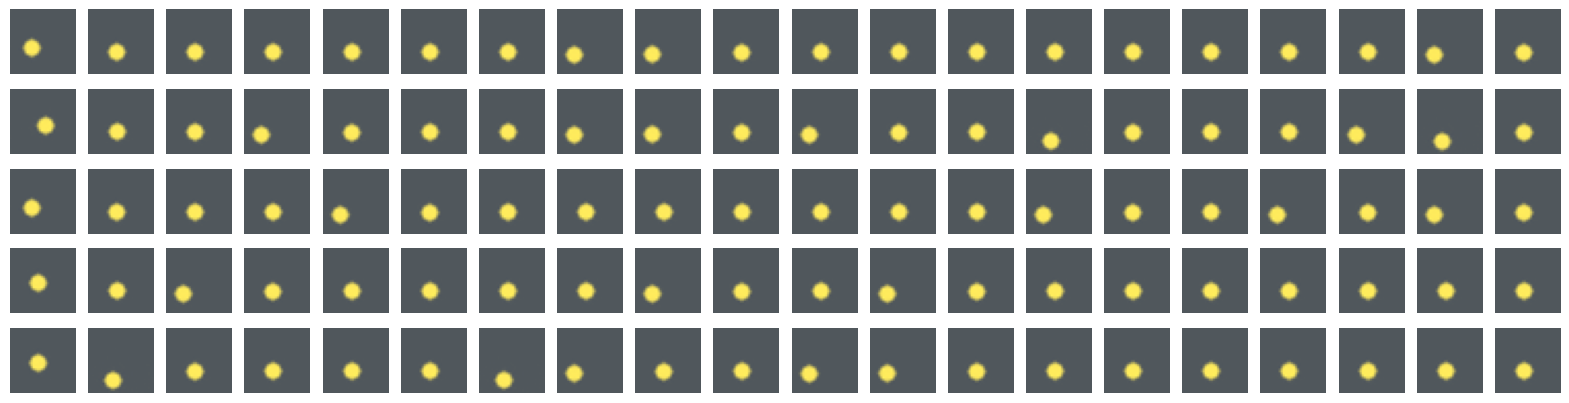

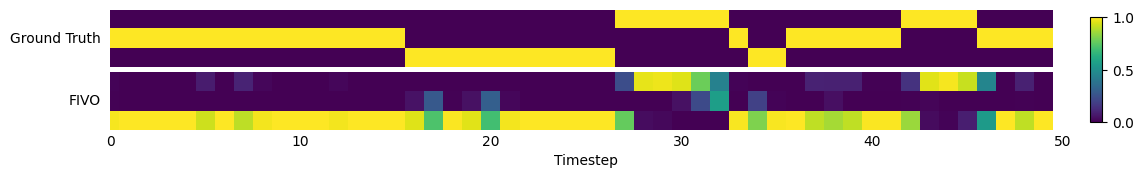

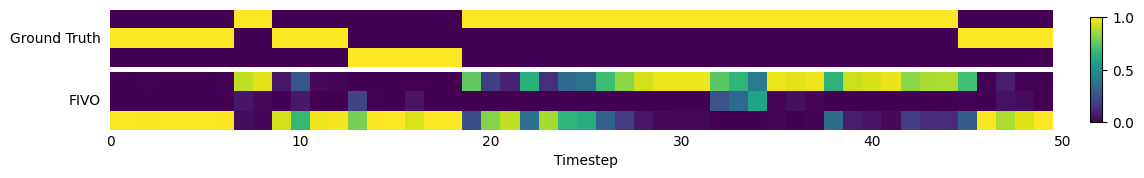

MSE: 0.00002
Pred MSE: 0.01426
Epoch: [19][50/625]	Time 2.975	Loss -883396.2500	 
Epoch: [19][100/625]	Time 2.832	Loss -883428.2500	 
Epoch: [19][150/625]	Time 2.755	Loss -883532.1875	 
Epoch: [19][200/625]	Time 2.718	Loss -883519.3750	 
Epoch: [19][250/625]	Time 2.479	Loss -883530.1250	 
Epoch: [19][300/625]	Time 2.611	Loss -883513.8750	 
Epoch: [19][350/625]	Time 2.454	Loss -876275.3750	 
Epoch: [19][400/625]	Time 2.539	Loss -880276.5000	 
Epoch: [19][450/625]	Time 3.224	Loss -877165.5000	 
Epoch: [19][500/625]	Time 5.005	Loss -881732.6250	 
Epoch: [19][550/625]	Time 3.969	Loss -880936.5625	 
Epoch: [19][600/625]	Time 2.620	Loss -882882.4375	 
MSE: 0.00002
Pred MSE: 0.01427
Epoch: [20][50/625]	Time 5.080	Loss -883433.1875	 
Epoch: [20][100/625]	Time 2.518	Loss -882554.6875	 
Epoch: [20][150/625]	Time 2.456	Loss -883353.0000	 
Epoch: [20][200/625]	Time 3.961	Loss -882823.1875	 
Epoch: [20][250/625]	Time 2.899	Loss -883475.6250	 
Epoch: [20][300/625]	Time 2.998	Loss -883200.1250	 
Epoc

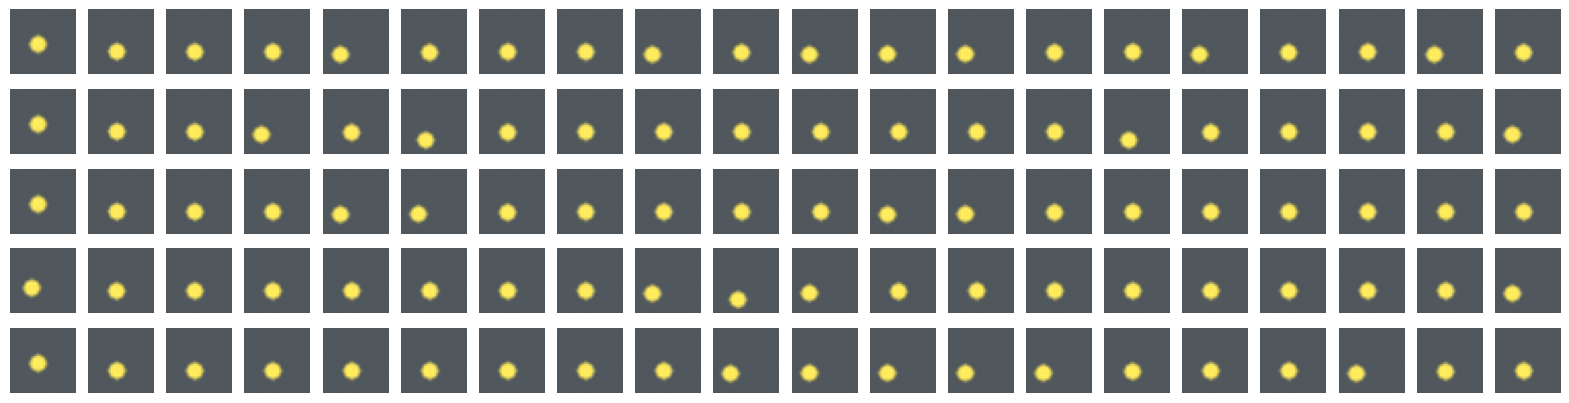

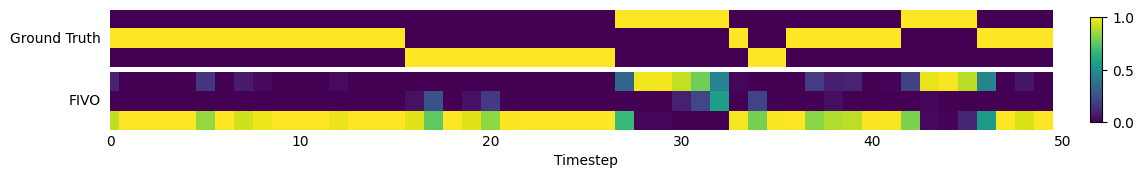

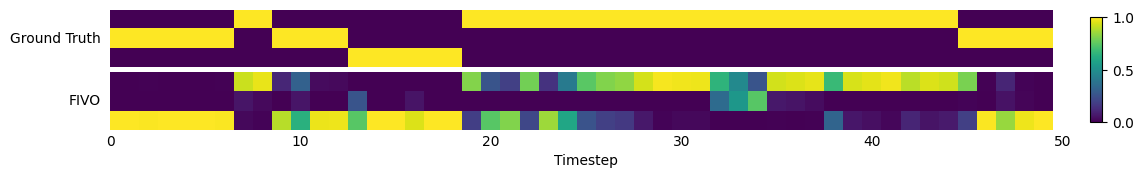

MSE: 0.00019
Pred MSE: 0.01403


KeyboardInterrupt: 

In [17]:
fivo_losses, test_mse_fivo, pred_mse_fivo = train_fivo(N, model, optimizer,num_states, dim_latent, T)

In [27]:
# Save/Load model

PATH = 'snlds_video_200_fivo_long.pth'
torch.save(model.state_dict(), PATH)
# model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
# model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
# model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
plt.plot(fivo_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

NameError: name 'fivo_losses' is not defined

In [ ]:
plt.plot(np.arange(500,len(fivo_losses)),fivo_losses[500:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

In [ ]:
plt.plot(test_mse_fivo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
plt.plot(pred_mse_fivo)
plt.xlabel('Epoch')
plt.ylabel('Pred MSE')

In [ ]:
# Training time: 603min
print(f"Last FIVO Loss: {fivo_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse_fivo[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_fivo[-1]:.6f}")

In [ ]:
print(f"Best FIVO Loss: {min(fivo_losses):.1f}")
print(f"Best Test MSE: {min(test_mse_fivo):.6f}")
print(f"Best Pred MSE: {min(pred_mse_fivo):.6f}")

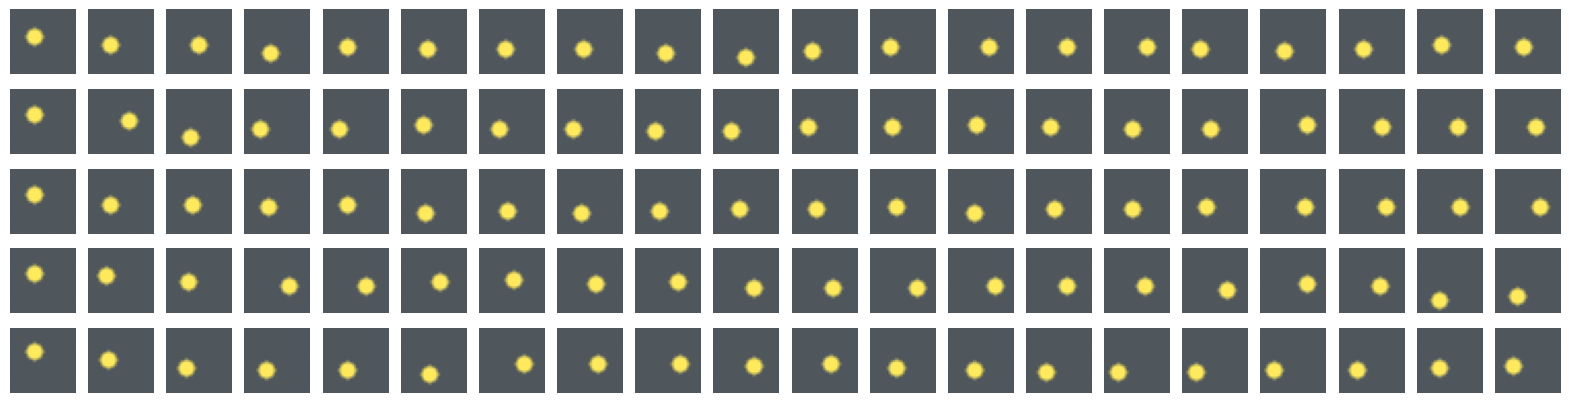

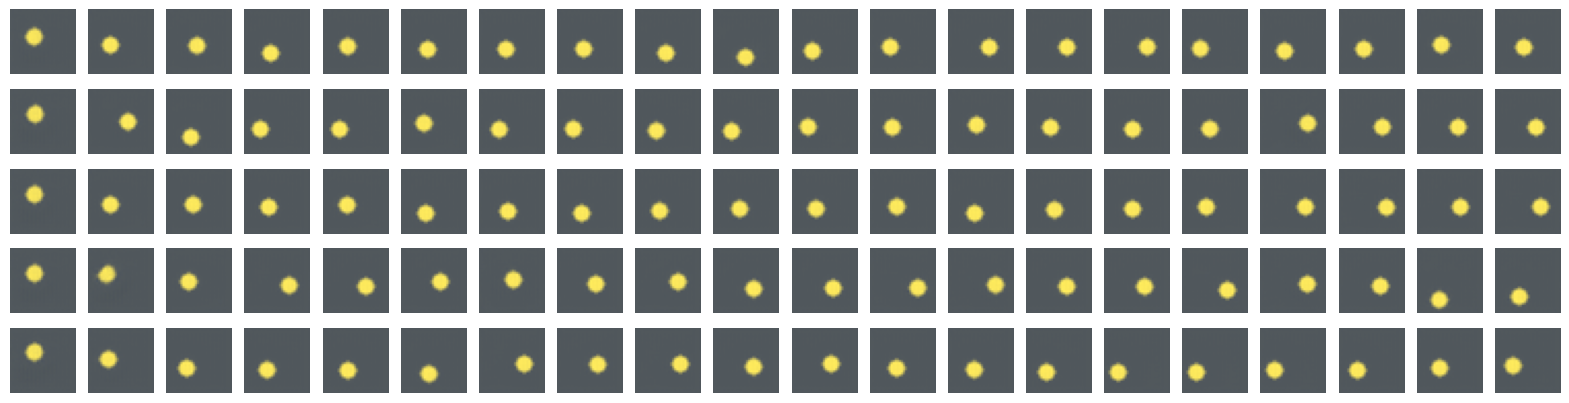

In [28]:
# Reconstructions

n_samples = 5
t = 20
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    x = x + 0.5
    (B,T,C,H,W) = x.shape
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = torch.clamp(recon_x,max=1.0)
    recon_x = recon_x.cpu().reshape(B,T,C,H,W).numpy()

imshow_grid((x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid((recon_x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

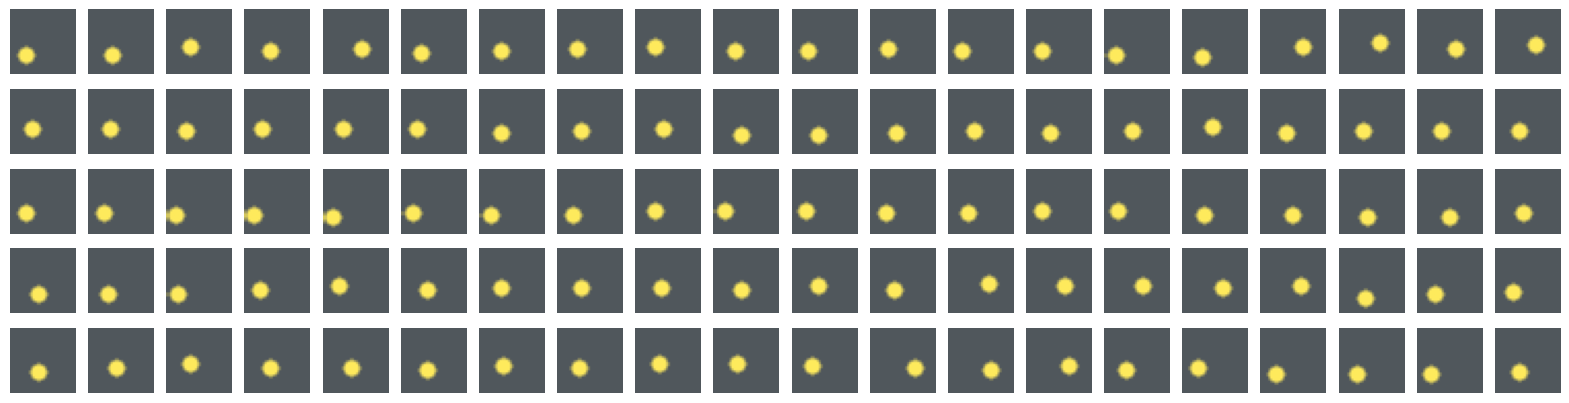

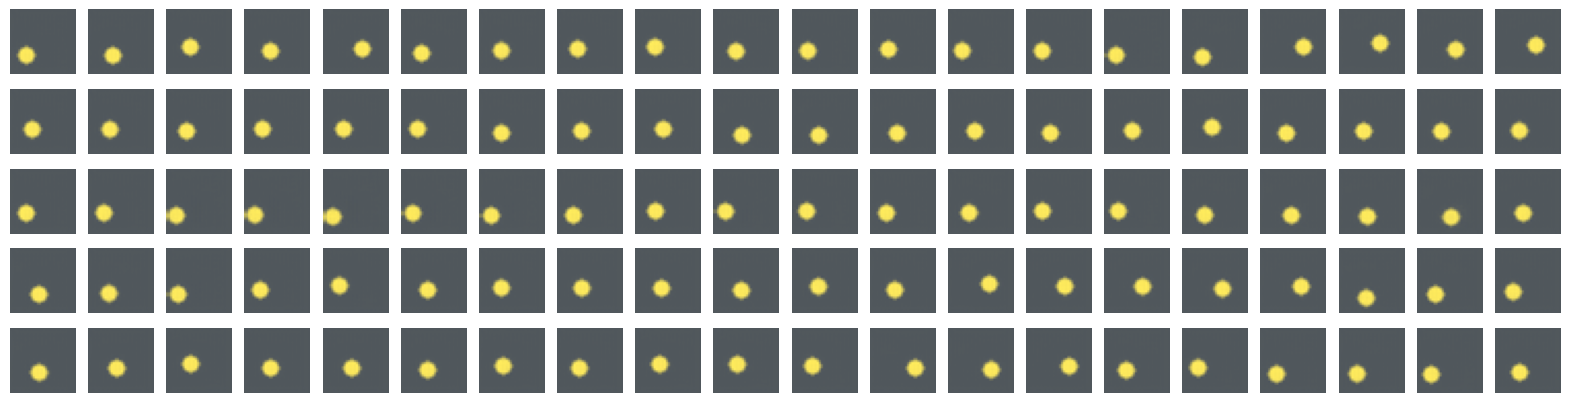

In [29]:
# Last 20 timesteps

imshow_grid((x-0.5)[0:n_samples,80:101], n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid((recon_x-0.5)[0:n_samples,80:101], n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

In [30]:
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.5f}")

t=0 MSE per pixel:0.00025
t=1 MSE per pixel:0.00036
t=2 MSE per pixel:0.00021
t=3 MSE per pixel:0.00008
t=4 MSE per pixel:0.00015
t=5 MSE per pixel:0.00015
t=6 MSE per pixel:0.00008
t=7 MSE per pixel:0.00006
t=8 MSE per pixel:0.00011
t=9 MSE per pixel:0.00006
t=10 MSE per pixel:0.00022
t=11 MSE per pixel:0.00007
t=12 MSE per pixel:0.00017
t=13 MSE per pixel:0.00009
t=14 MSE per pixel:0.00010
t=15 MSE per pixel:0.00009
t=16 MSE per pixel:0.00018
t=17 MSE per pixel:0.00006
t=18 MSE per pixel:0.00008
t=19 MSE per pixel:0.00016
t=20 MSE per pixel:0.00018
t=21 MSE per pixel:0.00016
t=22 MSE per pixel:0.00016
t=23 MSE per pixel:0.00012
t=24 MSE per pixel:0.00009
t=25 MSE per pixel:0.00011
t=26 MSE per pixel:0.00006
t=27 MSE per pixel:0.00009
t=28 MSE per pixel:0.00006
t=29 MSE per pixel:0.00015
t=30 MSE per pixel:0.00008
t=31 MSE per pixel:0.00007
t=32 MSE per pixel:0.00010
t=33 MSE per pixel:0.00008
t=34 MSE per pixel:0.00018
t=35 MSE per pixel:0.00012
t=36 MSE per pixel:0.00007
t=37 MSE pe

Text(0, 0.5, 'MSE per Pixel')

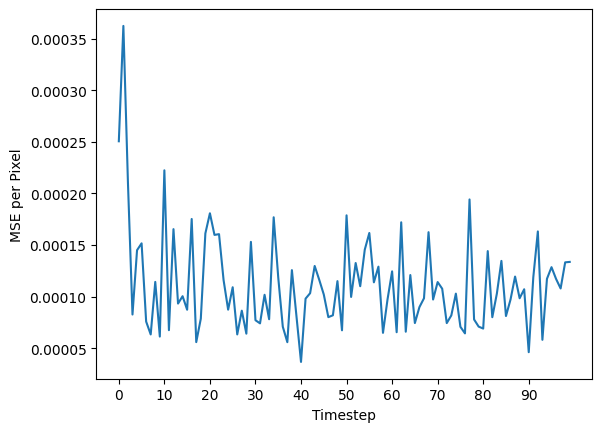

In [32]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,100,10))
plt.ylabel('MSE per Pixel')

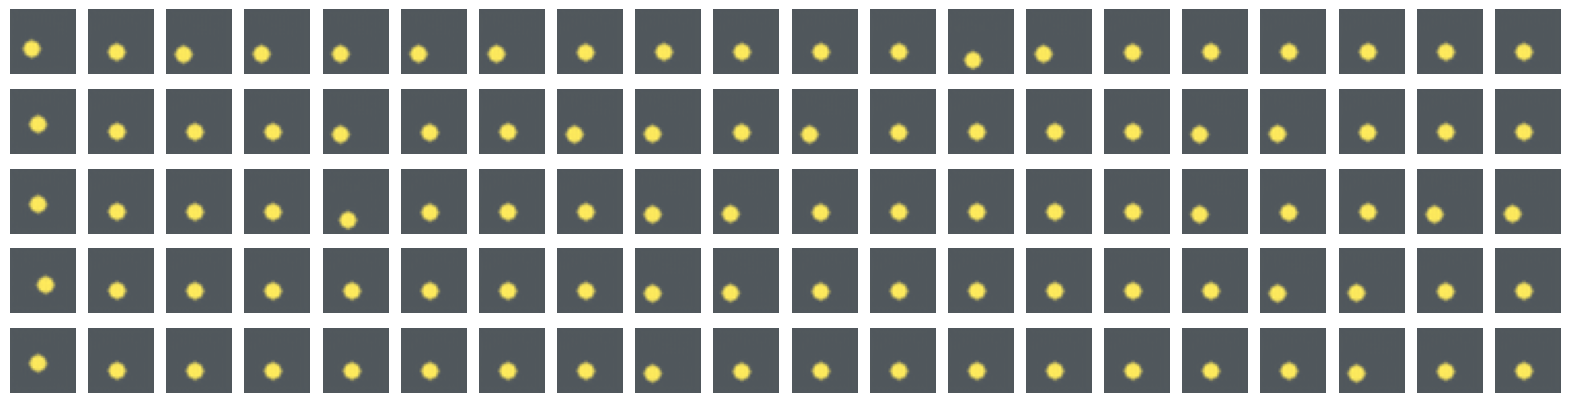

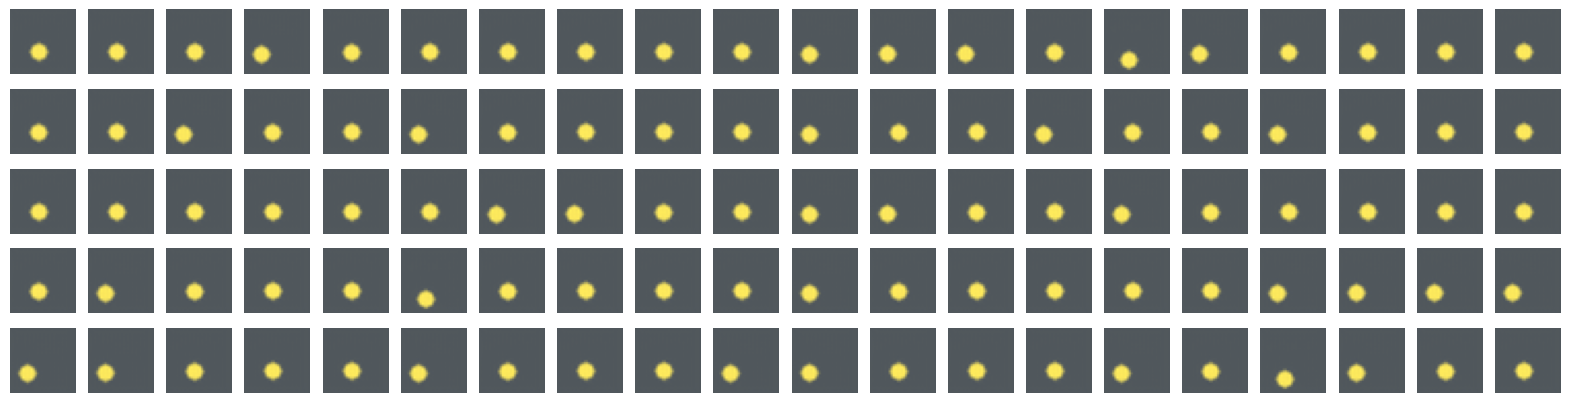

In [33]:
# Create samples

n_samples = 5
seq_len = 100
model.eval()
with torch.inference_mode():
    s = model.sample(n_samples,seq_len)
    s = s.cpu().reshape(n_samples,seq_len,3,32,32)
    s = torch.clamp(s - 0.5,max=0.5).numpy()

# First 20 timesteps
imshow_grid(s, n_row=n_samples, n_col=20, fig_size_a=20, fig_size_b=n_samples)     

# Last 20 timesteps
imshow_grid(s[:,80:], n_row=n_samples, n_col=20, fig_size_a=20, fig_size_b=n_samples)  

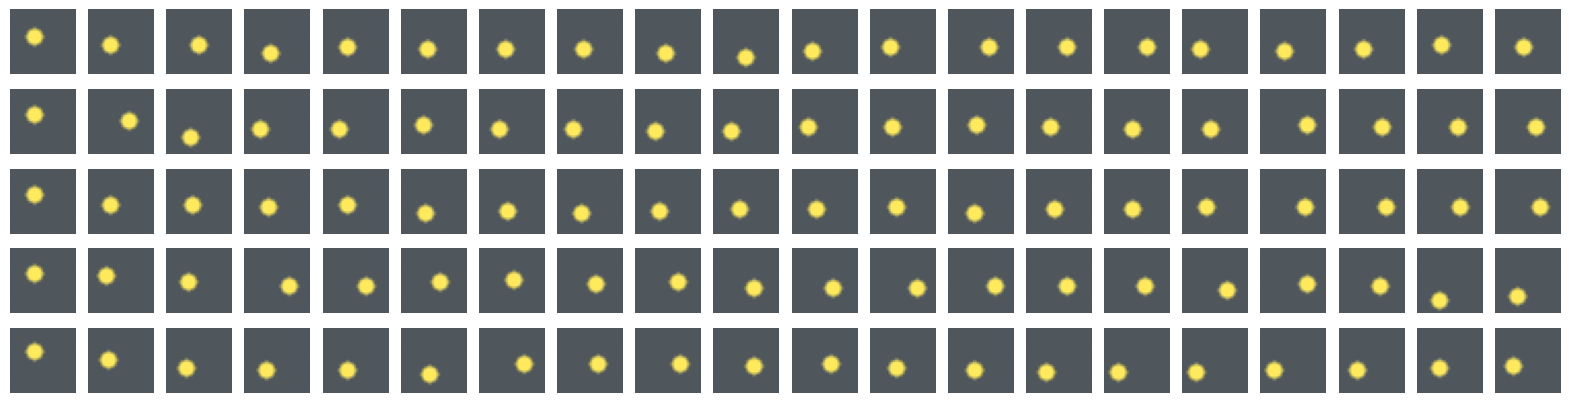

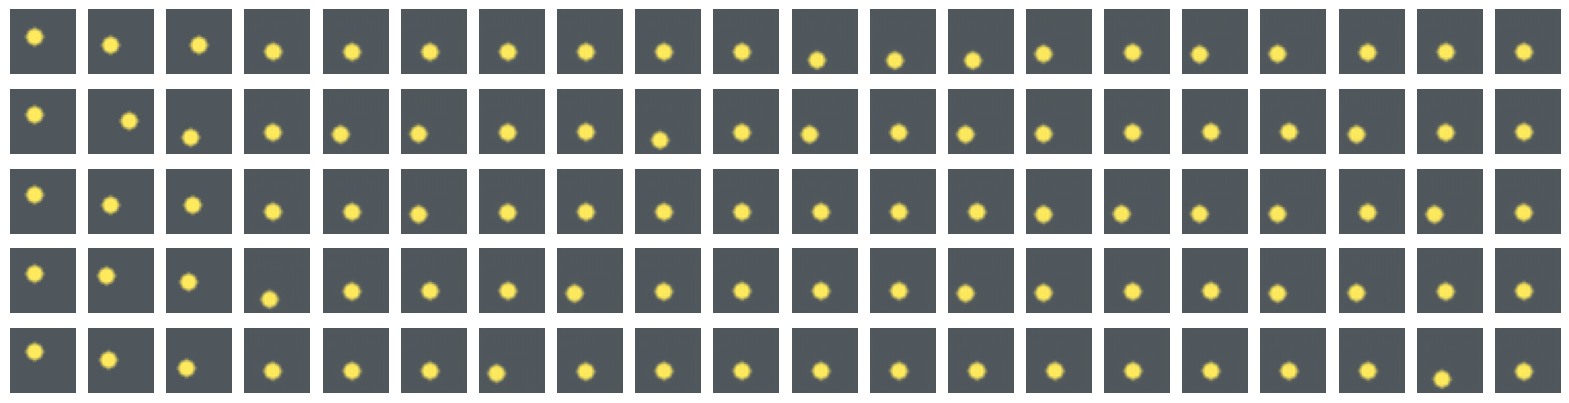

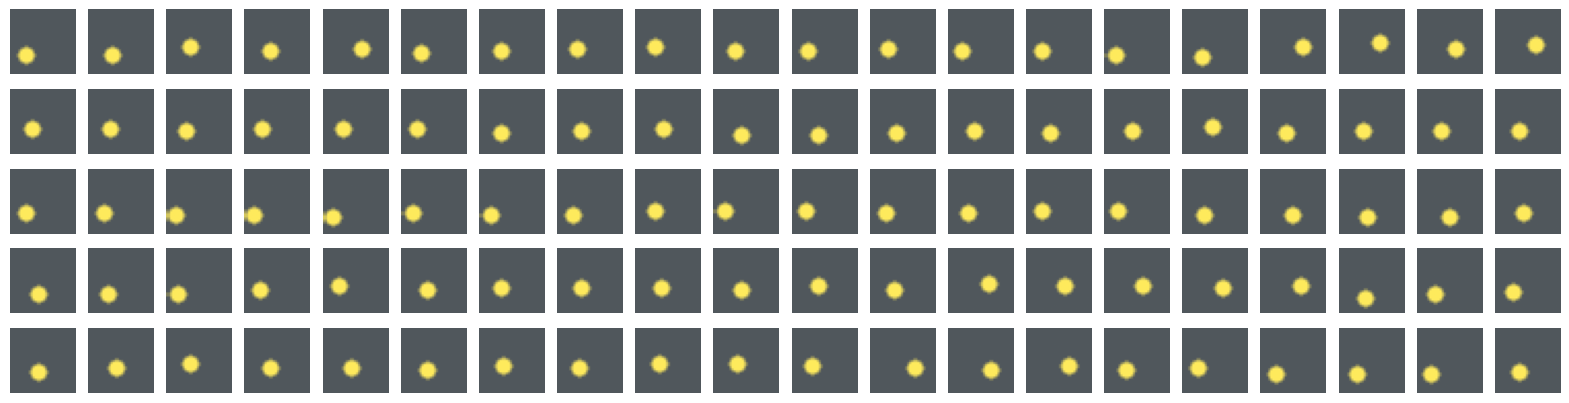

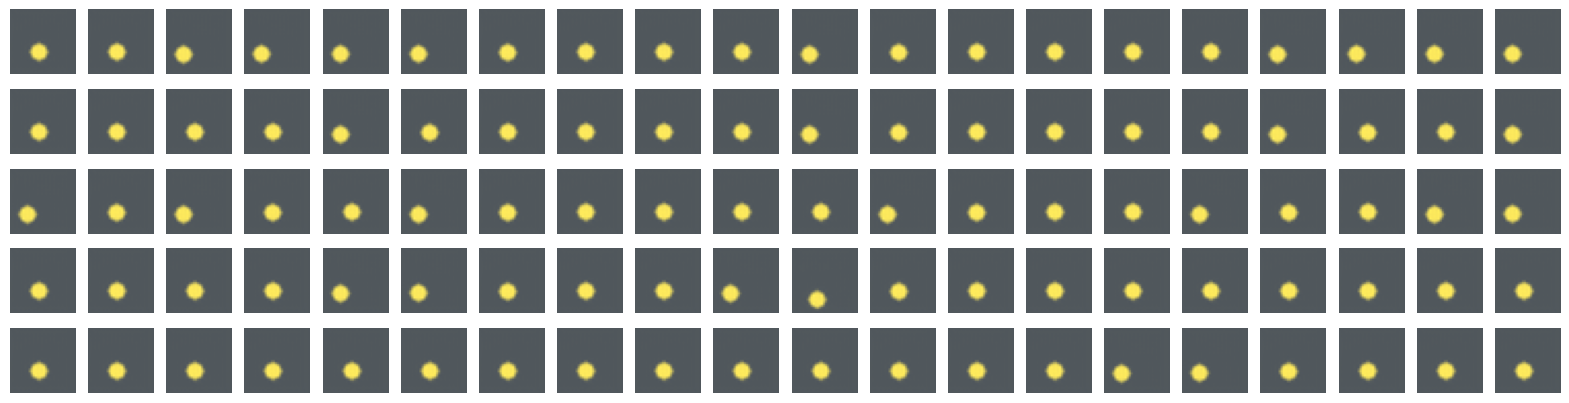

In [34]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE
with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device)) + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=97)
    preds = preds.reshape(B,97,3,32,32)
    preds = torch.clamp(preds,max=1.0)
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.cpu().numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)

# Last 20 timesteps
imshow_grid((x[:5,80:]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
imshow_grid((preds[:5,80:]-0.5), n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)

In [35]:
with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=97)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 97, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

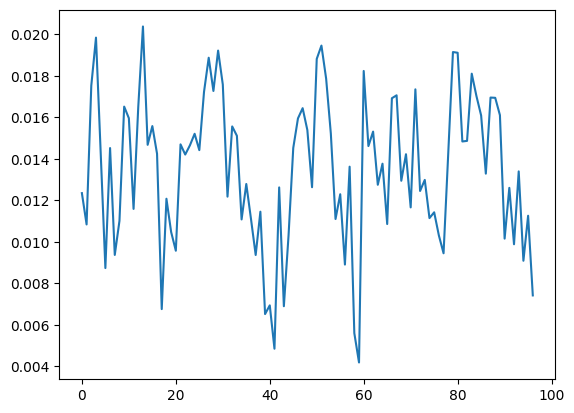

In [37]:
plt.plot(predict_mse[0])

# Final Tests

In [12]:
PATH = 'snlds_video_200_elbo.pth'
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO>IWAE>ELBO
model.beta = 1
with torch.inference_mode():
    fivo_list = []
    for (sample,) in tqdm.tqdm(test_dataloader):
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        fivo, _ = model.fivo(obs_var, 10)
        fivo = -fivo
        fivo_list.append(fivo.cpu())
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.2f}")

100%|██████████| 32/32 [01:27<00:00,  2.73s/it]

FIVO: 883905.81


In [13]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO>IWAE>ELBO
model.beta = 1
with torch.inference_mode():
    elbo_list = []
    elbo_2_list = []
    iwae_list = []
    fivo_list = []
    for (sample,) in tqdm.tqdm(test_dataloader):
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        _, _, _, losses = model(obs_var)
        elbo_2, _ = model.iwae_efficient(obs_var, 1)
        iwae, _ = model.iwae_efficient(obs_var, 10)
        fivo, _ = model.fivo_efficient(obs_var, 10)
        elbo = -losses['loss']
        elbo_2 = -elbo_2
        iwae = -iwae
        fivo = -fivo
        elbo_list.append(elbo.cpu())
        elbo_2_list.append(elbo_2.cpu())
        iwae_list.append(iwae.cpu())
        fivo_list.append(fivo.cpu())
    print(f"ELBO: {sum(elbo_list)/len(elbo_list):.2f}")
    print(f"ELBO: {sum(elbo_2_list)/len(elbo_2_list):.2f}")
    print(f"IWAE: {sum(iwae_list)/len(iwae_list):.2f}")
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.2f}")

  0%|          | 0/32 [00:00<?, ?it/s]/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 16.62 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv_transpose2d(
/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 25.83 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv_transpose2d(
/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


ELBO: 883857.12
ELBO: 883856.44
IWAE: 884001.69
FIVO: 883904.69


In [17]:
# First 20 timesteps. Probability of discrete states

latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/states_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
latent_loader = DataLoader(latents_dataset, batch_size=16, shuffle=False)
latents_states = next(iter(latent_loader))[0]
latents_states = latents_states[:,::2]
obs = next(iter(test_dataloader))[0]

# ELBO
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_video_200_elbo.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_elbo = model.gamma(obs[:,:].float().to(device))
# IWAE
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_video_200_iwae_long.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_iwae = model.gamma(obs[:,:].float().to(device))
# FIVO
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_video_200_fivo_long.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_fivo = model.gamma(obs[:,:].float().to(device))


/tmp/ipykernel_989410/1018563562.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels([f'{int(label)}' for label in new_labels])


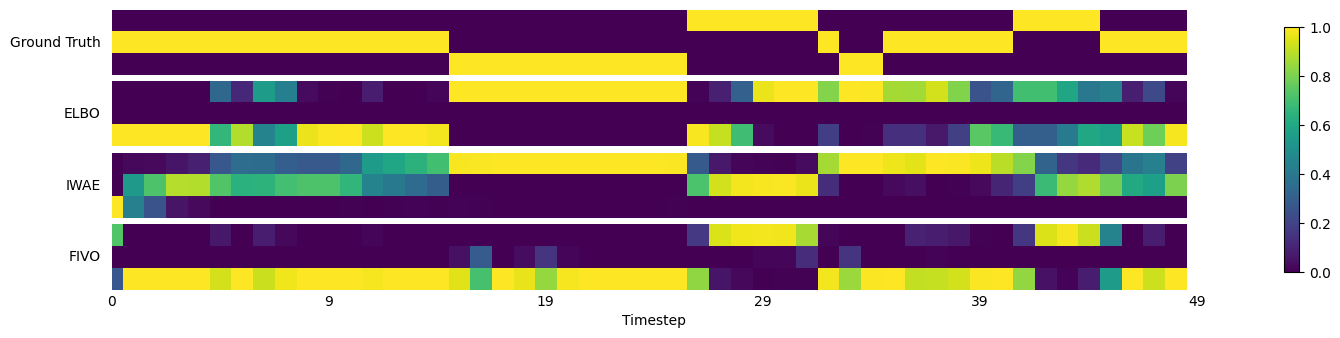

/tmp/ipykernel_989410/1018563562.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels([f'{int(label)}' for label in new_labels])


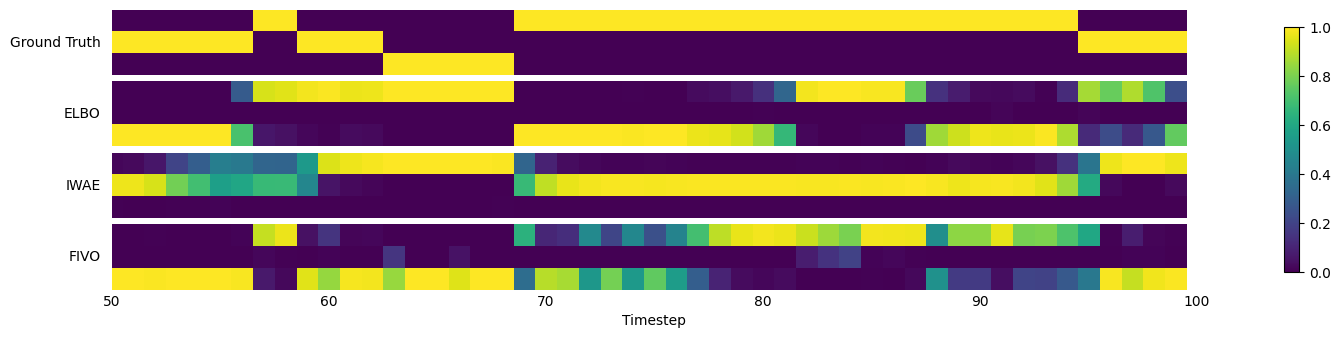

In [18]:
plot_models(gamma_elbo[:,:50], gamma_iwae[:,:50], gamma_fivo[:,:50], latents_states[:,:50],[0,49])
plot_models(gamma_elbo[:,50:], gamma_iwae[:,50:], gamma_fivo[:,50:], latents_states[:,50:],[50,100])

In [20]:
latents_states = latents_states.cpu().numpy()
gamma_elbo = gamma_elbo.cpu().numpy()
gamma_iwae = gamma_iwae.cpu().numpy()
gamma_fivo = gamma_fivo.cpu().numpy()

In [32]:
print(f"ELBO:{best_f1_score(latents_states, gamma_elbo):.2f}")
print(f"IWAE:{best_f1_score(latents_states, gamma_iwae):.2f}")
print(f"FIVO:{best_f1_score(latents_states, gamma_fivo):.2f}")

ELBO:0.48
IWAE:0.52
FIVO:0.43


In [31]:
print(f"ELBO:{best_cross_entropy_loss(latents_states, gamma_elbo):.2f}")
print(f"IWAE:{best_cross_entropy_loss(latents_states, gamma_iwae):.2f}")
print(f"FIVO:{best_cross_entropy_loss(latents_states, gamma_fivo):.2f}")

ELBO:7.88
IWAE:2.88
FIVO:3.89
